# TODO

In [34]:
# Lake78 stationary_outline_dV (m^3) appears too small
# 1_evolving_lakes/Sauthoff-202X-evolving-lakes/output/geometric_calcs/compare_evolving_and_stationary_outlines/Lake78.csv
# stationary outline area appears to be zero in this plot:
# 1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_and_stationary_comparison/Lake78.png

# Foundation_7 saved both geojson and no_outlines text file in evolving_outlines; investigate by rerunning algo on it

# # Saved geojson's behave differently: 
# # evolving_outlines_gdfs have midcyc_datetime open as timestamp whereas 
# # compare_evolving_stationary_outlines_gdfs have midcyc_datetime open as string
# evolving_outlines_gdf = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(SF18_lake_gdf['name'].values[0])))
# print(type(evolving_outlines_gdf['midcyc_datetime'][0]))
# geom_calcs_df = pd.read_csv(os.path.join(
#     os.getcwd(), 'output/lake_outlines/compare_evolving_stationary_outlines/{}.csv'.format(SF18_lake_gdf['name'].values[0])))
# print(type(geom_calcs_df['midcyc_datetime'][0]))
# Is this an issue?

# In visualize_and_save_evolving_outlines, find out how metadata is stored (what order) appears out of order:
# evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format('Foundation_5'))
# evolving_outlines_gdf

# write_no_outlines for Site_B; when is it originally happening? should it be added to find_and_save_optimal_parameters? 

# Change <'output/> to <'output/> for simplicity?

# From Fig S1 add multicolored off-lake outlines to plot_evolving_outlines_time_series

# find_evolving_outlines storing the wrong mid_cyc_date for lakes within the CS-2 SARIn mode that went inland in 2013

# Add minor ticks to plotting plot_evolving_outlines_time_series and plot_evolving_and_stationary_comparison:
# Define major and minor years
# major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
# minor_years = list(range(2012, 2025))
# major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
# minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

# cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
# cbar.set_ticks(major_dates)
# cbar.set_ticklabels(major_years)
# cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
# cbar.set_label('evolving outline year', size=12, labelpad=3)

# compare_evolving_and_stationary_outlines and compare_union_and_stationary_outlines functions 
# record the cycle end date vs. midcyc date

# (non-urgent) evolving_outlines_gdf['row_index'] not stored properly for off-lake outlines

# Change CS2_SARIn_time_period to CS2_SARIn_start to have more compact code and not inaccurately confuse that time period ends at 2018.75

# Move os.makedirs() calls out of functions into cells where func is first called

In [85]:
# invetigating lake78 no area thing
stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Lake78']

,name,area (m^2),cite,CS2_SARIn_time_period,geometry
89,Lake78,233.002708,"Carter and others, 2013, J. Glac., doi:10.3189...",2010.5-2018.75,"MULTIPOLYGON (((-257325.009 -525800.047, -2571..."


Code to do data analysis of re-examined active subglacial lakes and create Fig. S1 in Sauthoff and others, 202X, _Journal_.

Written 2023-07-11 by W. Sauthoff (wsauthoff.github.io).

# Set up computing environment

This code runs continental-scale operations on multiple datasets and requires a ~32 GB server or local memory.

In [35]:
%pip install earthaccess --quiet

Note: you may need to restart the kernel to use updated packages.


In [36]:
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


In [37]:
%pip install opencv-python --quiet

Note: you may need to restart the kernel to use updated packages.


In [38]:
%pip install pyogrio --quiet

Note: you may need to restart the kernel to use updated packages.


In [39]:
# Import libraries
from collections import defaultdict
import cv2
import datetime
import earthaccess
import fiona
import gc
import geopandas as gpd
import glob
from IPython.display import clear_output
import logging
import matplotlib
matplotlib.use('Agg')  # Set backend to Agg to avoid NavigationToolbar issue
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
from pathlib import Path
import pandas as pd
import pyogrio
from pyproj import CRS, Geod, Transformer
import re
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, MultiPolygon, Point, Polygon
from shapely.ops import unary_union
from shapely.validation import make_valid
import shutil
from skimage import measure
import time
import traceback
from typing import Dict, List, Tuple
import warnings
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods'
    OUTPUT_DIR_GIT = '/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# Change default font to increase font size
plt.rcParams.update({'font.size': 8})

# Define functions

In [40]:
def date_to_quarter_year(date):
    """Convert datetime64 to year.quarter."""
    if isinstance(date, np.datetime64):
        date = pd.Timestamp(date)
    
    return date.year + (date.quarter - 1) * 0.25

In [41]:
def area_multiple_buffer(ref_polygon, area_multiple, precision=100, exclude_inner=False):
    '''
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple of the original polygon area. Optionally excludes the inner polygon
    to create a ring-like shape.
    
    Inputs:
    * param polygon: Shapely Polygon object
    * param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    * param precision: Precision for the iterative process to find the buffer distance
    * param exclude_inner: If True, returns the difference between the buffered area and original polygon
    * return: Buffered Polygon or Ring-like Polygon (if exclude_inner=True)
    '''
    # Ensure we're working with a single geometry, not a Series
    if hasattr(ref_polygon, 'iloc'):
        ref_polygon = ref_polygon.iloc[0]
        
    original_area = ref_polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    area_multiple_polygon = ref_polygon
    
    while area_multiple_polygon.area < target_area:
        buffer_distance += precision
        area_multiple_polygon = ref_polygon.buffer(buffer_distance)
    
    if exclude_inner:
        # Return the difference between the buffered polygon and the original polygon
        return area_multiple_polygon.difference(ref_polygon)
    else:
        return area_multiple_polygon

In [42]:
def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True, prefix=None, suffix=None, suffix_pattern=None, file_extension=None):
    '''
    Filter the GeoDataFrame based on processed lake names from the folder contents.
    
    Args:
    gdf: GeoDataFrame to be filtered.
    folder_path: Path to the directory containing files and/or subdirectories.
    exclude: If True, excludes gdf rows where the 'name' is in the folder_path directories or files.
             If False, includes only gdf rows where the 'name' is in the folder_path directories or files.
    prefix: Optional string to remove from the beginning of filenames.
    suffix: Optional string to remove from the end of filenames.
    suffix_pattern: Optional regex pattern to remove from the end of filenames.
    file_extension: Optional string specifying the file extension to filter (e.g., 'png', 'txt').
    
    Returns:
    GeoDataFrame filtered based on the presence of 'name' in folder_path.

    # Example usage:
    remaining_lakes = filter_gdf_by_folder_contents(
        stationary_outlines_gdf, 
        folder_path,
        # prefix='plot_evolving_outlines_time_series_', 
        suffix_pattern=r'\d+\.\d+m-level_\d+x-with',
        file_extension='txt'
    )
    '''
    def process_name(name):
        """Helper function to remove prefix and suffix from a name"""
        processed_name = name
        
        # First strip the file extension if it exists
        processed_name = os.path.splitext(processed_name)[0]
        
        # if prefix and processed_name.startswith(prefix):
        #     processed_name = processed_name[len(prefix):]
            
        if suffix_pattern:
            processed_name = re.sub(suffix_pattern + '$', '', processed_name)
        elif suffix and processed_name.endswith(suffix):
            processed_name = processed_name[:-len(suffix)]
            
        return processed_name.lower().strip()
    
    # Get all files and filter by extension if specified
    all_files = os.listdir(folder_path)
    if file_extension:
        clean_extension = file_extension.lstrip('.')
        all_files = [f for f in all_files if f.lower().endswith(f'.{clean_extension.lower()}')]
    
    # Process filenames to get lake names
    names_in_folder = {
        process_name(name)
        for name in all_files
    }
    
    # Filter without adding and then dropping a new column
    gdf_filtered = gdf[gdf['name'].str.lower().str.strip().apply(
        lambda x: (x not in names_in_folder) if exclude else (x in names_in_folder)
    )]
    
    return gdf_filtered.reset_index(drop=True)

## find_and_save_optimal_parameters

In [43]:
def find_and_save_optimal_parameters(lake_gdf, within_area_multiples=range(2, 16)):
    '''
    Find and save optimal levels for each lake at various within evaluation boundaries.
    '''
    results = find_optimal_parameters(lake_gdf=lake_gdf, within_area_multiples=within_area_multiples)
    save_search_results(lake_gdf, results)
    clear_output(wait=True)

def find_optimal_parameters(lake_gdf, 
                          within_area_multiples=range(2, 16),
                          initial_level=0.01,
                          level_increment=0.01,
                          within_fraction_target=0.95):
    '''
    Find optimal search extent and level parameters for a lake.     
    '''
    # Initialize results DataFrame
    results_df = pd.DataFrame(
        columns=['within_area_multiple', 'level', 'within_percent', 'dataset_dois'])

    # Prepare datasets
    dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 30)
    
    try:
        for area_multiple in within_area_multiples:
            print('Finding optimal levels at within evaluation boundaries for', lake_gdf['name'].iloc[0])
            level = initial_level
            # found_for_current_multiple = False  # Track if we found result for this multiple
            # stop_incrementing = False
            
            # while level <= 2.0 and not found_for_current_multiple and not stop_incrementing:
            while level <= 2.0:
                outlines_gdf = find_evolving_outlines(
                    lake_gdf=lake_gdf,
                    within_area_multiple=area_multiple,
                    level=level,
                    dataset1_masked=dataset1_masked,
                    dataset2_masked=dataset2_masked, 
                    search_extent_poly=search_extent_poly,
                    plot=False
                )

                if outlines_gdf is not None and not outlines_gdf.empty:
                    within_fraction = calculate_within_fraction(
                        outlines_gdf, lake_gdf['geometry'], area_multiple)
                    print(f"within_area_multiple: {area_multiple}, level: {level}, within: {round(within_fraction*100)}%")

                    if within_fraction == 0.0:
                        print(f"Within fraction is 0.0, stopping search for area_multiple: {area_multiple}")
                        # stop_incrementing = True
                        break

                    if within_fraction >= within_fraction_target:
                        onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                            outlines_gdf, lake_gdf['geometry'].iloc[0]
                        )
                        
                        if not onlake_outlines.empty:
                            # Add result
                            dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
                            results_df.loc[len(results_df)] = {
                                'within_area_multiple': area_multiple,
                                'level': level,
                                'within_percent': within_fraction * 100,
                                'dataset_dois': ', '.join(dois)
                            }
                            found_for_current_multiple = True  # Mark that we found result for this area_multiple
                            break  # Found a good result for this area_multiple, move to next
                        else:
                            print("onlake_outlines is empty, continuing search")
                else:
                    print(f"within_area_multiple: {area_multiple}, level: {level}, within: no outlines found")
                    print(f"No outlines found, stopping search for area_multiple: {area_multiple}")
                    # stop_incrementing = True  # Stop if no outlines found
                    break

                # # Only increment level if we haven't found a result
                # if not found_for_current_multiple:
                #     level = round(level + level_increment, 2)
                level = round(level + level_increment, 2)

            # Clear output for each within_area_multiple
            clear_output(wait=True)
            
    except Exception as e:
        print(f"Error processing lake {lake_gdf['name']}: {str(e)}")
        return pd.DataFrame()
    finally:
        gc.collect()

    # Sort the DataFrame
    results_df = results_df.sort_values(
        by=['level', 'within_area_multiple'], 
        ascending=[True, True])

    results_df = remove_higher_duplicates(results_df)
        
    return results_df

def calculate_within_fraction(evolving_outlines_gdf, stationary_outline, area_multiple):
    """
    Calculate fraction of evolving outlines that fall within the search extent.
    
    Parameters:
    -----------
    evolving_outlines_gdf : GeoDataFrame
        The evolving outlines to analyze
    stationary_outline : Geometry
        The original lake outline
    area_multiple : int
        Area multiple for within evaluation boundary
        
    Returns:
    --------
    float
        Fraction of outlines that are within the search extent (0.0 to 1.0)
    """
    # Create search extent boundary
    within_evaluation_poly = area_multiple_buffer(
        ref_polygon=stationary_outline, 
        area_multiple=area_multiple)
    within_evaluation_gdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries([within_evaluation_poly]), 
        crs=3031)

    # Validate geometries
    valid_outlines = evolving_outlines_gdf.loc[
        evolving_outlines_gdf.is_valid & ~evolving_outlines_gdf.is_empty].copy()
    valid_within_evaluation_poly = within_evaluation_gdf.loc[
        within_evaluation_gdf.is_valid & ~within_evaluation_gdf.is_empty].copy()
    
    if valid_outlines.empty or valid_within_evaluation_poly.empty:
        return 0.0

    # Convert geometries to ensure they're polygons
    valid_outlines.loc[:, 'geometry'] = valid_outlines['geometry'].apply(
        lambda geom: geom if isinstance(geom, Polygon) else Polygon())
    valid_within_evaluation_poly.loc[:, 'geometry'] = valid_within_evaluation_poly['geometry'].apply(
        lambda geom: geom if isinstance(geom, Polygon) else Polygon())

    # Perform spatial analysis
    within = gpd.sjoin(valid_outlines, within_evaluation_gdf, predicate='within')
    overlaps = gpd.sjoin(valid_outlines, within_evaluation_gdf, predicate='overlaps')

    # Calculate fraction that are within
    total = len(within) + len(overlaps)
    if total > 0:
        return round(len(within) / total, 2)
    return 0.0

def remove_higher_duplicates(df):
    """
    Remove rows that have duplicate 'level' values at higher 'within_area_multiple' values.
    Assumes the dataframe is already sorted by 'level' and 'within_area_multiple'.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with 'level' and 'within_area_multiple' columns
    
    Returns:
    pandas.DataFrame: DataFrame with duplicates removed
    """
    # Keep track of levels we've seen
    seen_levels = set()
    # Create a boolean mask for rows to keep
    mask = []
    
    for _, row in df.iterrows():
        # If we haven't seen this level before, keep the row
        if row['level'] not in seen_levels:
            mask.append(True)
            seen_levels.add(row['level'])
        else:
            # If we have seen this level, don't keep the row
            mask.append(False)
    
    # Return filtered dataframe
    return df[mask]

def save_search_results(lake_gdf, results_df):
    '''
    Save search results to files. Creates appropriate files for lakes with no results.
    
    Parameters:
    -----------
    lake_gdf : GeoDataFrame row
        Single lake record containing name
    results_df : DataFrame  
        Results from find_optimal_parameters, may be empty
    '''
    os.makedirs(OUTPUT_DIR + '/levels', exist_ok=True)
    lake_name = lake_gdf['name'].iloc[0]
    
    if not results_df.empty:
        results_df.to_csv(
            OUTPUT_DIR + f'/levels/{lake_name}.csv',
            index=False
        )
        print(f"Saved optimal parameters for {lake_name}")
    else:
        print(f"No outlines found for {lake_name}")
        write_no_outlines(OUTPUT_DIR + f'/levels/{lake_name}.txt')
        write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{lake_name}.txt')

def write_no_outlines(filepath):
    """Write file indicating no outlines found"""
    try:
        # Ensure directory exists
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        # Write file
        with open(filepath, 'w') as f:
            f.write("There are no evolving outlines for this lake.")
    except Exception as e:
        print(f"Error writing no outlines file to {filepath}: {str(e)}")
        traceback.print_exc()

def prepare_datasets(lake_gdf, area_multiple):
    """
    Prepare masked datasets based on lake parameters
    
    Parameters:
    -----------
    lake_gdf : GeoDataFrame row
        Single lake record containing CS2_SARIn_time_period and geometry
    area_multiple : int
        Area multiple for buffering
        
    Returns:
    --------
    tuple
        (dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked))
    """
    # Extract CS2_SARIn_time_period as a single value, not a Series
    if isinstance(lake_gdf, pd.Series):
        CS2_SARIn_time_period = lake_gdf['CS2_SARIn_time_period']
    else:
        CS2_SARIn_time_period = lake_gdf.iloc[0]['CS2_SARIn_time_period']
    
    # Initialize dataset1
    dataset1 = None
    dataset1_doi = None
    
    # Check time period using proper null checking
    if pd.isna(CS2_SARIn_time_period) or str(CS2_SARIn_time_period) == '<NA>':
        dataset1 = None
        dataset1_doi = None
    elif CS2_SARIn_time_period == '2013.75-2018.75':
        dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
    elif CS2_SARIn_time_period == '2010.5-2018.75':
        dataset1 = CS2_Smith2017
        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
    
    dataset2 = ATL15_dh
    dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')
    
    # Get geometry properly
    geometry = lake_gdf['geometry'] if isinstance(lake_gdf, pd.Series) else lake_gdf.iloc[0]['geometry']
    
    # Mask datasets
    search_extent_poly = area_multiple_buffer(geometry, area_multiple)
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    
    dataset1_masked, dataset2_masked = mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max)
    
    return dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked)
    
def mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max):
    """Apply masks to both datasets"""
    dataset1_masked = None
    if dataset1 is not None:
        dataset1_masked = apply_mask_to_dataset(dataset1, search_extent_poly, x_min, x_max, y_min, y_max)
    
    dataset2_masked = apply_mask_to_dataset(dataset2, search_extent_poly, x_min, x_max, y_min, y_max)
    return dataset1_masked, dataset2_masked

def apply_mask_to_dataset(dataset, search_extent_poly, x_min, x_max, y_min, y_max):
    """Apply mask to a single dataset"""
    dataset_sub = dataset.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    mask = np.array([[search_extent_poly.contains(Point(x, y)) 
                     for x in dataset_sub['x'].values] 
                     for y in dataset_sub['y'].values])
    mask_da = xr.DataArray(mask, coords=[dataset_sub.y, dataset_sub.x], dims=["y", "x"])
    return dataset.where(mask_da, drop=True)

## find_evolving_outlines

In [44]:
def find_evolving_outlines(lake_gdf, 
                           within_area_multiple, 
                           level, 
                           dataset1_masked, 
                           dataset2_masked, 
                           search_extent_poly, 
                           plot=False): 
    '''
    Create time-variable outlines using skimage contour to generate evolving outlines from surface height anomalies and optionally plot.
    If plot=True, create planview dh/dt plots of ice surface height changes with evolving outlines found,
    along with a subplot showing data counts used in the gridded dh data.

    Inputs:
    * lake_gdf: GeoDataFrame containing lake information
    * within_area_multiple: Factor used elsewhere to multiply lake area to create a polygon used to calculate the within_fraction
    * level: vertical dh in meters to delineate ice surface dh anomaly contour
    * dataset1_masked: masked dataset1 to be analyzed
    * dataset2_masked: masked dataset2 to be analyzed
    * search_extent_poly: buffered polygon that is the extent of masked data available for making outlines
    * plot: boolean, if True, create and save plots; default is False for faster production when searching for optimal levels at search extents
    using find_and_save_optimal_parameters func
    
    Outputs: 
    * geopandas geodataframe of polygons created at each step
    * If plot=True, sequence of planview dh visuals with variable ice surface dh contours 
    plotted to delineate evolving lake boundaries, along with data count subplot.

    # Example usage
    >>> outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, within_area_multiple=2, level=0.1, 
        dataset1_masked=dataset1_masked, dataset2_masked=dataset2_masked, plot=False)
    '''    
    # Define lake name and polygon
    lake_name = lake_gdf['name'].iloc[0]
    lake_poly = lake_gdf['geometry'].iloc[0]

    # Get the time period for this lake
    time_period = lake_gdf['CS2_SARIn_time_period'].iloc[0]# if isinstance(lake_gdf['CS2_SARIn_time_period'], pd.Series) else lake_gdf['CS2_SARIn_time_period']

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer, y_buffer = abs(x_max-x_min)*0.05, abs(y_max-y_min)*0.05
    
    # Create empty lists to store polygons, areas, dh's, dV's and dates
    polys = []
    areas = []
    dhs = []
    dVs = []
    midcyc_datetimes = []

    # Calculate time steps and diffs for each dataset
    if dataset1_masked is not None:
        # Get time differences for dataset1
        dataset1_dh = dataset1_masked['delta_h'].diff('time')
        # Get the original time values for calculating mid-cycle dates
        dataset1_times = dataset1_masked['time'].values
        # Calculate mid-cycle dates (average of current and previous time)
        dataset1_midcyc_times = dataset1_times[:-1] + np.diff(dataset1_times) / 2
        # Preserve CRS after diff operation
        dataset1_dh.rio.write_crs("epsg:3031", inplace=True)

    else:
        dataset1_dh = None
        dataset1_midcyc_times = np.array([])

    # Get time differences for dataset2
    dataset2_dh = dataset2_masked['delta_h'].diff('time')
    # Get the original time values for calculating mid-cycle dates
    dataset2_times = dataset2_masked['time'].values
    # Calculate mid-cycle dates (average of current and previous time)
    dataset2_midcyc_times = dataset2_times[:-1] + np.diff(dataset2_times) / 2
    # Preserve CRS after diff operation
    dataset2_dh.rio.write_crs("epsg:3031", inplace=True)

    # Only proceed with plotting if plot=True
    if plot:
        # Find magnitude of dh for colorbar mapping across all time slices
        height_anom_pos = []
        height_anom_neg = []
        max_counts = []
        
        # if dataset1_masked is not None and not pd.isna(time_period):
        #     if time_period == '2013.75-2018.75':
        #         # Find index corresponding to 2013.75
        #         start_idx = np.where(dataset1_times >= np.datetime64('2013-10-01'))[0][0]
        #         dataset1_dh = dataset1_dh.isel(time=slice(start_idx, None))
        #         dataset1_times_diff = dataset1_times_diff[start_idx:]

        # Process dataset1 if available
        if dataset1_masked is not None:
            for dh_slice in dataset1_dh:
                if np.any(~np.isnan(dh_slice)):
                    pos = np.nanmax(dh_slice)
                    neg = np.nanmin(dh_slice)
                    height_anom_pos.append(pos)
                    height_anom_neg.append(neg)
                    max_counts.append(np.nanmax(dataset1_masked['data_count']))

        # Process dataset2
        for dh_slice in dataset2_dh:
            if np.any(~np.isnan(dh_slice)):
                pos = np.nanmax(dh_slice)
                neg = np.nanmin(dh_slice)
                height_anom_pos.append(pos)
                height_anom_neg.append(neg)
                max_counts.append(np.nanmax(dataset2_masked['data_count']))

        if height_anom_pos:  # Check if we found any valid height anomalies
            divnorm = colors.TwoSlopeNorm(vmin=min(height_anom_neg), 
                                        vcenter=0., 
                                        vmax=max(height_anom_pos))
            countnorm = colors.Normalize(vmin=0, vmax=max(max_counts))
        else:
            print("No valid height anomalies found for plotting")
            return None

        # Create plotting elements
        stationary_lakes_color = 'darkturquoise'
        stationary_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle='solid', linewidth=2)
        uplift = plt.Line2D([], [], color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
        subsidence = plt.Line2D([], [], color='red', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
        within_area_multiple_line = plt.Line2D([],[], color='dimgray', linestyle='solid', linewidth=2)

    def process_timestep(dh, count, mid_cyc_time, dataset_name):
        if np.any(~np.isnan(dh)):
            x_conv = (x_max-x_min)/dh.shape[1]
            y_conv = (y_max-y_min)/dh.shape[0]
    
            # Plot if requested
            if plot:
                create_and_save_plots(dh, count, mid_cyc_time, x_conv, y_conv)  # Pass mid_cyc_time instead of time
    
            # Process contours
            if np.any(~np.isnan(count)):
                # Find positive contours
                contours_pos = measure.find_contours(dh.values, level)
                process_contours(contours_pos, x_conv, y_conv, dh, mid_cyc_time, is_positive=True)
    
                # Find negative contours
                contours_neg = measure.find_contours(dh.values, -level)
                process_contours(contours_neg, x_conv, y_conv, dh, mid_cyc_time, is_positive=False)
    
    
    def create_and_save_plots(dh, count, mid_cyc_time, x_conv, y_conv):
        """Create and save plots for the current timestep"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
        # Plot data counts
        img1 = ax1.imshow(count, extent=[x_min, x_max, y_min, y_max], 
            origin='lower', cmap='Greys', norm=countnorm)
    
        # Plot height change
        img2 = ax2.imshow(dh, extent=[x_min, x_max, y_min, y_max], 
            origin='lower', cmap='coolwarm_r', norm=divnorm)
    
        # Find and plot contours
        contour_pos = measure.find_contours(dh.values, level)
        contour_neg = measure.find_contours(dh.values, -level)
    
        # Plot positive contours
        for contour in contour_pos:
            if not is_closed_contour(contour):
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot unclosed contours
                ax1.plot(x, y, color='darkblue', linestyle='dashdot', linewidth=1)
                ax2.plot(x, y, color='darkblue', linestyle='dashdot', linewidth=1)
            else:
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot closed contours
                ax1.plot(x, y, color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=1)
                ax2.plot(x, y, color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=1)
    
        # Plot negative contours
        for contour in contour_neg:
            if not is_closed_contour(contour):
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot unclosed contours
                ax1.plot(x, y, color='darkred', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                ax2.plot(x, y, color='darkred', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
            else:
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot closed contours
                ax1.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                ax2.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
    
        # Plot boundaries on both subplots
        within_evaluation_poly = area_multiple_buffer(lake_poly, within_area_multiple)
        gpd.GeoSeries(within_evaluation_poly).boundary.plot(ax=ax1, color='dimgray')
        gpd.GeoSeries(within_evaluation_poly).boundary.plot(ax=ax2, color='dimgray')
    
        # Common plotting elements
        for ax in [ax1, ax2]:
            stationary_outlines_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle='solid', linewidth=2)          
            km_scale = 1e3
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
            ax.set_xlabel('x [km]', size=15)
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    
        # Additional ax1 elements
        ax1.set_ylabel('y [km]', size=15)
        axIns = ax1.inset_axes([0.01, -0.01, 0.2, 0.2])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.axis('off')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    
        # Colorbars
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(img1, cax=cax1).set_label('data counts', size=15)
    
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(img2, cax=cax2).set_label('height change (dh) [m]', size=15)
    
        # Legends
        for ax, title in zip([ax1, ax2], ['Data counts', 'Height change']):
            ax.legend([stationary_line, uplift, subsidence, within_area_multiple_line],
                     ['stationary outline',
                      f'evolving outline (+ {level} m)',
                      f'evolving outline (− {level} m)',
                      f'within evaluation line ({int(within_area_multiple)}x)'],
                     loc='upper left')
            ax.set_title(title)
    
        # Save plot
        fig.suptitle(f'Time: {pd.Timestamp(mid_cyc_time)}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/find_evolving_outlines/{lake_name}/find_evolving_outlines_{lake_name}_{level}m-level_{within_area_multiple}x-within_{pd.Timestamp(mid_cyc_time).strftime('%Y-%m-%d')}.png", 
                    dpi=300, bbox_inches='tight')
        plt.close()
            
    def process_contours(contours, x_conv, y_conv, dh, time, is_positive=True):
        for contour in contours:
            if is_closed_contour(contour):
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                
                # Create and process polygon
                poly = Polygon(list(zip(x, y)))
                try:
                    dhdt_poly = dh.rio.clip([poly])
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                    
                    if np.any(~np.isnan(dhdt_poly)):
                        poly_dh = np.nanmean(dhdt_poly)
                        poly_dV = poly_dh*poly_area
                        polys.append(poly)
                        areas.append(poly_area)
                        dhs.append(poly_dh)
                        dVs.append(poly_dV)
                        midcyc_datetimes.append(time)
                except NoDataInBounds:
                    pass
                except Exception as e:
                    raise

    # Process dataset1 if available
    if dataset1_masked is not None:
        for i, (dh_slice, mid_cyc_time) in enumerate(zip(dataset1_dh, dataset1_midcyc_times)):
            # # Skip processing for 2013.75-2018.75 before start date
            # if time_period == '2013.75-2018.75' and time < np.datetime64('2013-10-01'):
            #     continue
            process_timestep(dh_slice, dataset1_masked['data_count'][i], mid_cyc_time, 'dataset1')

    # Process dataset2
    for i, (dh_slice, mid_cyc_time) in enumerate(zip(dataset2_dh, dataset2_midcyc_times)):
        process_timestep(dh_slice, dataset2_masked['data_count'][i], mid_cyc_time, 'dataset2')
        
    # Create GeoDataFrame if we found any polygons
    if not polys:
        return None

    gdf = gpd.GeoDataFrame({
        'within_area_multiple': [within_area_multiple] * len(polys),
        'level': [level] * len(polys),
        'geometry': polys, 
        'area (m^2)': areas, 
        'dh (m)': dhs, 
        'vol (m^3)': dVs,
        'midcyc_datetime': midcyc_datetimes
    }, crs="EPSG:3031")
    
    return gdf

In [45]:
def is_closed_contour(contour, tolerance=1.0):
    """
    Check if a contour is closed by comparing its start and end points.
    
    Args:
        contour: numpy array of shape (N, 2) containing the contour points
        tolerance: maximum distance between start and end points to consider contour closed;
        default of 1.0 means start and end points must be within one pixel
        
    Returns:
        bool: True if contour is closed, False otherwise
    """
    if len(contour) < 3:
        return False
        
    # Get first and last points
    start_point = contour[0]
    end_point = contour[-1]
    
    # Calculate Euclidean distance between start and end points
    distance = np.sqrt(np.sum((start_point - end_point) ** 2))
    
    # Consider contour closed if start and end points are within tolerance
    return distance < tolerance

In [46]:
def cleanup_duplicate_files(directory_path, keep_extension, delete_extension):
    """
    Search a directory for files with matching names but different extensions,
    keeping files with one extension and deleting files with another.
    
    Args:
        directory_path (str): Path to the directory to search
        keep_extension (str): File extension to keep (e.g., 'csv')
        delete_extension (str): File extension to delete (e.g., 'txt')
    
    Returns:
        tuple: (list of deleted files, list of errors encountered)
    
    Example usage:
        directory = "path/to/your/directory"
        deleted, errors = cleanup_duplicate_files(directory, "csv", "txt")
        
        if deleted:
            print("\nDeleted files:")
            for file in deleted:
                print(f"- {file}")
        
        if errors:
            print("\nErrors encountered:")
            for error in errors:
                print(f"- {error}")
    """
    # Setup logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    deleted_files = []
    errors = []
    
    try:
        # Convert directory path to Path object
        dir_path = Path(directory_path)
        
        # Validate inputs
        if not dir_path.exists():
            raise FileNotFoundError(f"Directory {directory_path} does not exist")
            
        if not isinstance(keep_extension, str) or not isinstance(delete_extension, str):
            raise ValueError("File extensions must be strings")
            
        # Normalize extensions (remove dots if present)
        keep_extension = keep_extension.lstrip('.')
        delete_extension = delete_extension.lstrip('.')
        
        if keep_extension == delete_extension:
            raise ValueError("Keep and delete extensions must be different")
        
        # Get all files of both types
        files_to_keep = {f.stem: f for f in dir_path.glob(f"*.{keep_extension}")}
        files_to_delete = {f.stem: f for f in dir_path.glob(f"*.{delete_extension}")}
        
        # Find matching files
        for filename_stem in files_to_delete.keys():
            if filename_stem in files_to_keep:
                delete_path = files_to_delete[filename_stem]
                try:
                    delete_path.unlink()  # Delete the file
                    deleted_files.append(str(delete_path))
                    logger.info(f"Deleted: {delete_path}")
                except Exception as e:
                    error_msg = f"Error deleting {delete_path}: {str(e)}"
                    errors.append(error_msg)
                    logger.error(error_msg)
        
        # Summary
        logger.info(f"Processing complete. Deleted {len(deleted_files)} files. Encountered {len(errors)} errors.")
        
        return deleted_files, errors
    
    except Exception as e:
        error_msg = f"Fatal error: {str(e)}"
        errors.append(error_msg)
        logger.error(error_msg)
        return deleted_files, errors

## visualize_and_save_evolving_outlines

In [47]:
def visualize_and_save_evolving_outlines(lake_gdf, row_index=0):
    '''
    Visualize the evolving outlines for each stationary lake using optimal level and within_area_multiple combination.
    
    Parameters:
    -----------
    stationary_outlines_gdf : GeoDataFrame
        The dataset of stationary lakes
    row_index : int, optional (default=0)
        Index of the row to use from the sorted levels_df dataframe.
        0 gives the smallest level and corresponding within_area_multiple,
        -1 gives the largest level and corresponding within_area_multiple found using the find_and_save_optimal_parameters function.
    '''
    # Store lake name and polygon
    lake_name = lake_gdf['name'].iloc[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print('Visualizing outlines for', lake_name)

    try:
        # Load levels dataframe
        csv_path = OUTPUT_DIR + '/levels/{}.csv'.format(lake_name)
        txt_path = OUTPUT_DIR + '/levels/{}.txt'.format(lake_name)
        if os.path.exists(csv_path):
            levels_df = pd.read_csv(csv_path)
        elif os.path.exists(txt_path):
            output_path = os.path.join(OUTPUT_DIR_GIT, f"lake_outlines/evolving_outlines/{lake_name}.txt")
            print(f'Found no levels CSV file but found "no outlines" TXT file for {lake_name}. So writing "no outlines" TXT file to {output_path}.')
            write_no_outlines(output_path)
            return
        else:
            print(f'No levels file found for {lake_name}. Skipping lake.')
            return
        
        # Select row based on provided index
        if abs(row_index) >= len(levels_df):
            print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Skipping.")
            return
        else:
            selected_row = levels_df.iloc[row_index]

        # Print parameters
        print(f"Parameters: row_index={row_index}, within_area_multiple={selected_row['within_area_multiple']}, level={selected_row['level']}, doi(s)={selected_row['dataset_dois']}")

        # Prepare data sets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

        # Create output folders
        os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{lake_name}', exist_ok=True)
        os.makedirs('output/lake_outlines/evolving_outlines', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines_time_series', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines', exist_ok=True)

        # Find evolving outlines
        evolving_outlines_gdf = find_evolving_outlines(
            lake_gdf=lake_gdf, 
            within_area_multiple=selected_row['within_area_multiple'], 
            level=selected_row['level'], 
            dataset1_masked=dataset1_masked,
            dataset2_masked=dataset2_masked,
            search_extent_poly=search_extent_poly,
            plot=True
        )
       
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print('No evolving outlines found.')
            
        try:
            onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                evolving_outlines_gdf, 
                lake_gdf['geometry'].iloc[0]
            )
            
            if onlake_outlines is None or onlake_outlines.empty:
                print("No valid filtered outlines found this within_area_multiple and level. Skipping")
                return
                
        except Exception as e:
            print(f"Error extracting polygons for {lake_name}: {str(e)}")
            traceback.print_exc()
            
        # Save results and plot
        if not onlake_outlines.empty:
            try:
                # Add metadata to onlake_outlines
                onlake_outlines = onlake_outlines.copy()
                onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                onlake_outlines.loc[:, 'level'] = selected_row['level']
                onlake_outlines.loc[:, 'row_index'] = row_index
                onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent']

                # offlake_outlines = offlake_outlines.copy()
                # offlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                # offlake_outlines.loc[:, 'level'] = selected_row['level']
                
                # Export evolving outlines GeoDataFrame to GeoJSON
                # filepath = OUTPUT_DIR + '/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)
                filepath = os.path.join(OUTPUT_DIR_GIT, f"lake_outlines/evolving_outlines/{lake_name}.geojson")
                onlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                filepath = OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name)
                offlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                print(f"Saved outlines to: {filepath}")
                
                # Convert images to video
                try:
                    video_from_images(lake_gdf, output_dir=OUTPUT_DIR, 
                                      row_index=row_index, fps=0.5, img_extension='png')
        
                except Exception as e:
                    print(f"Error creating video for {lake_name}: {str(e)}")
                    traceback.print_exc()
                    
                # Plot the outlines
                try:
                    plot_evolving_outlines_time_series(
                        lake_gdf=lake_gdf,
                        evolving_outlines_gdf=onlake_outlines,
                        offlake_outlines_gdf=offlake_outlines
                    )
                
                except Exception as e:
                    print(f"Error creating evolving outlines time series plot for {lake_name}: {str(e)}")
                    traceback.print_exc()

                # Clear output
                clear_output(wait=True)

            except Exception as e:
                print(f"Error saving results for {lake_name}: {str(e)}")
                traceback.print_exc()
        else:
            print(f"No filtered outlines to save for {lake_name}")
            
    except Exception as e:
        print(f"Error processing {lake_name}: {str(e)}")
        traceback.print_exc()
    
    finally:
        cleanup_vars = [
            'dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 
            'onlake_outlines', 'offlake_outlines', 'levels_df', 'selected_row',
            'search_extent_poly'
        ]
        for var in cleanup_vars:
            if var in locals():
                del locals()[var]
        gc.collect()

In [48]:
def extract_intersecting_polygons_recursive(gdf, reference_geometry):
    """
    Extract and separate intersecting and non-intersecting polygons with topology validation and cleaning.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Input GeoDataFrame containing polygons to analyze
    reference_geometry : Geometry
        Reference geometry to check for intersections
    
    Returns:
    --------
    tuple (GeoDataFrame, GeoDataFrame)
        First GeoDataFrame contains intersecting polygons
        Second GeoDataFrame contains non-intersecting polygons
    """
    import shapely.geometry
    from shapely.validation import make_valid
    import geopandas as gpd
    import pandas as pd
    
    empty_gdf = gpd.GeoDataFrame(geometry=[], crs=gdf.crs if gdf is not None else None)
    
    if gdf is None or gdf.empty:
        return empty_gdf, empty_gdf
        
    try:
        # Create a copy and clean geometries
        gdf_copy = gdf.copy()
        
        # Clean reference geometry
        if not reference_geometry.is_valid:
            print("Cleaning reference geometry...")
            reference_geometry = make_valid(reference_geometry)
            
        # Clean all geometries in the GeoDataFrame
        gdf_copy['geometry'] = gdf_copy['geometry'].apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
        
        # Find directly intersecting polygons
        try:
            directly_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(reference_geometry)].copy()
        except Exception as e:
            print(f"Error in direct intersection: {str(e)}")
            return empty_gdf, empty_gdf
            
        if directly_intersecting.empty:
            # If no direct intersections, return empty intersecting and full non-intersecting
            return empty_gdf, gdf_copy
            
        # Initialize already_found with directly intersecting polygons
        already_found = directly_intersecting.copy()
        already_found_indices = set(already_found.index)
        
        # Recursive intersection
        try:
            while True:
                # Create union with buffer to handle small topology issues
                union_geom = already_found.geometry.union_all()
                if not union_geom.is_valid:
                    print("Cleaning union geometry...")
                    union_geom = make_valid(union_geom)
                
                # Find new intersecting polygons
                new_intersecting = gdf_copy.loc[
                    ~gdf_copy.index.isin(already_found_indices) & 
                    gdf_copy.geometry.intersects(union_geom)
                ].copy()
                
                if new_intersecting.empty:
                    break
                    
                # Add new indices to our set
                already_found_indices.update(new_intersecting.index)
                
                # Combine results
                already_found = gpd.GeoDataFrame(
                    pd.concat([already_found, new_intersecting], ignore_index=False)
                ).copy()
                
        except Exception as e:
            print(f"Warning: Error in recursive intersection: {str(e)}")
            print("Returning directly intersecting polygons only")
            non_intersecting = gdf_copy[~gdf_copy.index.isin(directly_intersecting.index)].copy()
            return directly_intersecting, non_intersecting
        
        # Get non-intersecting polygons using the set of indices we've collected
        non_intersecting = gdf_copy[~gdf_copy.index.isin(already_found_indices)].copy()
        return already_found, non_intersecting
        
    except Exception as e:
        print(f"Error in extract_intersecting_polygons_recursive: {str(e)}")
        return empty_gdf, empty_gdf

## plot_evolving_outlines_time_series

In [49]:
def plot_evolving_outlines_time_series(lake_gdf, evolving_outlines_gdf, offlake_outlines_gdf):
    '''
    Plot evolving outlines time series (on- and off-lake outlines) overlain on ice-surface imagery background.
    '''
    try:
        # Define lake name and polygon
        lake_name = lake_gdf['name'].iloc[0]
        print(f"Creating evolving outlines time series plot for lake: {lake_name}")
        
        # Validate inputs
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print(f"No evolving outlines provided for {lake_name}")
            return
        
        # Get parameters using iloc
        within_area_multiple = evolving_outlines_gdf['within_area_multiple'].iloc[0]
        level = evolving_outlines_gdf['level'].iloc[0]
        row_index = evolving_outlines_gdf['row_index'].iloc[0]

        print(f"Parameters: row_index={row_index}, within_area_multiple={within_area_multiple}, level={level}")
        
        stationary_outline = lake_gdf['geometry']
        if stationary_outline is None:
            print(f"Error: No geometry found for {lake_name}")
            return

        # Create search extent and within evaluation polygons
        search_extent_poly = area_multiple_buffer(
            stationary_outline, 25)
        within_evaluation_poly = area_multiple_buffer(
            stationary_outline, within_area_multiple)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(5,5))
        
        # Plot search extent and within evaluation polygons
        gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(
            ax=ax, edgecolor='k', facecolor='none', linewidth=1)
        gpd.GeoDataFrame(geometry=[within_evaluation_poly]).boundary.plot(
            ax=ax, edgecolor='dimgray', facecolor='none', linewidth=1)
        
        # Set up colormap
        cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
        norm = plt.Normalize(
            date_to_quarter_year(mid_cyc_dates[0]), 
            date_to_quarter_year(mid_cyc_dates[-1]))
        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(np.array([date_to_quarter_year(date) for date in mid_cyc_dates[0:-1]]))
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
        fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

        # Set plot bounds
        x_min, y_min, x_max, y_max = search_extent_poly.bounds
        x_buffer = abs(x_max-x_min)*0.05
        y_buffer = abs(y_max-y_min)*0.05
        ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

        # Plot MOA surface imagery
        mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
        mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
        moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
        ax.imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], 
                  extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

        # Plot stationary lakes
        stationary_lake_color = 'darkturquoise'
        stationary_outlines_gdf.boundary.plot(
            ax=ax, facecolor=stationary_lake_color, linestyle='solid', linewidth=2, alpha=0.25)
        stationary_outlines_gdf.boundary.plot(
            ax=ax, edgecolor=stationary_lake_color, linestyle='solid', linewidth=2)

        # Plot evolving outlines
        onlake_lines, offlake_lines = [], []
        for idx, dt in enumerate(mid_cyc_dates):
            x, y = 1, 1
            onlake_line, = ax.plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), linewidth=2)
            onlake_lines.append(onlake_line)
            offlake_line, = ax.plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), linewidth=2, alpha=0.2)
            offlake_lines.append(offlake_line)
            
            evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
            if not evolving_outlines_dt.empty:
                evolving_outlines_dt.boundary.plot(ax=ax, 
                    color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                    linewidth=1)
            if not offlake_outlines_dt.empty:
                offlake_outlines_dt.boundary.plot(ax=ax, 
                    color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                    linewidth=1, alpha=0.25)

        # Format axes
        km_scale = 1e3
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.set_aspect('equal')
        ax.set_xlabel('x [km]', size=10)
        ax.set_ylabel('y [km]', size=10)
        
        # Add legend
        stationary_line = plt.Line2D([],[], color=stationary_lake_color, linestyle='solid', linewidth=2)
        within_area_multiple_line = plt.Line2D([],[], color='dimgray', linestyle='solid', linewidth=2)
        search_extent_line = plt.Line2D([],[], color='black', linestyle='solid', linewidth=2)

        ax.legend(
            handles=[stationary_line, 
                     tuple(onlake_lines), 
                     tuple(offlake_lines),
                     within_area_multiple_line, 
                     search_extent_line],
            labels=['stationary outline', 
                    f'evolving outlines ({level} m)', 
                    'off-lake evolving outlines', 
                    f'within evaluation boundary ({int(within_area_multiple)}x)',
                    'search extent'],
            handlelength=3,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            loc='upper left',
            bbox_to_anchor=(0, 1.3))

        # Add inset map
        axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.scatter(
            ((x_max+x_min)/2), ((y_max+y_min)/2),
            marker='*', linewidth=0.1, color='k', s=30, zorder=3
        )
        axIns.axis('off')

        # Add title
        ax.set_title(f'{lake_name}', size=12, y=1.3)

        # Generate output filename and save
        output_filename = os.path.join(
            OUTPUT_DIR,
            'plot_evolving_outlines_time_series',
            f'{lake_name}_{int(row_index)}-idx_{level}m-level_{int(within_area_multiple)}x-within.png'
        )
        
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Successfully saved plot to: {output_filename}")
        
        plt.close()

        # try:
        #     # After saving the plot
        #     plt.close('all')
        #     del moa_highres_da_subset  # Clear the subset data
        #     del lines  # Clear the line objects
        #     gc.collect()
        # except Exception as e:
        #     print(f"Error cleaning up plot resources: {e}")
        
    except Exception as e:
        print(f"Error in plot_evolving_outlines_time_series function for {lake_name}:")
        print(f"Error message: {str(e)}")
        print("Error traceback:")
        traceback.print_exc()
        plt.close('all')
        return

## finalize_evolving_outlines

In [50]:
def finalize_evolving_outlines(lake_gdf, row_index=0):
    '''
    Finalize the evolving outlines for each stationary lake using optimal search extent and level.
    
    Parameters:
    -----------
    stationary_outlines_gdf : GeoDataFrame
        The dataset of stationary lakes
    row_index : int, optional (default=0)
        Index of the row to use from the sorted levels_df dataframe.
        0 gives the smallest level and its within_area_multiple,
        -1 gives the largest level and its within_area_multiple found using the find_and_save_optimal_parameters function.
    '''
    # Select lake
    lake_name = lake_gdf['name'].iloc[0]
    print('Finalizing outlines for', lake_name)

    try:
        # Load levels dataframe
        levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
        if levels_df.empty:
            print('levels_df empty. Skipping lake.')
        
        # Select row based on provided index
        if abs(row_index) >= len(levels_df):
            print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Skipping.")
        else:
            selected_row = levels_df.iloc[row_index]
        print(f"Using parameters from row {row_index}:")
        print(selected_row)
    
        # Prepare data sets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

        # Create output folders
        os.makedirs(OUTPUT_DIR + '/find_evolving_outlines', exist_ok=True)
        os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{lake_name}', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/lake_outlines/evolving_outlines', exist_ok=True)
        os.makedirs('output/lake_outlines/evolving_outlines', exist_ok=True)

        # Find evolving outlines
        evolving_outlines_gdf = find_evolving_outlines(
            lake_gdf=lake_gdf, 
            within_area_multiple=selected_row['within_area_multiple'], 
            level=selected_row['level'], 
            dataset1_masked=dataset1_masked,
            dataset2_masked=dataset2_masked,
            search_extent_poly=search_extent_poly,
            plot=True
        )
       
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print('No evolving outlines found. Skipping lake.')
        
        # Clean geometries before filtering
        try:
            print(f"Cleaning geometries for {lake_name}...")
            # Clean evolving outlines geometries
            evolving_outlines_gdf = evolving_outlines_gdf.copy()
            evolving_outlines_gdf.loc[:, 'geometry'] = evolving_outlines_gdf['geometry'].apply(
                lambda geom: make_valid(geom) if not geom.is_valid else geom
            )
            
            # Clean reference geometry
            reference_geometry = make_valid(lake_gdf['geometry']) if not lake_gdf['geometry'].is_valid else lake_gdf['geometry']
            
            # Extract intersecting polygons
            onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                evolving_outlines_gdf, 
                reference_geometry
            )
            
            if onlake_outlines is None or onlake_outlines.empty:
                print("No valid filtered outlines found this area_multiple and level")
                
        except Exception as e:
            print(f"Error cleaning geometries for {lake_name}: {str(e)}")
            print("Attempting to continue with original geometries...")
            traceback.print_exc()
            
            try:
                onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                    evolving_outlines_gdf, 
                    lake_gdf['geometry']
                )
                
                if onlake_outlines is None or onlake_outlines.empty:
                    print("No valid filtered outlines found this area_multiple and level")
                    
            except Exception as e:
                print(f"Error extracting polygons for {lake_name}: {str(e)}")
                traceback.print_exc()
            
        # Save results and plot
        if not onlake_outlines.empty:
            try:
                # Add metadata to onlake_outlines
                onlake_outlines = onlake_outlines.copy()
                onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                onlake_outlines.loc[:, 'level'] = selected_row['level']
                # onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent'] if 'within_percent' in selected_row else 100.0

                offlake_outlines = offlake_outlines.copy()
                offlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                offlake_outlines.loc[:, 'level'] = selected_row['level']
                
                # Export evolving outlines GeoDataFrame to GeoJSON
                filepath = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)
                onlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                filepath = OUTPUT_DIR + '/lake_outlines/evolving_outlines/{}_discarded.geojson'.format(lake_name)
                offlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                print(f"Saved outlines to: {filepath}")
                
                # Plot the outlines
                try:
                    plot_evolving_outlines(
                        lake_gdf=lake_gdf,
                        evolving_outlines_gdf=onlake_outlines,
                        offlake_outlines_gdf=offlake_outlines
                    )
                
                except Exception as e:
                    print(f"Error plotting outlines for {lake_name}: {str(e)}")
                    traceback.print_exc()

                # Convert images to video
                video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=row_index, fps=0.5, img_extension='png')
        
                # Clear output
                clear_output(wait=True)

            except Exception as e:
                print(f"Error saving results for {lake_name}: {str(e)}")
                traceback.print_exc()
                # write_no_outlines(lake_name)
        else:
            print(f"No filtered outlines to save for {lake_name}")
            # write_no_outlines(lake_name)
        
    except Exception as e:
        print(f"Error processing {lake_name}: {str(e)}")
        traceback.print_exc()
    
    finally:
        # Clean up memory
        for var in ['dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 'onlake_outlines']:
            if var in locals():
                del locals()[var]
        gc.collect()

def video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=0, fps=0.5, img_extension='png'):
    """
    Creates a video from still images stored in a folder based on the lake_gdf input, then deletes the images.
    
    Parameters:
    - lake_gdf: GeoDataFrame containing lake information (expects a 'name' column).
    - output_dir: Base directory where the images and video are stored/created.
    - fps: Frames per second for the output video.
    - img_extension: Extension of the images to look for in the folder.

    # Example usage
    video_from_images(lake_gdf, OUTPUT_DIR, fps=0.5, img_extension='png')
    """
    lake_name = lake_gdf['name'].iloc[0]
    print('Making video for', lake_name)
    
    # Load levels dataframe
    levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
    if levels_df.empty:
        print('levels_df empty.')
    
    # Select row based on provided index
    if abs(row_index) >= len(levels_df):
        print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Using first row.")
        selected_row = levels_df.iloc[0]
    else:
        selected_row = levels_df.iloc[row_index]
    print(f"Parameters: row_index={row_index}, within_area_multiple={selected_row['within_area_multiple']}, level={selected_row['level']}, doi(s)={selected_row['dataset_dois']}")

    # Derive paths based on lake_gdf
    images_folder = os.path.join(output_dir, f"find_evolving_outlines/{lake_name}")
    output_video_file = os.path.join(output_dir, 
        f"find_evolving_outlines/{lake_name}_{row_index}-idx_{selected_row['level']}m-level_{selected_row['within_area_multiple']}x-within.mp4")
    
    # Get all images in the folder with the specified extension
    image_files = glob.glob(os.path.join(images_folder, f"*.{img_extension}"))
    if not image_files:
        print(f"No images found in {images_folder} with extension {img_extension}")
        return
    
    # Read the first image to determine the video size
    frame = cv2.imread(image_files[0])
    if frame is None:
        print(f"Could not read the image {image_files[0]}")
        return
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

    for image_file in sorted(image_files):
        frame = cv2.imread(image_file)
        if frame is not None:
            video.write(frame)

    # Release the VideoWriter object
    video.release()
    print(f"Video file {output_video_file} created successfully.")

    # Delete the images in the directory
    for image_file in image_files:
        os.remove(image_file)
    print(f"Deleted {len(image_files)} image(s) from {images_folder}")

    # Force delete the folder and its contents
    try:
        shutil.rmtree(images_folder)
        print(f"Deleted folder and all contents: {images_folder}")
    except Exception as e:
        print(f"Could not delete folder {images_folder}: {e}")

In [51]:
OUTPUT_DIR

'/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods'

## Function to analyze lake groups

In [52]:
def prepare_group_gdf(stationary_outlines_gdf, lake_group):
    '''
    Prepare a GeoDataFrame row representing a group of lakes.
    
    Parameters:
    -----------
    stationary_outlines_gdf : GeoDataFrame
        The complete dataset of stationary lakes
    lake_group : list
        List of lake names to be analyzed together
        
    Returns:
    --------
    GeoDataFrame
        Single-row GeoDataFrame with combined group properties
    '''
    try:
        # Filter GeoDataFrame for lakes in the group
        group_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(lake_group)].copy()
        if group_gdf.empty:
            print(f"No lakes found for group: {lake_group}")
            return None
            
        print(f"Preparing group geodataframe for lake group: {lake_group}")
        
        # Create a combined name for the group
        group_name = "_".join(lake_group)
        
        # Create a union of all lake geometries for the group
        group_stationary_outline = group_gdf.geometry.union_all()
        if not group_stationary_outline.is_valid:
            print("Cleaning group geometry...")
            group_stationary_outline = make_valid(group_stationary_outline)
        
        # Determine the group's time period
        group_time_period = determine_group_time_period(group_gdf['CS2_SARIn_time_period'])
        print(f"Group CryoSat-2 SARIn time period determined as: {group_time_period}")
        
        # Create a GeoDataFrame for the group
        group_single_gdf = gpd.GeoDataFrame(
            {
                'name': [group_name],
                'geometry': [group_stationary_outline],
                'CS2_SARIn_time_period': [group_time_period]
            },
            crs=group_gdf.crs
        )
        
        return group_single_gdf
        
    except Exception as e:
        print(f"Error preparing group GeoDataFrame: {str(e)}")
        traceback.print_exc()
        return None

def determine_group_time_period(time_periods):
    '''
    Determine the most exclusive time period for a group of lakes.
    
    Rules:
    - If any lake has <NA>, group gets <NA>
    - If all lakes have '2010.5-2018.75', group gets '2010.5-2018.75'
    - If all lakes have either '2013.75-2018.75' or '2010.5-2018.75', group gets '2013.75-2018.75'
    - Otherwise, group gets <NA>
    
    Parameters:
    -----------
    time_periods : Series
        Series of time periods from the group of lakes
        
    Returns:
    --------
    str or pd.NA
        The determined time period for the group
    '''
    # If any lake has NA, group gets NA
    if time_periods.isna().any():
        return pd.NA
        
    # Convert to list and remove any NA values
    periods = [p for p in time_periods if pd.notna(p)]
    
    # If all lakes have '2010.5-2018.75'
    if all(p == '2010.5-2018.75' for p in periods):
        return '2010.5-2018.75'
        
    # If all lakes have either '2013.75-2018.75' or '2010.5-2018.75'
    valid_periods = {'2013.75-2018.75', '2010.5-2018.75'}
    if all(p in valid_periods for p in periods):
        return '2013.75-2018.75'
        
    # Default to NA for any other case
    return pd.NA

In [53]:
def discard_lake_outlines(
    lake_outlines_to_discard: List[str],
    source_dir: str,
    dest_dir: str
) -> Dict[str, Tuple[bool, str]]:
    """
    Move lake outlines from git repo to non-git repo and create indicator files.
    Replaces existing files in destination directory.
    
    Args:
        lake_outlines_to_discard: List of lake names to process
        output_dir_git: Path to source git repository directory
        output_dir: Path to destination non-git directory
    
    Returns:
        Dictionary with lake names as keys and tuples of (success_bool, message) as values
    """
    os.makedirs(dest_dir, exist_ok=True)
    
    results = {}
    for lake in lake_outlines_to_discard:
        source_filepath = os.path.join(source_dir, f"{lake}.geojson")
        dest_filepath = os.path.join(dest_dir, f"{lake}.geojson")
        txt_filepath = os.path.join(source_dir, f"{lake}.txt")
        
        try:
            if not os.path.exists(source_filepath):
                results[lake] = (False, f"Source file does not exist: {source_filepath}")
                continue
                
            # Remove check for existing destination file
            # Use copy2 then remove original to ensure atomic operation
            shutil.copy2(source_filepath, dest_filepath)
            os.remove(source_filepath)
            results[lake] = (True, "Successfully moved and replaced existing file")
            
            write_no_outlines(txt_filepath)
            
        except Exception as e:
            results[lake] = (False, f"Error: {str(e)}")
    
    return results

## compare_evolving_and_stationary_outlines

In [54]:
def compare_evolving_and_stationary_outlines(stationary_outline_gdf, dataset1, dataset2): 
    '''
    Create dataframe of wetted area, dh, dV calculations for evolving compared to stationary outlines
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = stationary_outline_gdf['name'].iloc[0]

    # Open evolving outlines geodataframe
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  

    # Ensure there are outlines in outines_gdf
    if evolving_outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        return  

    # Define region of interest for slicing from evolving and stationary outlines
    evolving_union = evolving_outlines_gdf.union_all()
    evolving_union_region = area_multiple_buffer(evolving_union, 2, exclude_inner=True)
    stationary_outline = stationary_outline_gdf['geometry'].iloc[0]
    stationary_region = area_multiple_buffer(stationary_outline, 2, exclude_inner=True)
    
    # Combine stationary outline with evolving outlines 
    ROI = unary_union(list(evolving_outlines_gdf.geometry) + [stationary_outline])
    x_min, y_min, x_max, y_max = ROI.bounds
    del ROI

    # Create masks for both datasets
    if dataset1 is not None:
        dataset1_ROI_subset = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

        # Convert xarray Dataset to DataArray
        dataset1_ROI_da = dataset1_ROI_subset['delta_h']
        
        # Create and apply masks
        dataset1_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
                                                      for x in dataset1_ROI_da.x.values] 
                                                      for y in dataset1_ROI_da.y.values])
        dataset1_evolving_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_evolving_region_mask, 
                                                        coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
                                                        dims=["y", "x"]))
        
        dataset1_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                                            for x in dataset1_ROI_da.x.values] 
                                            for y in dataset1_ROI_da.y.values])
        dataset1_stationary_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_mask, 
                                                          coords=[dataset1_ROI_da.y, dataset1_ROI_da.x],
                                                          dims=["y", "x"]))
        
        dataset1_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
                                                      for x in dataset1_ROI_da.x.values] 
                                                      for y in dataset1_ROI_da.y.values])
        dataset1_stationary_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_region_mask, 
                                                        coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
                                                        dims=["y", "x"]))

    # Now dataset2
    dataset2_ROI_subset = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

    # Convert xarray Dataset to DataArray
    dataset2_ROI_da = dataset2_ROI_subset['delta_h']
    
    # Create and apply masks
    dataset2_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
                                                  for x in dataset2_ROI_da.x.values] 
                                                  for y in dataset2_ROI_da.y.values])
    dataset2_evolving_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_evolving_region_mask, 
                                                    coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
                                                    dims=["y", "x"]))

    dataset2_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                                        for x in dataset2_ROI_da.x.values] 
                                        for y in dataset2_ROI_da.y.values])
    dataset2_stationary_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_mask,
                                                       coords=[dataset2_ROI_da.y, dataset2_ROI_da.x],
                                                       dims=["y", "x"]))
    
    dataset2_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
                                                  for x in dataset2_ROI_da.x.values] 
                                                  for y in dataset2_ROI_da.y.values])
    dataset2_stationary_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_region_mask, 
                                                    coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
                                                    dims=["y", "x"]))

    # Calculate time differences using xarray's diff
    if dataset1 is not None:
        dataset1_ROI_dh = dataset1_ROI_da.diff('time')
        dataset1_evolving_region_dh = dataset1_evolving_region_masked.diff('time')
        dataset1_stationary_dh = dataset1_stationary_masked.diff('time')
        dataset1_stationary_region_dh = dataset1_stationary_region_masked.diff('time')
        dataset1_times = dataset1_ROI_da['time'].values
        dataset1_midcyc_datetimes = dataset1_times[:-1] + np.diff(dataset1_times) / 2

    dataset2_ROI_dh = dataset2_ROI_da.diff('time')
    dataset2_evolving_region_dh = dataset2_evolving_region_masked.diff('time')
    dataset2_stationary_dh = dataset2_stationary_masked.diff('time')
    dataset2_stationary_region_dh = dataset2_stationary_region_masked.diff('time')
    dataset2_times = dataset2_ROI_da['time'].values
    dataset2_midcyc_datetimes = dataset2_times[:-1] + np.diff(dataset2_times) / 2

    # Create empty lists to store metrics
    midcyc_datetimes = []
    stationary_outline_dhs = []
    stationary_region_dhs = []
    stationary_outline_dhs_corr = []
    stationary_dVs_corr = []
    evolving_outlines_areas = []
    evolving_outlines_dhs = []
    evolving_region_dhs = []
    evolving_outlines_dhs_corr = []
    evolving_outlines_dVs_corr = []

    # Suppress the specific RuntimeWarning about mean of empty slice
        # warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        
        # Process dataset1 if available
        if dataset1 is not None:
            for i, midcyc_datetime in enumerate(dataset1_midcyc_datetimes):
                process_timestep(evolving_region_dh_slice=dataset1_evolving_region_dh.isel(time=i),
                    timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
                        evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
                    ROI_dh_slice=dataset1_ROI_dh.isel(time=i),
                    stationary_dh_slice=dataset1_stationary_dh.isel(time=i),
                    stationary_region_dh_slice=dataset1_stationary_region_dh.isel(time=i),
                    timestep=midcyc_datetime,
                    stationary_outline_gdf=stationary_outline_gdf,
                    stationary_outline_dhs=stationary_outline_dhs,
                    stationary_region_dhs=stationary_region_dhs,
                    stationary_outline_dhs_corr=stationary_outline_dhs_corr,
                    stationary_dVs_corr=stationary_dVs_corr,
                    evolving_outlines_areas=evolving_outlines_areas,
                    evolving_outlines_dhs=evolving_outlines_dhs,
                    evolving_region_dhs=evolving_region_dhs,
                    evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
                    evolving_outlines_dVs_corr=evolving_outlines_dVs_corr,
                    midcyc_datetimes=midcyc_datetimes)
    
        # Process dataset2
        for i, midcyc_datetime in enumerate(dataset2_midcyc_datetimes):
            process_timestep(evolving_region_dh_slice=dataset2_evolving_region_dh.isel(time=i),
                timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
                    evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
                ROI_dh_slice=dataset2_ROI_dh.isel(time=i),
                stationary_dh_slice=dataset2_stationary_dh.isel(time=i),
                stationary_region_dh_slice=dataset2_stationary_region_dh.isel(time=i),
                timestep=midcyc_datetime,
                stationary_outline_gdf=stationary_outline_gdf,
                stationary_outline_dhs=stationary_outline_dhs,
                stationary_region_dhs=stationary_region_dhs,
                stationary_outline_dhs_corr=stationary_outline_dhs_corr,
                stationary_dVs_corr=stationary_dVs_corr,
                evolving_outlines_areas=evolving_outlines_areas,
                evolving_outlines_dhs=evolving_outlines_dhs,
                evolving_region_dhs=evolving_region_dhs,
                evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
                evolving_outlines_dVs_corr=evolving_outlines_dVs_corr,
                midcyc_datetimes=midcyc_datetimes)

    # # Re-enable warnings after the function completes (optional)
    # warnings.resetwarnings()

    # Create dataframe if we have data
    if len(midcyc_datetimes) > 0:
        d = {
            'midcyc_datetime': midcyc_datetimes,
            'evolving_outlines_area (m^2)': evolving_outlines_areas,
            'evolving_outlines_dh (m)': evolving_outlines_dhs,
            'evolving_outlines_region_dh (m)': evolving_region_dhs,
            'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
            'evolving_outlines_dV_corr (m^3)': evolving_outlines_dVs_corr,
            'stationary_outline_area (m^2)': [stationary_outline_gdf['area (m^2)'].iloc[0]] * len(midcyc_datetimes),
            'stationary_outline_dh (m)': stationary_outline_dhs,
            'stationary_outline_region_dh (m)': stationary_region_dhs,
            'stationary_outline_dh_corr (m)': stationary_outline_dhs_corr,
            'stationary_outline_dV_corr (m^3)': stationary_dVs_corr
        }
        
        df = pd.DataFrame(d)

        # Fill any NaN values with 0.0
        df = df.fillna(0.0)

        # Calculate bias columns
        df['bias_area (m^2)'] = df['evolving_outlines_area (m^2)'] - df['stationary_outline_area (m^2)']
        df['bias_region_dh (m)'] = df['evolving_outlines_region_dh (m)'] - df['stationary_outline_region_dh (m)']
        df['bias_outlines_dh_corr (m)'] = df['evolving_outlines_dh_corr (m)'] - df['stationary_outline_dh_corr (m)']
        df['bias_dV_corr (m^3)'] = df['evolving_outlines_dV_corr (m^3)'] - df['stationary_outline_dV_corr (m^3)']

        # Export dataframe to csv
        output_path = f'output/geometric_calcs/compare_evolving_and_stationary_outlines/'
        output_file = os.path.join(output_path, f'{lake_name}.csv')
        df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")
        
        return df
    else:
        print(f"No data processed for {lake_name}")
        return None

def process_timestep(evolving_region_dh_slice,
                     timestep_subset_evolving_outlines_gdf,
                     ROI_dh_slice,
                     stationary_dh_slice, 
                     stationary_region_dh_slice, 
                     stationary_outline_gdf,
                     timestep,
                     midcyc_datetimes,
                     stationary_outline_dhs,
                     stationary_region_dhs,
                     stationary_outline_dhs_corr,
                     stationary_dVs_corr,
                     evolving_outlines_areas,
                     evolving_outlines_dhs,
                     evolving_region_dhs,
                     evolving_outlines_dhs_corr,
                     evolving_outlines_dVs_corr):
    """
    Process a single timestep of lake height data and calculate various metrics.
    """    
    # Initialize evolving outlines variables with default values of 0
    evolving_outlines_area = 0.0
    evolving_outlines_dh = 0.0
    evolving_outlines_dh_corr = 0.0
    evolving_outlines_dV_corr = 0.0

    # Calculate metrics for evolving union region
    evolving_region_dh = float(np.nanmean(evolving_region_dh_slice))

    if not timestep_subset_evolving_outlines_gdf.empty:
        # Calculate metrics for evolving outlines
        evolving_outlines_area = float(timestep_subset_evolving_outlines_gdf['area (m^2)'].sum())
        union_timestep_subset_evolving_outlines = timestep_subset_evolving_outlines_gdf['geometry'].union_all()
        union_timestep_subset_evolving_outlines_mask = np.array([[union_timestep_subset_evolving_outlines.contains(Point(x, y)) 
                                                                for x in ROI_dh_slice['x'].values] 
                                                                for y in ROI_dh_slice['y'].values])
        union_timestep_subset_evolving_outlines_masked = ROI_dh_slice.where(xr.DataArray(union_timestep_subset_evolving_outlines_mask, 
                                                                 coords=[ROI_dh_slice.y, ROI_dh_slice.x], 
                                                                 dims=["y", "x"]))

        evolving_outlines_dh = float(np.nanmean(union_timestep_subset_evolving_outlines_masked))
        evolving_outlines_dh_corr = evolving_outlines_dh - evolving_region_dh
        evolving_outlines_dV_corr = evolving_outlines_dh_corr * evolving_outlines_area

    # Calculate metrics for stationary outline
    stationary_outline_dh = float(np.nanmean(stationary_dh_slice))
    stationary_region_dh = float(np.nanmean(stationary_region_dh_slice))
    stationary_outline_dh_corr = stationary_outline_dh - stationary_region_dh
    stationary_dV_corr = stationary_outline_dh_corr * stationary_outline_gdf['area (m^2)'].iloc[0]
    
    # Append all metrics to lists
    midcyc_datetimes.append(timestep)
    stationary_outline_dhs.append(stationary_outline_dh)
    stationary_region_dhs.append(stationary_region_dh)
    stationary_outline_dhs_corr.append(stationary_outline_dh_corr)
    stationary_dVs_corr.append(stationary_dV_corr)
    evolving_outlines_areas.append(evolving_outlines_area)
    evolving_outlines_dhs.append(evolving_outlines_dh)
    evolving_region_dhs.append(evolving_region_dh)
    evolving_outlines_dhs_corr.append(evolving_outlines_dh_corr)
    evolving_outlines_dVs_corr.append(evolving_outlines_dV_corr)

## compare_union_and_stationary_outlines

In [55]:
def compare_union_and_stationary_outlines(stationary_outline_gdf, evolving_union_gdf, dataset1, dataset2): 
    '''
    Create dataframe of wetted area, dh, dv calculations comparing evolving union outline (or evolving+stationary union)
    to stationary outline. The specific comparison depends on which union GDF is passed in:
    - evolving_outlines_union_gdf: compares evolving outline union only
    - evolving_stationary_outlines_union_evolving_lakes_gdf: compares evolving+stationary union for lakes with activity
    - evolving_stationary_outlines_union_all_lakes_gdf: compares evolving+stationary union for all lakes
    '''
    # Define lake name
    lake_name = str(stationary_outline_gdf['name'].iloc[0])

    # Find appropriate evolving outlines union geodataframe row
    evolving_union_lake_gdf = evolving_union_gdf[evolving_union_gdf['name'] == lake_name]
        
    if evolving_union_lake_gdf.empty:
        print(f"No union outline found for {lake_name}, so skipping.")
        return None
    
    # Define region of interest for slicing from evolving and stationary outlines
    stationary_outline = stationary_outline_gdf['geometry'].iloc[0]
    stationary_outline_buffered = area_multiple_buffer(stationary_outline, 2)   
    evolving_union = evolving_union_lake_gdf['geometry'].iloc[0]
    evolving_union_buffered = area_multiple_buffer(evolving_union, 2)

    # Get masks for datasets
    if dataset1 is not None:
        dataset1_masks = create_masked_dataset(dataset1, stationary_outline, 
                                            stationary_outline_buffered,
                                            evolving_union, evolving_union_buffered)
    else:
        dataset1_masks = None
        
    dataset2_masks = create_masked_dataset(dataset2, stationary_outline,
                                         stationary_outline_buffered,
                                         evolving_union, evolving_union_buffered)

    # Create empty lists to store metrics
    stationary_dhs = []
    stationary_region_dhs = []
    stationary_dhs_corr = []
    stationary_dVs_corr = []
    evolving_union_areas = []
    evolving_union_dhs = []
    evolving_union_region_dhs = []
    evolving_union_dhs_corr = []
    evolving_union_dVs_corr = []
    midcyc_datetimes = []

    # Process dataset1 if available
    if dataset1_masks is not None and not pd.isna(stationary_outline_gdf['CS2_SARIn_time_period'].iloc[0]):
        time_period = stationary_outline_gdf['CS2_SARIn_time_period'].iloc[0]
        
        # Calculate differences and mid-cycle times
        dataset1_dh = dataset1_masks['stationary'].diff('time')
        dataset1_region_dh = dataset1_masks['stationary_region'].diff('time')
        dataset1_evolving_dh = dataset1_masks['evolving_union'].diff('time')
        dataset1_evolving_region_dh = dataset1_masks['evolving_union_region'].diff('time')
        
        # Calculate mid-cycle times
        dataset1_times = dataset1_masks['stationary'].time.values
        dataset1_midcyc_times = dataset1_times[:-1] + np.diff(dataset1_times) / 2
        
        # Get valid times based on time period
        if time_period == '2013.75-2018.75':
            valid_times = dataset1_midcyc_times[dataset1_midcyc_times >= np.datetime64('2013-10-01')]
        else:
            valid_times = dataset1_midcyc_times
        
        for i, mid_cyc_time in enumerate(valid_times):
            process_union_timestep(
                dh_slice=dataset1_dh.isel(time=i),
                region_dh_slice=dataset1_region_dh.isel(time=i),
                evolving_dh_slice=dataset1_evolving_dh.isel(time=i),
                evolving_region_dh_slice=dataset1_evolving_region_dh.isel(time=i),
                time=mid_cyc_time,
                stationary_outline_gdf=stationary_outline_gdf,
                evolving_union_lake_gdf=evolving_union_lake_gdf,
                stationary_dhs=stationary_dhs,
                stationary_region_dhs=stationary_region_dhs,
                stationary_dhs_corr=stationary_dhs_corr,
                stationary_dVs_corr=stationary_dVs_corr,
                evolving_union_areas=evolving_union_areas,
                evolving_union_dhs=evolving_union_dhs,
                evolving_union_region_dhs=evolving_union_region_dhs,
                evolving_union_dhs_corr=evolving_union_dhs_corr,
                evolving_union_dVs_corr=evolving_union_dVs_corr,
                midcyc_datetimes=midcyc_datetimes
            )

    # Process dataset2
    dataset2_dh = dataset2_masks['stationary'].diff('time')
    dataset2_region_dh = dataset2_masks['stationary_region'].diff('time')
    dataset2_evolving_dh = dataset2_masks['evolving_union'].diff('time')
    dataset2_evolving_region_dh = dataset2_masks['evolving_union_region'].diff('time')
    
    # Calculate mid-cycle times for dataset2
    dataset2_times = dataset2_masks['stationary'].time.values
    dataset2_midcyc_times = dataset2_times[:-1] + np.diff(dataset2_times) / 2
        
    for i, mid_cyc_time in enumerate(dataset2_midcyc_times):
        process_union_timestep(
            dh_slice=dataset2_dh.isel(time=i),
            region_dh_slice=dataset2_region_dh.isel(time=i),
            evolving_dh_slice=dataset2_evolving_dh.isel(time=i),
            evolving_region_dh_slice=dataset2_evolving_region_dh.isel(time=i),
            time=mid_cyc_time,
            stationary_outline_gdf=stationary_outline_gdf,
            evolving_union_lake_gdf=evolving_union_lake_gdf,
            stationary_dhs=stationary_dhs,
            stationary_region_dhs=stationary_region_dhs,
            stationary_dhs_corr=stationary_dhs_corr,
            stationary_dVs_corr=stationary_dVs_corr,
            evolving_union_areas=evolving_union_areas,
            evolving_union_dhs=evolving_union_dhs,
            evolving_union_region_dhs=evolving_union_region_dhs,
            evolving_union_dhs_corr=evolving_union_dhs_corr,
            evolving_union_dVs_corr=evolving_union_dVs_corr,
            midcyc_datetimes=midcyc_datetimes
        )

    # Create dataframe if we have data
    if len(midcyc_datetimes) > 0:
        d = {
            'midcyc_datetime': midcyc_datetimes,
            'evolving_union_area (m^2)': evolving_union_areas,
            'evolving_union_dh (m)': evolving_union_dhs,
            'evolving_union_region_dh (m)': evolving_union_region_dhs,
            'evolving_union_dh_corr (m)': evolving_union_dhs_corr,
            'evolving_union_dV_corr (m^3)': evolving_union_dVs_corr,
            'stationary_outline_area (m^2)': [stationary_outline_gdf['area (m^2)'].iloc[0]] * len(midcyc_datetimes),
            'stationary_outline_dh (m)': stationary_dhs,
            'stationary_outline_region_dh (m)': stationary_region_dhs,
            'stationary_outline_dh_corr (m)': stationary_dhs_corr,
            'stationary_outline_dV_corr (m^3)': stationary_dVs_corr
        }
        
        df = pd.DataFrame(d)
        
        # Calculate bias columns
        df['bias_area (m^2)'] = df['evolving_union_area (m^2)'] - df['stationary_outline_area (m^2)']
        df['bias_region_dh (m)'] = df['evolving_union_region_dh (m)'] - df['stationary_outline_region_dh (m)']
        df['bias_outlines_dh_corr (m)'] = df['evolving_union_dh_corr (m)'] - df['stationary_outline_dh_corr (m)']
        df['bias_dV_corr (m^3)'] = df['evolving_union_dV_corr (m^3)'] - df['stationary_outline_dV_corr (m^3)']

        # Determine output path based on which GDF was passed in
        if evolving_union_gdf is evolving_outlines_union_gdf:
            output_path = 'output/geometric_calcs/compare_evolving_union_and_stationary_outlines'
        elif evolving_union_gdf is evolving_stationary_outlines_union_evolving_lakes_gdf:
            output_path = 'output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_evolving_lakes'
        elif evolving_union_gdf is evolving_stationary_outlines_union_all_lakes_gdf:
            output_path = 'output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_all_lakes'
        else:
            print('Unrecognized evolving_union_gdf')

        # Export dataframe to csv
        output_file = os.path.join(output_path, f'{lake_name}.csv')
        df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")
        
        return df
    else:
        print(f"No data processed for {lake_name}")
        return None

def process_union_timestep(dh_slice, region_dh_slice, evolving_dh_slice, evolving_region_dh_slice,
                         time, stationary_outline_gdf, evolving_union_lake_gdf,
                         stationary_dhs, stationary_region_dhs,
                         stationary_dhs_corr, stationary_dVs_corr,
                         evolving_union_areas, evolving_union_dhs,
                         evolving_union_region_dhs, evolving_union_dhs_corr,
                         evolving_union_dVs_corr, midcyc_datetimes):
    """Process a single timestep and update the metric lists for union comparison"""
    
    # Initialize all variables with default values of 0.0
    stationary_dh = 0.0
    stationary_region_dh = 0.0
    stationary_dh_corr = 0.0
    stationary_dV_corr = 0.0
    evolving_dh = 0.0
    evolving_region_dh = 0.0
    evolving_dh_corr = 0.0
    evolving_dV_corr = 0.0
    
    if np.any(~np.isnan(dh_slice)) and np.any(~np.isnan(evolving_dh_slice)):
        # Calculate stationary outline metrics
        stationary_dh = float(np.nanmean(dh_slice))
        stationary_region_dh = float(np.nanmean(region_dh_slice))
        stationary_dh_corr = stationary_dh - stationary_region_dh
        stationary_dV_corr = stationary_dh_corr * stationary_outline_gdf['area (m^2)'].iloc[0]

        # Calculate evolving union metrics
        evolving_dh = float(np.nanmean(evolving_dh_slice))
        evolving_region_dh = float(np.nanmean(evolving_region_dh_slice))
        evolving_dh_corr = evolving_dh - evolving_region_dh
        evolving_dV_corr = evolving_dh_corr * evolving_union_lake_gdf['area (m^2)'].iloc[0]

    # Append metrics to their respective lists
    stationary_dhs.append(stationary_dh)
    stationary_region_dhs.append(stationary_region_dh)
    stationary_dhs_corr.append(stationary_dh_corr)
    stationary_dVs_corr.append(stationary_dV_corr)
    
    evolving_union_areas.append(evolving_union_lake_gdf['area (m^2)'].iloc[0])
    evolving_union_dhs.append(evolving_dh)
    evolving_union_region_dhs.append(evolving_region_dh)
    evolving_union_dhs_corr.append(evolving_dh_corr)
    evolving_union_dVs_corr.append(evolving_dV_corr)
    
    midcyc_datetimes.append(time)

def create_masked_dataset(dataset, stationary_outline, stationary_outline_buffered, 
                         evolving_union, evolving_union_buffered):
    """
    Create all required masks for a single dataset
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        Dataset to mask
    stationary_outline : shapely.geometry
        Original lake outline
    stationary_outline_buffered : shapely.geometry
        Buffered stationary outline
    evolving_union : shapely.geometry
        Union of evolving outlines
    evolving_union_buffered : shapely.geometry
        Buffered union of evolving outlines
        
    Returns:
    --------
    dict
        Dictionary containing all masked versions of the dataset
    """
    # Create base masks
    stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                               for x in dataset['x'].values] 
                               for y in dataset['y'].values])
    stationary_mask_da = xr.DataArray(stationary_mask,
                                    coords=[dataset.y, dataset.x],
                                    dims=["y", "x"])

    stationary_buffered_mask = np.array([[stationary_outline_buffered.contains(Point(x, y)) 
                                        for x in dataset['x'].values] 
                                        for y in dataset['y'].values])
    
    evolving_union_mask = np.array([[evolving_union.contains(Point(x, y)) 
                                   for x in dataset['x'].values] 
                                   for y in dataset['y'].values])
    evolving_union_mask_da = xr.DataArray(evolving_union_mask,
                                        coords=[dataset.y, dataset.x],
                                        dims=["y", "x"])

    evolving_union_buffered_mask = np.array([[evolving_union_buffered.contains(Point(x, y)) 
                                            for x in dataset['x'].values] 
                                            for y in dataset['y'].values])

    # Create region masks (buffered area minus main area)
    stationary_region_mask = stationary_buffered_mask & ~stationary_mask
    stationary_region_mask_da = xr.DataArray(stationary_region_mask,
                                           coords=[dataset.y, dataset.x],
                                           dims=["y", "x"])

    evolving_union_region_mask = evolving_union_buffered_mask & ~evolving_union_mask
    evolving_union_region_mask_da = xr.DataArray(evolving_union_region_mask,
                                               coords=[dataset.y, dataset.x],
                                               dims=["y", "x"])

    # Apply masks
    return {
        'stationary': dataset['delta_h'].where(stationary_mask_da),
        'stationary_region': dataset['delta_h'].where(stationary_region_mask_da),
        'evolving_union': dataset['delta_h'].where(evolving_union_mask_da),
        'evolving_union_region': dataset['delta_h'].where(evolving_union_region_mask_da)
    }

In [56]:
def calculate_geodesic_area(poly):
    '''
    Calculate geodesic area of polygon or multipolygon. Polygon or multipolygon must extracted from geodataframe
    that has CRS EPSG:4326.
    '''
    # Ensure geom exists and geom is valid
    if poly is None or not poly.is_valid:
        return None

    # Calculate geodesic area and return it
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

## plot_evolving_and_stationary_comparison

In [57]:
def plot_evolving_and_stationary_comparison(lake_gdf):
    '''
    Plot and compare the evolving outlines and stationary outline of a lake along with wetted area, dh, and dV.

    This function generates plot for a given lake, showing the differences between the evolving 
    and stationary outlines over time. It includes visualizations of the outlines on a map, as well as plots for 
    wetted area, cumulative height change, and cumulative volume displacement. The results are saved as a PNG file.

    Parameters:
    lake_gdf (GeoDataFrame): A GeoDataFrame containing a single lake's data with attributes such as 'name' and 'geometry'.
                             The GeoDataFrame should have a single row corresponding to the lake.

    Returns:
    None: The results are saved as PNG files in the OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/' directory 
    with filenames corresponding to the lake names.

    Example:
    >>> lake_gdf = gpd.read_file('path_to_lake.geojson')
    >>> plot_evolving_and_stationary_comparison(lake_gdf)
    '''
    # First check if lake_gdf is valid and has data
    if lake_gdf is None or lake_gdf.empty:
        print("Empty lake_gdf provided. Skipping...")
        return
    
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf['name'].values[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print(f'Processing lake: {lake_name}')
    
    # Open evolving outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
        offlake_outlines_gdf = gpd.read_file(os.path.join(
            OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name)))
        geom_calcs_df = pd.read_csv(f"output/geometric_calcs/compare_evolving_and_stationary_outlines/{lake_name}.csv")

    except (fiona.errors.DriverError, pyogrio.errors.DataSourceError, FileNotFoundError) as e:
        print(f"Error loading files for {lake_name}: {str(e)}. Skipping...")
        return
    
    # Convert of strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

    # Fig setup
    nows, ncols = 1, 4
    # fig, ax = plt.subplots(nows, ncols, figsize=(16,5))
    fig = plt.figure(figsize=(16, 5))  # Increased width to accommodate equal-sized subplots
    
    # Create GridSpec to control subplot sizes
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1])
    ax = [fig.add_subplot(gs[0, i]) for i in range(4)]
    
    # Define colors and linestyles that will be reused and create lines for legend
    stationary_color  = 'darkturquoise'
    stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=1)

    # Set up colormap
    cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
    
    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                         mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

    
    # Panel - evolving outlines ------------------------------------------------------

    # Create buffered polygon for the area multiple within evaluation boundary
    within_eval_poly = area_multiple_buffer(lake_gdf['geometry'].iloc[0], evolving_outlines_gdf['within_area_multiple'][0])    

    # Combine stationary outline(s) with evolving outlines in unary union to plot all within bounds of plot
    evolving_stationary_outlines_union = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]['geometry'].iloc[0]
    all_poly_union = unary_union([within_eval_poly, evolving_stationary_outlines_union])
    x_min, y_min, x_max, y_max = all_poly_union.bounds
    del all_poly_union

    # # Make plots a uniform size
    # # Make x_min, y_min, x_max, and y_max define a square area centered at the original midpoints
    # # Calculate the midpoints of the current bounds
    # x_mid = (x_min + x_max) / 2
    # y_mid = (y_min + y_max) / 2
    
    # # Calculate the current spans of the x and y dimensions
    # x_span = x_max - x_min
    # y_span = y_max - y_min
    
    # # Determine the maximum span to ensure square dimensions
    # max_span = max(x_span, y_span)
    
    # # Update the min and max values to match the new span, keeping the midpoint the same
    # x_min = x_mid - max_span / 2
    # x_max = x_mid + max_span / 2
    # y_min = y_mid - max_span / 2
    # y_max = y_mid + max_span / 2

    buffer_frac = 0.05
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    
    # Plot stationary and evolving outlines onto MOA surface imagery
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
    # Plot evolving outlines
    onlake_lines, offlake_lines = [], []
    for idx, dt in enumerate(mid_cyc_dates):
        x, y = 1, 1
        onlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2)
        onlake_lines.append(onlake_line)
        offlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2, alpha=0.2)
        offlake_lines.append(offlake_line)
        
        evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
        offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
        if not evolving_outlines_dt.empty:
            evolving_outlines_dt.boundary.plot(ax=ax[0], 
                # color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))),
                linewidth=1)
        if not offlake_outlines_dt.empty:
            offlake_outlines_dt.boundary.plot(ax=ax[0], 
                # color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))),
                linewidth=1, alpha=0.25)

    # Plot within evaluation polygon
    gpd.GeoDataFrame(geometry=[within_eval_poly]).boundary.plot(ax=ax[0], edgecolor='darkgray', facecolor='none', linewidth=1)

    # Create evolving outlines unary union and plot
    evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]
    evolving_union_gdf.boundary.plot(ax=ax[0], color='k', linestyle='dotted', linewidth=1)

    # Plot stationary outline
    stationary_outlines_gdf.boundary.plot(ax=ax[0], color=stationary_color, linewidth=1, zorder=0)
        
    # Plot inset map
    axIns = ax[0].inset_axes([0.05, 0, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    # Plot star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=0.1, color='k', s=30, zorder=3)

    # Create stationary region and evolving outlines region and plot
    stationary_region = area_multiple_buffer(lake_poly, 2)
    stationary_region = stationary_region.difference(lake_poly)
    evolving_union_region = area_multiple_buffer(evolving_union_gdf['geometry'], 2)
    evolving_union_region = evolving_union_region.difference(evolving_union_gdf['geometry'].iloc[0])
    gpd.GeoDataFrame(geometry=[stationary_region], crs='3031').plot(ax=ax[0], color=stationary_color, linewidth=2, alpha=0.2)
    gpd.GeoDataFrame(geometry=[evolving_union_region], crs='3031').plot(ax=ax[0], color='k', linewidth=2, alpha=0.2)

    # Plot legend
    evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=1)
    within_eval_line = plt.Line2D([], [], color='darkgray', linestyle='solid', linewidth=1)
    stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
    evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)
    
    legend = ax[0].legend([tuple(onlake_lines),
                           tuple(offlake_lines),
                           evolving_union_line, 
                           stationary_line, 
                           within_eval_line,
                           stationary_region_patch,
                           evolving_union_region_patch], 
        [f'evolving outlines ({evolving_outlines_gdf.level[0]} m)',
         'off-lake evolving outlines', 
         'evolving outlines union',
         'stationary outline',
         f'within evaluation line ({int(evolving_outlines_gdf.within_area_multiple[0])}x)',
         'stationary region',
         'evolving union region'],
        handlelength=3,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper left',
        bbox_to_anchor=(0, 1.4))
    
    # Create colorbar
    cax = inset_axes(ax[0],
                     width="100%",
                     height="3%",
                     loc=3,
                     bbox_to_anchor=[0,-0.3,1,1],
                     bbox_transform=ax[0].transAxes,
                     borderpad=0)

    # Create colorbar
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
    cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
    
    # Define all years and select major ones
    minor_years = list(range(2011, 2025))
    major_years = minor_years[1::2]  # Every other year starting from 2012
    
    # Convert to matplotlib date numbers 
    dates = {year: mdates.date2num(datetime.datetime(year, 1, 1)) 
             for year in set(minor_years + major_years)}
    
    # Set ticks and labels
    cbar.set_ticks([dates[year] for year in major_years])
    cbar.set_ticklabels(major_years)
    cbar.ax.minorticks_on()
    cbar.ax.set_xticks([dates[year] for year in minor_years], minor=True)
    cbar.set_label('evolving outline year', size=10, labelpad=10)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limit, title, and axis label
    ax[0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    ax[0].set_title(f'{lake_name}', size=12, y=1.4)
    ax[0].set_xlabel('x [km]')
    ax[0].set_ylabel('y [km]')

    
    # Panel - da/dt ---------------------------------------------

    # Plot horizontal zero line for reference
    ax[1].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
    
    # Plot stationary outline and evolving outlines unary union areas
    ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
        color=stationary_color, linestyle='solid', linewidth=2)
    ax[1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
        color='k', linestyle='dotted', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y = np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1].add_collection(lc)
    scatter = ax[1].scatter(x, y, c=x, cmap=cmap, s=9, norm=norm, zorder=2)
    
    # Add legend
    legend = ax[1].legend([tuple(onlake_lines), 
                           evolving_union_line, 
                           stationary_line],
        ['evolving outlines area', 
         'evolving outlines union area', 
         'stationary outline area'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left',
        bbox_to_anchor=(0, 1.15))
    
    # Set title and axis label
    ax[1].set_title('wetted area [km$^2$]', size=12, y=1.15)


    # Panel C - dh/dt -------------------------------------------------------
    # Plot horizontal zero line for reference
    ax[2].axhline(0, color='k', linestyle='dashed', linewidth=0.75)

    # Plot stationary outlines off-lake region dh
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']).astype(float), 
        color='lightgray', linestyle='solid', linewidth=1)

    # Plot evolving outlines off-lake region dh
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=1)

    # Plot stationary outline time series
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), color=stationary_color, linestyle='solid', linewidth=1)

    # Plot multi-colored line and scatter for data points
    y = np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
    # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2].add_collection(lc)
    scatter = ax[2].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9, zorder=2)
    
    # Plot bias
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=1)

    # Add legend
    evolving_region = plt.Line2D([], [], color='dimgray', linestyle='solid', linewidth=1)
    stationary_region = plt.Line2D([], [], color='lightgray', linestyle='solid', linewidth=1)
    bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=1)
    legend = ax[2].legend(
        [evolving_region,
         stationary_region,
         tuple(onlake_lines),
         stationary_line,  
         bias],
        ['evolving outlines regional dh',
         'stationary outline regional dh',
         'evolving outlines dh',
         'stationary outline dh', 
         'dh bias (evolving - stationary)'],
         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         fontsize='small', loc='upper left',
         bbox_to_anchor=(0, 1.22))
    
    # Set title and axis label
    ax[2].set_title('cumulative dh [m]', size=12, y=1.22)
    
    
    # Panel D - dV/dt --------------------------------------------------
    # Plot horizontal line at zero for reference
    ax[3].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
    
    # Plot stationary outline time series
    ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
        color=stationary_color, linestyle='solid', linewidth=1)
    
    # Plot multi-colored line and scatter for data points
    y = np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))
    
    # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3].add_collection(lc)
    scatter = ax[3].scatter(x, y, c=x, cmap=cmap, norm=norm, s=10, zorder=2)
    
    # Plot bias
    ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=1)

    # Add legend
    legend = ax[3].legend([tuple(onlake_lines), stationary_line, bias],
        ['evolving outlines dV', 
         'stationary outline  dV',
         'dV bias (evolving - stationary)'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left',
        bbox_to_anchor=(0, 1.15))
    
    # Set title
    ax[3].set_title('cumulative dV [km$^3$]', size=12, y=1.15)

    for i in range(1, ncols):
        # Set x-axis limits
        start_date = np.min(cyc_start_dates)
        end_date = np.max(cyc_end_dates)
        ax[i].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))

        # Format the x-axis to display years only
        ax[i].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
        ax[i].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years

        ax[i].set_xlabel('year')

    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/{}.png'.format(lake_name), dpi=300, bbox_inches='tight')
    
    plt.close()

## plot_evolving_and_stationary_comparison_sequential

In [58]:
# Not working properly yet; debugging

def plot_evolving_and_stationary_comparison_sequential(lake_gdf):
    '''
    Plot and compare the evolving outlines and stationary outline of a lake along with darea, dh, and dV,
    creating separate plots for each time step showing the progression of changes.

    Parameters:
    lake_gdf (GeoDataFrame): A GeoDataFrame containing a single lake's data with attributes.

    Returns:
    None: Results saved as PNG files in OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/sequential/'
    '''
    # Make output directory if it doesn't yet exist
    sequential_dir = os.path.join(OUTPUT_DIR, 'plot_evolving_and_stationary_comparison', 'sequential')
    os.makedirs(sequential_dir, exist_ok=True)

    # First check if lake_gdf is valid and has data
    if lake_gdf is None or lake_gdf.empty:
        print("Empty lake_gdf provided. Skipping...")
        return
    
    # Define lake name and polygon
    lake_name = lake_gdf['name'].values[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print(f'Processing lake: {lake_name}')
    
    # Open required files
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
        offlake_outlines_gdf = gpd.read_file(os.path.join(
            OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name)))
        geom_calcs_df = pd.read_csv(f"output/geometric_calcs/compare_evolving_and_stationary_outlines/{lake_name}.csv")
    except (fiona.errors.DriverError, pyogrio.errors.DataSourceError, FileNotFoundError) as e:
        print(f"Error loading files for {lake_name}: {str(e)}. Skipping...")
        return

    # Convert strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

    # Define colors and setup
    stationary_color = 'darkturquoise'
    cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
    norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                        mdates.date2num(mid_cyc_dates[-1]))

    # Get plot bounds
    within_eval_poly = area_multiple_buffer(lake_gdf['geometry'].iloc[0], evolving_outlines_gdf['within_area_multiple'][0])
    evolving_stationary_outlines_union = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]['geometry'].iloc[0]
    all_poly_union = unary_union([within_eval_poly, evolving_stationary_outlines_union])
    x_min, y_min, x_max, y_max = all_poly_union.bounds

    # Calculate buffers for plot bounds
    buffer_frac = 0.05
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)

    # Iterate through each date to create sequential plots
    for date_idx, current_date in enumerate(mid_cyc_dates):
        # Convert numpy.datetime64 to pandas Timestamp for strftime compatibility
        current_date_pd = pd.Timestamp(current_date)
        print(f"Creating plot for date: {current_date_pd}")
        
        # Create figure
        fig = plt.figure(figsize=(16, 5))
        gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1])
        ax = [fig.add_subplot(gs[0, i]) for i in range(4)]

        # Filter data up to current date
        current_mask = geom_calcs_df['midcyc_datetime'] <= current_date
        current_geom_calcs = geom_calcs_df[current_mask]
        
        # Panel A - Lake outlines
        ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], 
                     extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
        
        # Plot evolving outlines up to current date
        onlake_lines, offlake_lines = [], []
        for idx, dt in enumerate(mid_cyc_dates[:date_idx + 1]):
            x, y = 1, 1
            onlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2)
            onlake_lines.append(onlake_line)
            offlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2, alpha=0.2)
            offlake_lines.append(offlake_line)
            
            evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
            
            if not evolving_outlines_dt.empty:
                evolving_outlines_dt.boundary.plot(ax=ax[0], 
                    color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))),
                    linewidth=1)
            if not offlake_outlines_dt.empty:
                offlake_outlines_dt.boundary.plot(ax=ax[0], 
                    color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))),
                    linewidth=1, alpha=0.25)

        # Add other map elements (evaluation boundary, stationary outline, etc.)
        gpd.GeoDataFrame(geometry=[within_eval_poly]).boundary.plot(ax=ax[0], edgecolor='darkgray', facecolor='none', linewidth=1)
        evolving_union_gdf.boundary.plot(ax=ax[0], color='k', linestyle='dotted', linewidth=1)
        stationary_outlines_gdf.boundary.plot(ax=ax[0], color=stationary_color, linewidth=1, zorder=0)

        # Add inset map
        axIns = ax[0].inset_axes([0.05, 0, 0.3, 0.3])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.axis('off')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=0.1, color='k', s=30, zorder=3)


        # Panel B - Wetted Area
        x = mdates.date2num(current_geom_calcs['midcyc_datetime'])
        y = np.divide(current_geom_calcs['evolving_outlines_area (m^2)'], 1e6)
        
        ax[1].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
        ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
                      color=stationary_color, linestyle='solid', linewidth=2)
        ax[1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
                      color='k', linestyle='dotted', linewidth=2)

        # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1) if len(points) > 1 else []
        if len(segments) > 0:
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax[1].add_collection(lc)
        ax[1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9, zorder=2)

        # Panel C - Cumulative dh
        ax[2].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
        
        # Plot cumulative values up to current date
        ax[2].plot(x, np.cumsum(current_geom_calcs['stationary_outline_region_dh (m)']).astype(float), 
                   color='lightgray', linestyle='solid', linewidth=1)
        ax[2].plot(x, np.cumsum(current_geom_calcs['evolving_outlines_region_dh (m)']), 
                   color='dimgray', linestyle='solid', linewidth=1)
        ax[2].plot(x, np.cumsum(current_geom_calcs['stationary_outline_dh_corr (m)']), 
                   color=stationary_color, linestyle='solid', linewidth=1)

        # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
        y = np.cumsum(current_geom_calcs['evolving_outlines_dh_corr (m)'])
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1) if len(points) > 1 else []
        if len(segments) > 0:
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax[2].add_collection(lc)
        ax[2].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9, zorder=2)

        # Panel D - Cumulative dV
        ax[3].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
        
        ax[3].plot(x, np.divide(np.cumsum(current_geom_calcs['stationary_outline_dV_corr (m^3)']), 1e9), 
                   color=stationary_color, linestyle='solid', linewidth=1)

        # Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
        y = np.cumsum(np.divide(current_geom_calcs['evolving_outlines_dV_corr (m^3)'], 1e9))
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1) if len(points) > 1 else []
        if len(segments) > 0:
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax[3].add_collection(lc)
        ax[3].scatter(x, y, c=x, cmap=cmap, norm=norm, s=10, zorder=2)

        # Set common attributes for time series panels
        for i in range(1, 4):
            ax[i].set_xlim(mdates.date2num(np.min(cyc_start_dates)), mdates.date2num(np.max(cyc_end_dates)))
            ax[i].xaxis.set_major_locator(mdates.YearLocator(base=2))
            ax[i].xaxis.set_minor_locator(mdates.YearLocator(base=1))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax[i].set_xlabel('year')

        # Set titles
        ax[0].set_title(f'{lake_name}\n{current_date_pd.strftime("%Y-%m-%d")}', size=12, y=1.1)
        ax[1].set_title('wetted area [km$^2$]', size=12, y=1.1)
        ax[2].set_title('cumulative dh [m]', size=12, y=1.1)
        ax[3].set_title('cumulative dV [km$^3$]', size=12, y=1.1)

        # Save and close
        plt.savefig(os.path.join(sequential_dir, f'{lake_name}_{current_date_pd.strftime("%Y%m%d")}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()

In [59]:
# debugging attempt (missing pieces from original?)

def plot_evolving_and_stationary_comparison_sequential(lake_gdf, mid_cyc_dates):
    """
    Plot and compare the evolving outlines and stationary outline of a lake along with wetted area, cumulative dh,
    and cumulative dV for each mid_cyc_date and past dates leading up to it.

    This function generates plots for a given lake, showing the differences between the evolving 
    and stationary outlines over time. It creates a separate plot for each `mid_cyc_date` that includes
    data for that date and all prior dates.

    Parameters:
    lake_gdf (GeoDataFrame): A GeoDataFrame containing a single lake's data with attributes such as 'name' and 'geometry'.
    mid_cyc_dates (list of datetime): List of mid-cycle dates to iterate through.

    Returns:
    None: The results are saved as PNG files in the OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/' directory 
    with filenames corresponding to the lake name and date.
    """
    os.makedirs(OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/sequential', exist_ok=True)

    if lake_gdf is None or lake_gdf.empty:
        print("Empty lake_gdf provided. Skipping...")
        return

    lake_name = lake_gdf['name'].values[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print(f'Processing lake: {lake_name}')
    
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{lake_name}.geojson'))
        offlake_outlines_gdf = gpd.read_file(os.path.join(
            OUTPUT_DIR + f'/find_evolving_outlines/offlake_outlines/{lake_name}.geojson'))
        geom_calcs_df = pd.read_csv(f"output/geometric_calcs/compare_evolving_and_stationary_outlines/{lake_name}.csv")
    except Exception as e:
        print(f"Error loading files for {lake_name}: {str(e)}. Skipping...")
        return

    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

    for mid_cyc_date in mid_cyc_dates:
        print(f"Generating plot for date: {mid_cyc_date}")

        # Filter data up to the current mid_cyc_date
        evolving_outlines_up_to_date = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] <= mid_cyc_date]
        geom_calcs_up_to_date = geom_calcs_df[geom_calcs_df['midcyc_datetime'] <= mid_cyc_date]

        # Update plots to include only data up to mid_cyc_date
        fig, ax = plt.subplots(1, 4, figsize=(16, 5))
        
        # Panel 1: Outlines and MOA imagery
        # Subset and plot the outlines and MOA imagery
        moa_highres_da_subset = ...  # Subset MOA data based on bounds as in original code
        ax[0].imshow(moa_highres_da_subset, cmap="gray", clim=[14000, 17000], extent=[...])  # Define extent dynamically
        evolving_outlines_up_to_date.boundary.plot(ax=ax[0], color='blue', linewidth=1)
        offlake_outlines_gdf.boundary.plot(ax=ax[0], color='red', linewidth=1, alpha=0.5)
        ax[0].set_title(f'{lake_name} outlines up to {mid_cyc_date:%Y-%m-%d}')

        # Panel 2: Wetted area
        ax[1].plot(geom_calcs_up_to_date['midcyc_datetime'], geom_calcs_up_to_date['evolving_outlines_area (m^2)'] / 1e6)
        ax[1].set_title('Wetted Area [km^2]')

        # Panel 3: Cumulative dh
        ax[2].plot(geom_calcs_up_to_date['midcyc_datetime'], 
                   geom_calcs_up_to_date['evolving_outlines_dh_corr (m)'].cumsum())
        ax[2].set_title('Cumulative dh [m]')

        # Panel 4: Cumulative dV
        ax[3].plot(geom_calcs_up_to_date['midcyc_datetime'], 
                   geom_calcs_up_to_date['evolving_outlines_dV_corr (m^3)'].cumsum() / 1e9)
        ax[3].set_title('Cumulative dV [km^3]')

        for i in range(1, 4):
            ax[i].set_xlim([mid_cyc_dates[0], mid_cyc_dates[-1]])
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax[i].set_xlabel('Year')

        # Save the plot
        output_path = os.path.join(OUTPUT_DIR, 'plot_evolving_and_stationary_comparison', 
                                   f"{lake_name}_{mid_cyc_date:%Y%m%d}.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()


In [60]:
# For debugging
# plot_evolving_and_stationary_comparison_sequential(stationary_outlines_gdf.iloc[[0]])
# plot_evolving_and_stationary_comparison(stationary_outlines_gdf.iloc[[0]])

In [61]:
def find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=True):
    '''
    Find the union of evolving outlines and optionally the corresponding stationary
    outline and return as a GeoSeries.
    
    Args:
    lake_ps: Pandas series of lake row from stationary lakes geodataframe
    evolving_outlines_gdf: GeoDataFrame containing evolving outlines
    incl_stationary: Boolean indicating whether to include stationary outline
    Returns:
    GeoSeries containing the union of the outlines, or None if an error occurs.
    '''
    lake_name = lake_ps['name']
        
    try:
        if incl_stationary:
            # Create a temporary GeoDataFrame for union
            temp_gdf = gpd.GeoDataFrame(
                geometry=[lake_ps['geometry']] + evolving_outlines_gdf['geometry'].tolist(),
                crs=evolving_outlines_gdf.crs
            )
        else: 
            temp_gdf = evolving_outlines_gdf[['geometry']].copy()
            
        # Use union_all() method to find the union of outlines
        outlines_union = temp_gdf.geometry.union_all()
        
        # Create a new GeoSeries with the lake name as index
        result = gpd.GeoSeries([outlines_union], index=[lake_name], crs=evolving_outlines_gdf.crs)
        
        return result
        
    except Exception as e:
        print(f"Error creating union for {lake_name}: {e}")
        return None

In [62]:
def process_continental_sums(comparison_type):
    """
    Process lake data for a specific comparison type directory.
    
    Args:
        base_directory (str): Base output directory
        comparison_type (str): Type of comparison being performed
    """
    # Define directory
    directory = os.path.join('output/geometric_calcs', comparison_type)
    
    # Initialize lists for different lake categories
    dfs_superset_IS2_lakes = []
    dfs_subset_noCS2_IS2_lakes = []
    dfs_subset_CS2_IS2_lakes_SARInPreExpansion = []
    dfs_subset_CS2_IS2_lakes_SARInPostExpansion = []
    
    # Process each CSV file
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            
            lake_name = os.path.splitext(file)[0]
            lake_row = revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == lake_name]
            
            if not lake_row.empty:
                dfs_superset_IS2_lakes.append(df)
                
                time_period = lake_row['CS2_SARIn_time_period'].values[0]
                if time_period == '<NA>':
                    dfs_subset_noCS2_IS2_lakes.append(df)
                if time_period in ['2010.5-2018.75']:
                    dfs_subset_CS2_IS2_lakes_SARInPreExpansion.append(df)
                if time_period in ['2010.5-2018.75', '2013.75-2018.75']:
                    dfs_subset_CS2_IS2_lakes_SARInPostExpansion.append(df)
    
    # Process and save each subset
    for subset_name, dfs_list in [
        ('subset_noCS2_IS2_lakes', dfs_subset_noCS2_IS2_lakes),
        ('subset_CS2_IS2_lakes_SARInPreExpansion', dfs_subset_CS2_IS2_lakes_SARInPreExpansion),
        ('subset_CS2_IS2_lakes_SARInPostExpansion', dfs_subset_CS2_IS2_lakes_SARInPostExpansion)
    ]:
        if dfs_list:
            df_concat = pd.concat(dfs_list, ignore_index=True)
            df_sum = df_concat.groupby('midcyc_datetime').sum().reset_index()
            output_path = os.path.join(directory, f'{subset_name}_sum.csv')
            df_sum.to_csv(output_path, index=False)
    
    # Process superset data
    if dfs_superset_IS2_lakes:
        superset_IS2_lakes = pd.concat(dfs_superset_IS2_lakes, ignore_index=True)
        superset_IS2_lakes_sum = superset_IS2_lakes.groupby('midcyc_datetime').sum().reset_index()
        superset_IS2_lakes_sum['midcyc_datetime'] = pd.to_datetime(superset_IS2_lakes_sum['midcyc_datetime'])
        threshold = pd.Timestamp('2019-01-01 06:00:00')
        superset_IS2_lakes_sum = superset_IS2_lakes_sum[
            superset_IS2_lakes_sum['midcyc_datetime'] >= threshold
        ].reset_index(drop=True)
        output_path = os.path.join(directory, 'superset_IS2_lakes_sum.csv')
        superset_IS2_lakes_sum.to_csv(output_path, index=False)

# Import datasets

In [63]:
# Import subglacial lake outlines 
stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson')

In [64]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [65]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [66]:
# # Authenticate with Earthdata Login
# auth = earthaccess.login()

# # Find MEaSUREs MODIS Mosaic of Antarctica 2013-2014 (MOA2014) Image Map, Version 1
# results = earthaccess.search_data(
#     doi='10.5067/RNF17BP824UM',
#     version=1,
#     # bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

# # Open data granules as s3 files to stream
# files = earthaccess.open(results)

# # Struggling to find stream; opting for local copy for now

In [67]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif'
moa_highres_da = rioxarray.open_rasterio(moa_highres)

In [68]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
# Assign CRS
CS2_Smith2017.rio.write_crs("EPSG:3031", inplace=True)
CS2_Smith2017

<xarray.Dataset> Size: 21GB
Dimensions:      (y: 4451, x: 5451, time: 35)
Coordinates:
  * y            (y) float64 36kB -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 44kB -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 280B 2010-07-02T15:00:00 ... 2019-01-01
Data variables:
    mask         (y, x) float64 194MB ...
    data_count   (time, y, x) float64 7GB ...
    h            (time, y, x) float64 7GB ...
    delta_h      (time, y, x) float64 7GB ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [69]:
# Authenticate with Earthdata Login
# auth = earthaccess.login()
earthaccess.login()

# Find ICESat-2 ATL15 v004 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.004',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

# Open data granules as s3 files to stream
files = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [70]:
# Filter to 1-km resolution data sets
filtered_files = [f for f in files if '01km' in str(f)]

# Delete intermediary objects for memory conservation
del results, files

# Sort alphabetically by the data set file name
filtered_files.sort(key=lambda x: str(x).split('/')[-1])

# Display filtered list
filtered_files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A1_0322_01km_004_02.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0322_01km_004_02.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0322_01km_004_02.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A4_0322_01km_004_02.nc>]

In [71]:
# Open each file, which are quadrants in polar stereographic coordinations 
# around the Geographic South Pole
for i, file in enumerate(filtered_files):
    # Create the variable name dynamically
    var_name = f'ATL15_A{i+1}'  # Add one to convert from Python indexing
    
    # Use exec to create the variable with the dynamic name
    # Opening the file with the specified group
    exec(f"{var_name} = xr.open_dataset(file, group='delta_h')")

del filtered_files

In [72]:
# Open locally stored files when NSIDC cloud access isn't working
# ATL15_A1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A1_0322_01km_004_02.nc', group='delta_h')
# ATL15_A2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A2_0322_01km_004_02.nc', group='delta_h')
# ATL15_A3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A3_0322_01km_004_02.nc', group='delta_h')
# ATL15_A4 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A4_0322_01km_004_02.nc', group='delta_h')

In [73]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [74]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [75]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [76]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [77]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [78]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = 'doi:10.5067/ATLAS/ATL15.004'
ATL15_dh.attrs['shortName'] = 'ATL15'

# View data set
ATL15_dh

<xarray.Dataset> Size: 4GB
Dimensions:     (time: 22, y: 4461, x: 5461)
Coordinates:
  * time        (time) datetime64[ns] 176B 2019-01-01T06:00:00 ... 2024-04-01...
  * x           (x) float64 44kB -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y           (y) float64 36kB -2.19e+06 -2.189e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h     (time, y, x) float32 2GB nan nan nan nan nan ... nan nan nan nan
    data_count  (time, y, x) float32 2GB nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  doi:10.5067/ATLAS/ATL15.004
    shortName:               ATL15

In [79]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [80]:
# Clip altimetry datasets to grounding line to limit analysis to below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [81]:
# Import mid_cyc_dates to ensure writing worked properly 
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

# View dates
cyc_dates.head()

,cyc_start_dates,mid_cyc_dates,cyc_end_dates,dataset
0,2010-07-02 15:00:00,2010-08-17 06:45:00,2010-10-01 22:30:00,CS2_Smith2017
1,2010-10-01 22:30:00,2010-11-16 11:15:00,2011-01-01 00:00:00,CS2_Smith2017
2,2011-01-01 00:00:00,2011-02-15 15:45:00,2011-04-02 07:30:00,CS2_Smith2017
3,2011-04-02 07:30:00,2011-05-17 23:15:00,2011-07-02 15:00:00,CS2_Smith2017
4,2011-07-02 15:00:00,2011-08-17 06:45:00,2011-10-01 22:30:00,CS2_Smith2017


In [82]:
# Store the cyc_dates columns as a np array with datetime64[ns] data type
cyc_start_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_start_dates']]
mid_cyc_dates = [np.datetime64(ts) for ts in cyc_dates['mid_cyc_dates']]
cyc_end_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_end_dates']]

# Analysis of previously identified lakes

In [76]:
# Find evolving outlines at optimal levels at various within_evaluation boundaries for each lake
folder_path = OUTPUT_DIR + '/levels'
os.makedirs(folder_path, exist_ok=True)

# Get list of remaining lakes left to process that don't have an output file in the folder_path
remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        print(len(remaining_lakes), 'lake(s) remain.')
        # Process the lake
        lake_gdf = remaining_lakes.iloc[0:1]
        find_and_save_optimal_parameters(lake_gdf)
        visualize_and_save_evolving_outlines(lake_gdf)

        # Recheck which lakes still need processing
        remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)
        
        if remaining_lakes.empty:
            print("All lakes processed.")
            break

All lakes processed.


In [ ]:
# Retry lakes with no evolving outlines found at greater within_area_multiples

# Find evolving outlines at various search extents and levels for each lake
folder_path = OUTPUT_DIR + '/levels'
os.makedirs(folder_path, exist_ok=True)

# Get list of remaining lakes left to process that don't have an output file in the folder_path
remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path, exclude=False, file_extension='txt')

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        print(len(remaining_lakes), 'lake(s) remain.')
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[i:i+1]
        find_and_save_optimal_parameters(lake_gdf, within_area_multiples=range(16, 21))
        visualize_and_save_evolving_outlines(lake_gdf)

        if remaining_lakes.empty:
            print("All lakes processed.")
            break

In [125]:
# Remove any "no outlines" TXT files when there is a levels CSV file
cleanup_duplicate_files(directory_path=OUTPUT_DIR + '/levels',
    keep_extension='csv', delete_extension='txt')
cleanup_duplicate_files(directory_path='output/lake_outlines/evolving_outlines/',
    keep_extension='geojson', delete_extension='txt')

INFO:__main__:Processing complete. Deleted 0 files. Encountered 0 errors.
INFO:__main__:Deleted: /home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output/lake_outlines/evolving_outlines/Foundation_7.txt
INFO:__main__:Processing complete. Deleted 1 files. Encountered 0 errors.


(['/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output/lake_outlines/evolving_outlines/Foundation_7.txt'],
 [])

2 lakes remain.
2 lakes remain.
Visualizing outlines for Site_B
Parameters: row_index=0, within_area_multiple=12, level=1.01, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004


KeyboardInterrupt: 

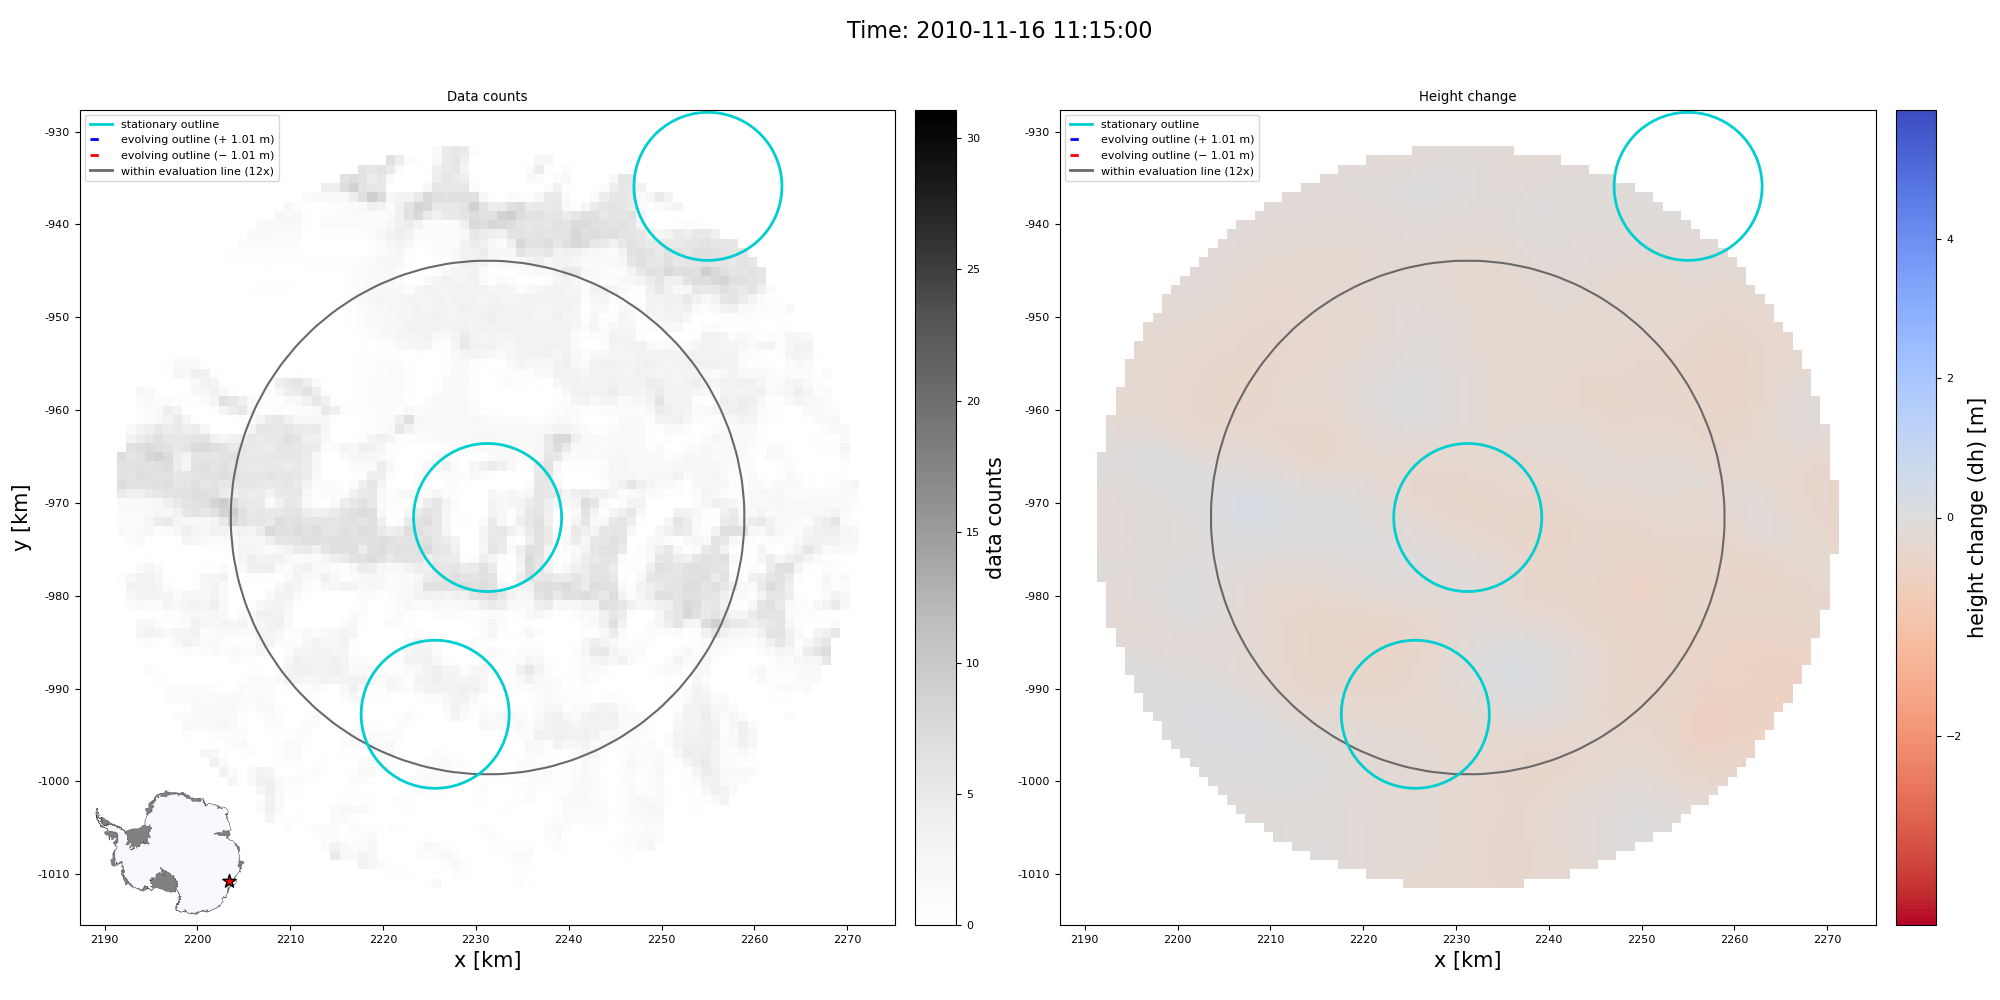

In [128]:
# Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# Evolving outlines saved as geojson file or a "no outlines" txt file saved for each lake
# in evolving_outlines directory

# Folder path
folder_path = 'output/lake_outlines/evolving_outlines'
os.makedirs(folder_path, exist_ok=True)

# Get initial list of lakes to process
remaining_lakes_1 = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)

# Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# Visualization mp4's saved to find_evolving_outlines directory

# First folder path to use to filter
folder_path = OUTPUT_DIR + '/find_evolving_outlines'

# Get list of lakes to reprocess
remaining_lakes_2 = filter_gdf_by_folder_contents(
    stationary_outlines_gdf, 
    folder_path,
    suffix_pattern=r'_\d+-idx_\d+\.\d+m-level_\d+x-within',
    file_extension='mp4'
)

# Secondary folder path to use to filter
folder_path = OUTPUT_DIR + '/levels'

# Get list of lakes to reprocess
remaining_lakes_2 = filter_gdf_by_folder_contents(
    remaining_lakes_2,
    folder_path,
    file_extension='txt'
)

# Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# Visualization png's saved to plot_evolving_outlines_time_series directory

# First folder path to use to filter
folder_path = OUTPUT_DIR + '/plot_evolving_outlines_time_series'

# Get list of lakes to reprocess
remaining_lakes_3 = filter_gdf_by_folder_contents(
    stationary_outlines_gdf, 
    folder_path,
    suffix_pattern=r'_\d+-idx_\d+\.\d+m-level_\d+x-within',
    file_extension='png'
)

# Secondary folder path to use to filter
folder_path = OUTPUT_DIR + '/levels'

# Get list of lakes to reprocess
remaining_lakes_3 = filter_gdf_by_folder_contents(
    remaining_lakes_3, 
    folder_path,
    file_extension='txt'
)

# Combine remaining_lakes gdf's
combined_remaining_lakes_gdf = pd.concat([remaining_lakes_1, remaining_lakes_2, remaining_lakes_3], ignore_index=True)

# Reprocess remaining lakes
if combined_remaining_lakes_gdf.empty:
    print("All lakes processed.")
    
else:
    total_lakes = len(combined_remaining_lakes_gdf)
    processed_lakes = 0
    
    for i in combined_remaining_lakes_gdf.index:
        remaining_count = total_lakes - processed_lakes
        print(f"{remaining_count} lakes remain.")
  
    try:
        for i in range(len(combined_remaining_lakes_gdf)):
    
            # Process the lake
            lake_gdf = combined_remaining_lakes_gdf.iloc[i:i+1]
            visualize_and_save_evolving_outlines(lake_gdf)

            # Increment processing counter
            processed_lakes += 1

            # Clear output of each index
            clear_output(wait=True)
            
    except Exception as e:
        print(f"Error processing lake at index {i}: {str(e)}")
            
    print("Processing complete.")

In [40]:
# # Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# # Evolving outlines saved as geojson file or a "no outlines" txt file saved for each lake
# # in evolving_outlines directory

# # Folder path
# folder_path = 'output/lake_outlines/evolving_outlines'
# os.makedirs(folder_path, exist_ok=True)

# # Get initial list of lakes to process
# remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)

# # # Optional: Run backwards through the lakes on a second server instance
# # remaining_lakes = remaining_lakes.iloc[::-1].reset_index(drop=True)

# if remaining_lakes.empty:
#     print("All lakes processed.")
# else:
#     for i in range(len(remaining_lakes)):
#         print(len(remaining_lakes), 'lakes remain.')

#         # Process the lake
#         lake_gdf = remaining_lakes.iloc[0:1]
#         visualize_and_save_evolving_outlines(lake_gdf)

#         # Recheck which lakes still need processing
#         remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)
#         if remaining_lakes.empty:
#             print("All lakes processed.")
#             break

All lakes processed.


In [112]:
# # Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# # Visualization mp4's saved to find_evolving_outlines directory

# # First folder path to use to filter
# folder_path = OUTPUT_DIR + '/find_evolving_outlines'

# # Get initial list of lakes to process
# remaining_lakes = filter_gdf_by_folder_contents(
#     stationary_outlines_gdf, 
#     folder_path,
#     suffix_pattern=r'_\d+-idx_\d+\.\d+m-level_\d+x-within',
#     file_extension='mp4'
# )

# # Secondary folder path to use to filter
# folder_path = OUTPUT_DIR + '/levels'

# # Get initial list of lakes to process
# remaining_lakes = filter_gdf_by_folder_contents(
#     remaining_lakes,
#     folder_path,
#     file_extension='txt'
# )

# # Optional: Run backwards through the lakes on a second server instance
# # remaining_lakes = remaining_lakes.iloc[::-1].reset_index(drop=True)

# if remaining_lakes.empty:
#     print("All lakes processed.")
# else:
#     for i in range(len(remaining_lakes)):
#         print(len(remaining_lakes), 'lakes remain.')

#         # Process the lake
#         lake_gdf = remaining_lakes.iloc[i:i+1]
#         visualize_and_save_evolving_outlines(lake_gdf)

#         if remaining_lakes.empty:
#             print("All lakes processed.")
#             break

1 lakes remain.
Visualizing outlines for Foundation_7
Parameters: row_index=0, within_area_multiple=16, level=0.18, doi(s)=doi:10.5067/ATLAS/ATL15.004


INFO:pyogrio._io:Created 1 records
INFO:pyogrio._io:Created 75 records


Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Foundation_7.geojson
Making video for Foundation_7
Parameters: row_index=0, within_area_multiple=16, level=0.18, doi(s)=doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Foundation_7_0-idx_0.18m-level_16x-within.mp4 created successfully.
Deleted 21 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Foundation_7
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Foundation_7
Creating evolving outlines time series plot for lake: Foundation_7
Parameters: row_index=0, within_area_multiple=16, level=0.18
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/Foundation_7_0-idx_0

In [54]:
# # Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# # Visualization png's saved to plot_evolving_outlines_time_series directory

# # Folder path to verify all evolving outlines time series plots were generated
# folder_path = OUTPUT_DIR + '/plot_evolving_outlines_time_series'

# # Get initial list of lakes to process
# remaining_lakes = filter_gdf_by_folder_contents(
#     stationary_outlines_gdf, 
#     folder_path,
#     suffix_pattern=r'_\d+-idx_\d+\.\d+m-level_\d+x-within',
#     file_extension='png'
# )

# # Folder path to verify all outlines were plotted in aggregate for each lake
# folder_path = OUTPUT_DIR + '/levels'

# # Get initial list of lakes to process
# remaining_lakes = filter_gdf_by_folder_contents(
#     remaining_lakes, 
#     folder_path,
#     file_extension='txt'
# )

# # Optional: Run backwards through the lakes on a second server instance
# # remaining_lakes = remaining_lakes.iloc[::-1].reset_index(drop=True)

# if remaining_lakes.empty:
#     print("All lakes processed.")
# else:
#     for i in range(len(remaining_lakes)):
        
#         # Process the lake
#         lake_gdf = remaining_lakes.iloc[i:i+1]
#         visualize_and_save_evolving_outlines(lake_gdf)

#         if remaining_lakes.empty:
#             print("All lakes processed.")
#             break

Visualizing outlines for Mac1
Parameters: row_index=0, within_area_multiple=9, level=0.3, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Mac1.geojson
Making video for Mac1
Parameters: row_index=0, within_area_multiple=9, level=0.3, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Mac1_0-idx_0.3m-level_9x-within.mp4 created successfully.
Deleted 55 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Mac1
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Mac1
Creating evolving outlines time series plot for lake: Mac1
Parameters: row_index=0, within_area_multiple=9, level=0.3
Successfully saved plot to

# Lake groups

From reviewing the evolving outlines, we observed lakes that have neighbor lake and appear to interact with that neighbor, so we analyze those lake groupings as lake systems where two or more lakes are analyzed together see if perhaps the lakes should be considered as one lake or remain as separate lakes. Additionally The upper Thwaites lakes are close neighbors we attempted to group them to see if a more optimal level could be obtained when analyzed simultaneously.

In [52]:
# Define lake groups
lake_groups = [
    ['Mac1', 'Mac2'],
    ['Site_B', 'Site_C'],
    ['Slessor_4', 'Slessor_5'],
    ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142'],
    ['Thw_142', 'Thw_170']
]

In [53]:
# # Reverse for processing backwards using a second server
# lake_groups.reverse()

# Process each group
for lake_group in lake_groups:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # First find search extents and levels for the group
    find_and_save_optimal_parameters(group_single_gdf, within_area_multiples=range(5, 16))
        
    # Then finalize the evolving outlines using these parameters
    visualize_and_save_evolving_outlines(group_single_gdf)

del lake_groups

Visualizing outlines for Thw_124_Thw_142
Parameters: row_index=0, within_area_multiple=5, level=0.61, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Thw_124_Thw_142.geojson
Making video for Thw_124_Thw_142
Parameters: row_index=0, within_area_multiple=5, level=0.61, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142_0-idx_0.61m-level_5x-within.mp4 created successfully.
Deleted 55 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Creating evolving outlines time series plot for lake: Thw_124_Thw_142
Param

After reviewing the results of the lake groups analysis, I found:
* Mac1_Mac2 have distinct activity but there is an interesting dh expression between the lakes during the CryoSat-2 era that may be indicative of lake migration; however, analyzing as a group does not add new information as the intereting feature was found over Mac2 in the individual lake analysis and the level found analyzing as a lake system (0.4 m) was higher than analyzing separately: Mac1 (0.30 m) and Mac2 (0.36 m).
* Site_B_Site_C have two dh espressions that both overlap with locations of the two lakes; it's unclear if either of the dh expressions belong to one of the lakes or the other because the two dh expressions are nearly centered between the two lakes with some lateral offset. This is an improvement from analyzing the two lakes separately where Site C had a lowest optimal level of 1.27 m and Site B had no evolving outlines found compared to analyzed as lake group had a lowest optimal level of 1.2 m.
* Slessor_4_Slessor_5 have unconvincing evidence of being one lake system: there is one time slice where there dh expression covering both lakes, 2019-07-02 to 2019-10-02, but several other time slices have dh expressions of opposite sign (similar to observed at Slessor_23 by Siegfried and Fricker, 2018).
* Thw_70_Thw_124_Thw_142_Thw_170 does not improve analysis from individual lakes because there is no overlapping activity and the level (1.37 m) is higher than two out of four of the lakes analyzed individually.
* Thw_124_Thw_142_Thw_170 has some potential as the there overlapping activity over the three lakes and a lower level (0.53 m) than two of the three lakes; however, there are many off-lake outlines identified, so we will plot the second most optimal level of this lake grouping.
* Thw_124_Thw_142 appears to have some potential in identifying overlapping outlines shared between these lakes; however, Thw_170 is included in the found outlines, so it makes sense to use that grouping instead.
* Thw_142_Thw_170 was not useful because of the high level (1.86 m) found to be most optimal for this grouping.

Based on this, we will delete the evolving outlines generated and saved to geojson files.

In [59]:
# Rename Site_B_Site_C to Site_BC to follow naming convention used for at past lake unions
# Lake_78 and Slessor_23
old_name = 'output/lake_outlines/evolving_outlines/' + 'Site_B_Site_C.geojson'
new_name = 'output/lake_outlines/evolving_outlines/' + 'Site_BC.geojson'

if os.path.exists(old_name):
    os.rename(old_name, new_name)
    print(f'Successfully renamed {old_name} to {new_name}')
else:
    print(f'File {old_name} does not exist')

Successfully renamed /home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output/lake_outlines/evolving_outlines/Site_B_Site_C.geojson to /home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output/lake_outlines/evolving_outlines/Site_BC.geojson


In [241]:
old_names = ['output/lake_outlines/evolving_outlines/Site_B_Site_C.geojson', 
             OUTPUT_DIR + '/levels/Site_B_Site_C.csv',
             OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/Site_B_Site_C.geojson']
new_names = ['output/lake_outlines/evolving_outlines/Site_BC.geojson',
            OUTPUT_DIR + '/levels/Site_BC.csv',
            OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/Site_BC.geojson']

In [243]:
# Iterate through both lists simultaneously
for old_name, new_name in zip(old_names, new_names):
    # Try to rename file
    if os.path.exists(old_name):
        os.rename(old_name, new_name)
        print(f'Successfully renamed {old_name} to {new_name}')
    else:
        print(f'File not found: {old_name}')

File not found: output/lake_outlines/evolving_outlines/Site_B_Site_C.geojson
File not found: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Site_B_Site_C.csv
File not found: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Site_B_Site_C.geojson


In [133]:
lakes_outputs_to_delete = [
    'Mac1_Mac2',
    'Site_B', 'Site_C',
    'Slessor_4_Slessor_5',
    'Thw_70_Thw_124_Thw_142_Thw_170',
    'Thw_142_Thw_170'
]

In [134]:
for filename in lakes_outputs_to_delete:
    dir = OUTPUT_DIR + '/levels/'
    file_path = os.path.join(dir, f"{filename}.csv")
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")

    dir = 'output/lake_outlines/evolving_outlines/'
    for ext in ('.geojson', '.txt'):
        file_path = os.path.join(dir, f"{filename}{ext}")
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        else:
            print(f"Not found: {file_path}")

del dir, lakes_outputs_to_delete

Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Mac1_Mac2.csv
Not found: output/lake_outlines/evolving_outlines/Mac1_Mac2.geojson
Not found: output/lake_outlines/evolving_outlines/Mac1_Mac2.txt
Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Site_B.csv
Not found: output/lake_outlines/evolving_outlines/Site_B.geojson
Not found: output/lake_outlines/evolving_outlines/Site_B.txt
Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Site_C.csv
Not found: output/lake_outlines/evolving_outlines/Site_C.geojson
Not found: output/lake_outlines/evolving_outlines/Site_C.txt
Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Slessor_4_Slessor_5.csv
Not found: output/lake_outlines/evolving_outlines/Slessor_4_Slessor_5.geojson
Not found: output/lake_outlines/evolving_outlines/Slessor_4_Slessor_5.txt
Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_ree

In [51]:
# Write no outlines txt file to two lakes that will be replaced by the combination lake
dir = 'output/lake_outlines/evolving_outlines/'

for lake in ['Site_B', 'Site_C']:
    write_no_outlines(dir + lake)

Next we address lakes that have evolving outlines that appear flawed because of the number of off-lake outlines that make it appear that the lowest level selected using the algorithm perhaps was too low. We address this by selecting the next most optimal level/within_area_multiple combination contained in the levels csv file for these lakes in the first row (instead of the default zeroth row).

In [67]:
# Define lake groups
lake_groups_analyze_row_1 = [
    ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142'],
]

In [68]:
for lake_group in lake_groups_analyze_row_1:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # Visualize second level stored in first row
    visualize_and_save_evolving_outlines(group_single_gdf, row_index=1)

del lake_groups_analyze_row_1

Preparing group geodataframe for lake group: ['Thw_124', 'Thw_142']
Group CryoSat-2 SARIn time period determined as: 2010.5-2018.75
Visualizing outlines for Thw_124_Thw_142
Parameters: row_index=1, within_area_multiple=6, level=0.66, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Thw_124_Thw_142.geojson
Making video for Thw_124_Thw_142
Parameters: row_index=1, within_area_multiple=6, level=0.66, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142_1-idx_0.66m-level_6x-within.mp4 created successfully.
Deleted 55 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reex

In [61]:
# Define lake groups
lake_groups_analyze_row_2 = [
    ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142']
]

In [62]:
for lake_group in lake_groups_analyze_row_2:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # Visualize second level stored in first row
    visualize_and_save_evolving_outlines(group_single_gdf, row_index=2)

del lake_groups_analyze_row_2

Preparing group geodataframe for lake group: ['Thw_124', 'Thw_142']
Group CryoSat-2 SARIn time period determined as: 2010.5-2018.75
Visualizing outlines for Thw_124_Thw_142
Parameters: row_index=2, within_area_multiple=12, level=0.79, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Thw_124_Thw_142.geojson
Making video for Thw_124_Thw_142
Parameters: row_index=2, within_area_multiple=12, level=0.79, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142_2-idx_0.79m-level_12x-within.mp4 created successfully.
Deleted 55 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_r

In [60]:
# Define lake groups
lake_groups_analyze_row_3 = [
    ['Thw_124', 'Thw_142', 'Thw_170'],
]

In [ ]:
for lake_group in lake_groups_analyze_row_3:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # Visualize second level stored in first row
    visualize_and_save_evolving_outlines(group_single_gdf, row_index=3)

del lake_groups_analyze_row_3

The various levels of Thw_124_Thw_142_Thw_170 did not provide better outlines than analyzing the lakes individually, but instead Thw_124_Thw_142 is able to capture the lobing activity of Thw_142 and more of Thw_124's activity at a lower level then when each lake is analyzed separately. However, their activity appears spatial distinct, so we will:

1) Use evolving outlines generated in the analysis of lake group, Thw_124_Thw_142, for the individual lake evolving outlines for each respective lake by separating them spatially.

2) We will delete the Thw_124_Thw_142_Thw_170 geojson file as it did not prove useful analyzing these three lakes together.

In [63]:
# Define paths
evolving_outlines_path = os.path.join('output/lake_outlines/evolving_outlines/Thw_124_Thw_142.geojson')
output_dir = os.path.join('output/lake_outlines/evolving_outlines')

# Read the evolving outlines
Thw_124_Thw_142_evolving_outlines_gdf = gpd.read_file(evolving_outlines_path)

# Get the stationary outlines for each lake
Thw_124_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_124']
Thw_142_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_142']

if Thw_124_gdf.empty or Thw_142_gdf.empty:
    raise ValueError(f"Could not find one or both lakes in stationary_outlines_gdf: {Thw_124_gdf['name']}, {Thw_142_gdf['name']}")

# Extract outlines that intersect with each lake
Thw_124_outlines, Thw_124_offlake_outlines = extract_intersecting_polygons_recursive(Thw_124_Thw_142_evolving_outlines_gdf, Thw_124_gdf.geometry.iloc[0])
Thw_142_outlines, Thw_142_offlake_outlines = extract_intersecting_polygons_recursive(Thw_124_Thw_142_evolving_outlines_gdf, Thw_142_gdf.geometry.iloc[0])

if Thw_124_outlines is not None and not Thw_124_outlines.empty:
    lake_name = 'Thw_124'
    Thw_124_outlines.to_file(
        os.path.join(output_dir, f"{lake_name}.geojson"),
        driver='GeoJSON'
    )
    print(f"Saved outlines for {lake_name}")

if Thw_142_outlines is not None and not Thw_142_outlines.empty:
    lake_name = 'Thw_142'
    Thw_142_outlines.to_file(
        os.path.join(output_dir, f"{lake_name}.geojson"),
        driver='GeoJSON'
    )
    print(f"Saved outlines for {lake_name}")

del evolving_outlines_path, output_dir

Saved outlines for Thw_124
Saved outlines for Thw_142


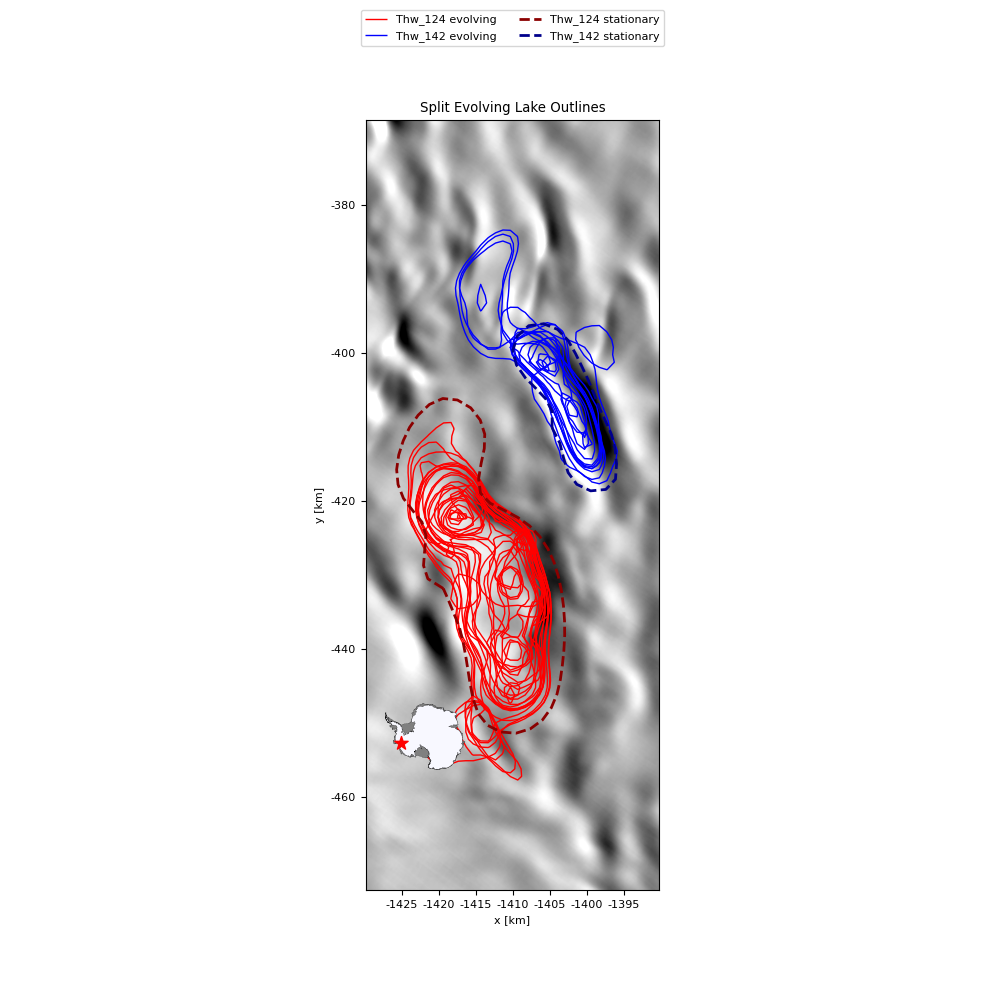

In [65]:
# Quick visualization to ensure outlines were split properly

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Get bounds for plot extent
total_bounds = Thw_124_Thw_142_evolving_outlines_gdf.total_bounds
x_min, y_min, x_max, y_max = total_bounds
buffer_factor = 0.2
x_buffer = (x_max - x_min) * buffer_factor
y_buffer = (y_max - y_min) * buffer_factor

# Plot MOA background
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
ax.imshow(moa_subset[0,:,:], cmap="gray", clim=[14000, 17000], 
         extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Plot the outlines
Thw_124_outlines_imported = gpd.read_file('output/lake_outlines/evolving_outlines/Thw_124.geojson')
Thw_142_outlines_imported = gpd.read_file('output/lake_outlines/evolving_outlines/Thw_142.geojson')
Thw_124_outlines_imported.boundary.plot(ax=ax, color='red', linewidth=1, label='Thw_124 evolving')
Thw_142_outlines_imported.boundary.plot(ax=ax, color='blue', linewidth=1, label='Thw_142 evolving')
    
# Plot stationary outlines
Thw_124_gdf.boundary.plot(ax=ax, color='darkred', linestyle='--', linewidth=2, label=f"{Thw_124_gdf['name'].iloc[0]} stationary")
Thw_142_gdf.boundary.plot(ax=ax, color='darkblue', linestyle='--', linewidth=2, label=f"{Thw_142_gdf['name'].iloc[0]} stationary")

# Add inset map
axins = ax.inset_axes([0.05, 0.05, 0.3, 0.3])
axins.set_aspect('equal')
moa_2014_coastline.plot(ax=axins, color='gray', edgecolor='k', linewidth=0.1)
moa_2014_groundingline.plot(ax=axins, color='ghostwhite', edgecolor='k', linewidth=0.1)
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2
axins.scatter(center_x, center_y, c='red', marker='*', s=100, zorder=5)
axins.axis('off')

# Format main plot
km_scale = 1e3
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
ax.set_title('Split Evolving Lake Outlines')

plt.show()

In [ ]:
# Plot evolving outlines time series for Thw_124 and Thw_142
Thw_124_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_124']
Thw_142_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_142']
plot_evolving_outlines_time_series(Thw_124_gdf, Thw_124_outlines, Thw_124_offlake_outlines)
plot_evolving_outlines_time_series(Thw_142_gdf, Thw_142_outlines, Thw_142_offlake_outlines)

In [67]:
del Thw_124_gdf, Thw_124_outlines, Thw_124_offlake_outlines
del Thw_142_gdf, Thw_142_outlines, Thw_142_offlake_outlines

In [140]:
lakes_outputs_to_delete = [
    'Thw_124_Thw_142_Thw_170',
    'Thw_124_Thw_142'
]

In [141]:
for filename in lakes_outputs_to_delete:
    dir = OUTPUT_DIR + '/levels/'
    file_path = os.path.join(dir, f"{filename}.csv")
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")

    dir = 'output/lake_outlines/evolving_outlines/'
    for ext in ('.geojson', '.txt'):
        file_path = os.path.join(dir, f"{filename}{ext}")
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        else:
            print(f"Not found: {file_path}")

del dir, lakes_outputs_to_delete

Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Thw_124_Thw_142_Thw_170.csv
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142_Thw_170.geojson
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142_Thw_170.txt
Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Thw_124_Thw_142.csv
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142.geojson
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142.txt


# Revise stationary_outlines_gdf

We will revise stationary_outlines_gdf to not have Site_B and Site_C as individual lakes, but instead have Site_BC as a combined lake group.

In [87]:
# Create copy of stationary_outlines_gdf
revised_stationary_outlines_gdf = stationary_outlines_gdf.copy(deep=True)

# Create combined Site_B_Site_C row
site_bc_row = prepare_group_gdf(revised_stationary_outlines_gdf, ['Site_B', 'Site_C'])

# Copy the citation to new Site_B_Site_C row if Sites B and C have the same citation
if (revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_B']['cite'].iloc[0] == 
    revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_C']['cite'].iloc[0]):
    site_bc_row['cite'] = (revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_B']
                          ['cite'].iloc[0])

# Drop individual lakes we are replacing
revised_stationary_outlines_gdf = revised_stationary_outlines_gdf.drop(
    revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'].isin(['Site_B', 'Site_C'])].index)

# Get evolving outlines and calculate area for Site_BC
try:
    lake_name = 'Site_BC'
    
    evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
    
    # Get evolving outlines union
    evolving_union_gs = find_evolving_union(site_bc_row.iloc[0], evolving_outlines_gdf, incl_stationary=False)
    
    if evolving_union_gs is not None:
        # Create temporary GeoDataFrame with the union
        temp_gdf = gpd.GeoDataFrame(
            index=[0], 
            crs='EPSG:3031', 
            geometry=[evolving_union_gs.iloc[0]])
        
        # Convert to 4326 for area calculation
        temp_gdf = temp_gdf.to_crs('4326')
        
        # Calculate area
        area = calculate_geodesic_area(temp_gdf['geometry'].iloc[0])
        
        # Update site_bc_row with calculated area and geometry
        site_bc_row['area (m^2)'] = area if area is not None else None
        site_bc_row['geometry'] = evolving_union_gs.iloc[0]


    # Rename to follow combination naming convention used for at passed lakes Lake_78 and Slessor_23
    site_bc_row['name'] = 'Site_BC'
        
except Exception as e:
    print(f"Error processing {lake_name}: {str(e)}")

# Ensure that new entry isn't already in inventory before adding to avoid duplicate entry
gdf_diff = site_bc_row[~site_bc_row['name'].isin(revised_stationary_outlines_gdf['name'])]

# Add the new row to stationary_outlines_gdf
revised_stationary_outlines_gdf = pd.concat([revised_stationary_outlines_gdf, gdf_diff], ignore_index=True)

# Sort the GeoDataFrame alphabetically by the 'name' column; reset the index after sorting
revised_stationary_outlines_gdf = revised_stationary_outlines_gdf.sort_values('name').reset_index(drop=True)

# Print processing confirmation
print(f"\nProcessed {lake_name}")

Preparing group geodataframe for lake group: ['Site_B', 'Site_C']
Group CryoSat-2 SARIn time period determined as: 2010.5-2018.75

Processed Site_BC


In [88]:
# View new row to ensure worked properly
revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_BC']

,name,area (m^2),cite,CS2_SARIn_time_period,geometry
125,Site_BC,3.357565e+08,"Wright & Siegert, 2012, Antarct. Sci., doi:10....",2010.5-2018.75,"MULTIPOLYGON (((2234907.921 -993821.589, 22347..."


In [89]:
# Export
revised_stationary_outlines_gdf.to_file(
    'output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson',
    driver='GeoJSON')

# Review evolving outlines

In your OUTPUT_DIR, navigate to the `plot_evolving_outlines_time_series` folder. There you will see the time series of evolving outlines plotted in aggregate for each lake. Some lakes will have very few evolving outlines that don't appear much different from the off-lake outlines generated. We additionally looking at the data_counts, dh, and evolving outline video for each time lake in the `find_evolving_outlines` folder for each lake.

In these cases we cannot be certain the evolving outlines are indicative of lake behavior or just background height anomalies. So we delete these evolving outlines geojson files and conclude there were no evolving outlines found for these lakes.

Some deletions are due to a lake's evolving outlines being those of a close neighbor, (e.g., Mac5 evolving outlines were those of Mac4).

In [83]:
lake_outlines_to_discard = [
    'Bindschadler_1',
    'Bindschadler_2',
    'Bindschadler_3',
    'Bindschadler_4',
    'Bindschadler_5',
    'Bindschadler_6',
    'Byrd_s1',
    'Byrd_s3',
    'Byrd_s5',
    'Byrd_s7',
    'Cook_E1',
    'David_s4',
    'David_s5',
    'EAP_3',
    'EAP_4',
    'EAP_5',
    'EAP_6',
    'EAP_7',
    'EAP_8',
    'Foundation_2',
    'Foundation_9',
    'Foundation_13',
    'Foundation_14',
    'Institute_W1',
    'JG_Combined_D2_b_E1',
    'JG_D1_a',
    'JG_D2_a',
    'JG_F1',
    'Kamb_1',
    'Kamb_2',
    'Kamb_3',
    'Kamb_9',
    'Kamb_11',
    'L1',
    'Lambert_1',
    'LennoxKing_1',
    'Mac5',
    'Mertz_1',
    'Raymond_1',
    'Rec5',
    'Slessor_5',
    'Slessor_6',
    'Slessor_7',
    'TL115',
    'TL122',
    'U1',
    'U2',
    'U3',
    'V1',
    'Vostok_1',
    'Whillans_8',
]

In [84]:
# Discard outlines by moving out of git repo and into non-git repo
discard_lake_outlines(
    lake_outlines_to_discard=lake_outlines_to_discard,
    source_dir='output/lake_outlines/evolving_outlines',
    dest_dir=OUTPUT_DIR + '/find_evolving_outlines/discarded_outlines'
)

{'Bindschadler_1': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Bindschadler_1.geojson'),
 'Bindschadler_2': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Bindschadler_2.geojson'),
 'Bindschadler_3': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Bindschadler_3.geojson'),
 'Bindschadler_4': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Bindschadler_4.geojson'),
 'Bindschadler_5': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Bindschadler_5.geojson'),
 'Bindschadler_6': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Bindschadler_6.geojson'),
 'Byrd_s1': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Byrd_s1.geojson'),
 'Byrd_s3': (False,
  'Source file does not exist: output/lake_outlines/evolving_outlines/Byrd_s3.geojson'),
 'Byrd_s5': (False,
  'Source file does not 

Similar to the lake groups, we try the next highest level for evolving outlines that appear flawed because of the number of off-lake outlines.

In [51]:
lakes_analyze_row_1 = [
    'ConwaySubglacialLake',
    'David_1',
    'EngelhardtSubglacialLake',
    'Foundation_N1',
    'Foundation_N3',
    'Institute_E2',
    'KT3',
    'Lake78',
    'M1',
    'Mac1',
    'Nimrod_2',
    'R1',
    'Rec1',
    'Rec2',
    'Slessor_4',
    'Slessor_23',
    'Thw_170',
    'UpperEngelhardtSubglacialLake',
    'Wilkes_2'
 ]

In [52]:
for lake in lakes_analyze_row_1:
    # Process the lake at the next highest level
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=1)

del lakes_analyze_row_1

Visualizing outlines for Wilkes_2
Parameters: row_index=1, within_area_multiple=10, level=0.3, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Wilkes_2.geojson
Making video for Wilkes_2
Parameters: row_index=1, within_area_multiple=10, level=0.3, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Wilkes_2_1-idx_0.3m-level_10x-within.mp4 created successfully.
Deleted 55 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Wilkes_2
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Wilkes_2
Creating evolving outlines time series plot for lake: Wilkes_2
Parameters: row_index=1, within_area_multiple=10, leve

We assess these results and find two smaller subsets: 1) outlines that can be deleted because they are too similar to background off-lake activity and 2) lakes that need to be visualized at the next level for the same reason.

In [51]:
lakes_analyze_row_2 = [
    'ConwaySubglacialLake',
    'David_1',
    'EngelhardtSubglacialLake',
    'Foundation_N1',
    'Mac1',
    'R1',
    'Slessor_4',
    'Slessor_23',
    'Thw_170',
    'UpperEngelhardtSubglacialLake',
    'Wilkes_2',
 ]

In [52]:
for lake in lakes_analyze_row_2:
    # Process the lake at all other levels
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=2)
    
del lakes_analyze_row_2

Visualizing outlines for Wilkes_2
Parameters: row_index=2, within_area_multiple=9, level=0.32, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Wilkes_2.geojson
Making video for Wilkes_2
Parameters: row_index=2, within_area_multiple=9, level=0.32, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Wilkes_2_2-idx_0.32m-level_9x-within.mp4 created successfully.
Deleted 55 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Wilkes_2
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Wilkes_2
Creating evolving outlines time series plot for lake: Wilkes_2
Parameters: row_index=2, within_area_multiple=9, level

In [60]:
lakes_analyze_row_3 = [
    'ConwaySubglacialLake',
    'Foundation_N1',
    'R1',
    'Slessor_4',
    'Thw_170'
]

In [61]:
for lake in lakes_analyze_row_3:
    # Process the lake at all other levels
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=3)
    
del lakes_analyze_row_3

Visualizing outlines for Slessor_4
Parameters: row_index=3, within_area_multiple=8, level=0.46, doi(s)=doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Slessor_4.geojson
Making video for Slessor_4
Parameters: row_index=3, within_area_multiple=8, level=0.46, doi(s)=doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Slessor_4_3-idx_0.46m-level_8x-within.mp4 created successfully.
Deleted 21 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Slessor_4
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Slessor_4
Creating evolving outlines time series plot for lake: Slessor_4
Parameters: row_index=3, within_area_multiple=8, level=0.46
Successfully saved plot to: /home/jovyan/1_

In [62]:
# Ensure there are no lakes with both geojson and txt file for evolving outlines
dir = OUTPUT_DIR + '/levels'
file_dict = defaultdict(list)

# Get all files in directory
for file_path in Path(dir).glob('**/*'):
    if file_path.is_file():
        # Get base name without extension
        base_name = file_path.stem
        # Add full filename to list under base name
        file_dict[base_name].append(file_path.name)

# Filter to only files with duplicates
duplicates = {k: v for k, v in file_dict.items() if len(v) > 1}
duplicates

{}

# Union outlines

In [188]:
# Create two new lakes geodataframe that are the union of 
# 1) the evolving outlines for each lake found to have evolving outlines
# 2) the evolving outlines and the stationary outline for lakes with activity (found to have evolving outlines)
# 3) the evolving outlines and the stationary outline for all lakes

# List all folders in target directory
folder_path = 'output/lake_outlines/evolving_outlines'

# Filter stationary_outlines_gdf to only include lakes that have evolving outlines found at them
stationary_outlines_gdf_evolving_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, folder_path, file_extension='geojson', exclude=False)

# Remove Site A, B, C, LSLM, and LSLC because their outlines were perfect circles created using their 
# point locations and approx. areas so should not be part of the union
exclude_list = ['Site_A', 'LowerConwaySubglacialLake', 'LowerMercerSubglacialLake']
stationary_outlines_gdf_evolving_lakes = stationary_outlines_gdf_evolving_lakes[~stationary_outlines_gdf_evolving_lakes['name'].isin(exclude_list)]
stationary_outlines_gdf_all_lakes = revised_stationary_outlines_gdf[~revised_stationary_outlines_gdf['name'].isin(exclude_list)]

# Create initial GDFs
evolving_outlines_union_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_evolving_lakes_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_all_lakes_gdf = stationary_outlines_gdf_all_lakes.copy(deep=True)

# Create initial GDFs
evolving_outlines_union_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_evolving_lakes_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_all_lakes_gdf = stationary_outlines_gdf_all_lakes.copy(deep=True)

# First process lakes with evolving outlines
for idx, row in stationary_outlines_gdf_evolving_lakes.iterrows():
    try:
        lake_ps = stationary_outlines_gdf_evolving_lakes.loc[idx]
        lake_name = lake_ps['name']
        
        try:
            evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
        except Exception as e:
            print(f"Skipping because evolving outlines geojson file not found for {lake_name}.")
            continue
            
        # Process evolving outlines
        evolving_union_gs = find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=False)
        evolving_stationary_outlines_union_gs = find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=True)

        if evolving_stationary_outlines_union_gs is None or evolving_union_gs is None:
            print(f"Skipping {lake_name}: Could not create union of outlines")
            continue
            
        try:
            # Store polygon from geoseries in geodataframes with CRS
            evolving_outlines_union_gdf_idx = gpd.GeoDataFrame(
                index=[0], crs='EPSG:3031', geometry=[evolving_union_gs.iloc[0]])
            evolving_stationary_outlines_union_evolving_lakes_gdf_idx = gpd.GeoDataFrame(
                index=[0], crs='EPSG:3031', geometry=[evolving_stationary_outlines_union_gs.iloc[0]])
            
            # Convert GeoDataFrames to EPSG:4326 CRS for geodesic area calculation
            evolving_outlines_union_gdf_idx = evolving_outlines_union_gdf_idx.to_crs('4326')
            evolving_stationary_outlines_union_evolving_lakes_gdf_idx = evolving_stationary_outlines_union_evolving_lakes_gdf_idx.to_crs('4326')
            
            # Update geometries in union GDFs using the correct index
            evolving_outlines_union_gdf.loc[idx, 'geometry'] = evolving_union_gs.iloc[0]
            evolving_stationary_outlines_union_evolving_lakes_gdf.loc[idx, 'geometry'] = evolving_stationary_outlines_union_gs.iloc[0]
            
            # Calculate and store areas
            area1 = calculate_geodesic_area(evolving_outlines_union_gdf_idx['geometry'].iloc[0])
            area2 = calculate_geodesic_area(evolving_stationary_outlines_union_evolving_lakes_gdf_idx['geometry'].iloc[0])
            
            if area1 is not None:
                evolving_outlines_union_gdf.loc[idx, 'area (m^2)'] = area1
            if area2 is not None:
                evolving_stationary_outlines_union_evolving_lakes_gdf.loc[idx, 'area (m^2)'] = area2
                
            # Update the all_lakes GDF for this lake
            mask = evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name
            if mask.any():
                evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'geometry'] = evolving_stationary_outlines_union_gs.iloc[0]
                evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'area (m^2)'] = area2
                
        except (IndexError, AttributeError) as e:
            print(f"Error processing geometries for {lake_name}: {str(e)}")
            continue
            
    except Exception as e:
        print(f"Unexpected error processing {lake_name}: {str(e)}")
        continue

# Then process remaining lakes for all_lakes GDF
remaining_lakes = set(stationary_outlines_gdf_all_lakes['name']) - set(stationary_outlines_gdf_evolving_lakes['name'])
for lake_name in remaining_lakes:
    try:
        # Get the lake's data using boolean indexing
        mask = evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name
        if not mask.any():
            print(f"Lake {lake_name} not found in all_lakes GDF")
            continue
            
        lake_geom = evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'geometry'].iloc[0]
        
        # Convert to 4326 for area calculation
        temp_gdf = gpd.GeoDataFrame(
            index=[0], crs='EPSG:3031', geometry=[lake_geom])
        temp_gdf = temp_gdf.to_crs('4326')
        area = calculate_geodesic_area(temp_gdf['geometry'].iloc[0])
        
        if area is not None:
            evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'area (m^2)'] = area
            
    except Exception as e:
        print(f"Error processing non-evolving lake {lake_name}: {str(e)}")
        continue

# Delete intermediary GDFs
del stationary_outlines_gdf_evolving_lakes, stationary_outlines_gdf_all_lakes

# Make additional_lakes_gdf for Site A, LSLM, and LSLC whose stationary outlines were removed 
# because they were approximations using point location and reported area instead of an actual outline
initial_lakes = ['Site_A', 'LowerConwaySubglacialLake', 'LowerEngelhardtSubglacialLake', 'LowerMercerSubglacialLake']
additional_lakes_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(initial_lakes)].copy()

# Add these additional lakes as rows to the union gdf's
for idx, row in additional_lakes_gdf.iterrows():
    try:
        lake_ps = additional_lakes_gdf.loc[idx]
        lake_name = lake_ps['name']
        
        try:
            evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
        except Exception as e:
            print(f"Skipping because evolving outlines geojson file not found for {lake_name}.")
            continue
           
        # Only get evolving outlines union since there's no stationary outline
        evolving_union_gs = find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=False)
        
        if evolving_union_gs is None:
            print(f"Skipping {lake_name}: Could not create union of outlines")
            continue
           
        try:
            # Create temporary GeoDataFrame with the union
            temp_gdf = gpd.GeoDataFrame(
                index=[0], 
                crs='EPSG:3031', 
                geometry=[evolving_union_gs.iloc[0]])
            
            # Convert to 4326 for area calculation
            temp_gdf = temp_gdf.to_crs('4326')
            
            # Calculate area
            area = calculate_geodesic_area(temp_gdf['geometry'].iloc[0])
            
            # Create new row from the current lake's data
            new_row_gdf = gpd.GeoDataFrame([{
                'name': lake_name,
                'area (m^2)': area if area is not None else None,
                'cite': lake_ps['cite'],
                'CS2_SARIn_time_period': lake_ps['CS2_SARIn_time_period'],
                'geometry': evolving_union_gs.iloc[0]
            }], crs='EPSG:3031')

            # For evolving_outlines_union_gdf
            if not lake_name in evolving_outlines_union_gdf['name'].values:
                evolving_outlines_union_gdf = pd.concat([
                    evolving_outlines_union_gdf, 
                    new_row_gdf
                ], ignore_index=True)
            else:
                print(f'Skipping {lake_name} for evolving_outlines_union_gdf - already exists')
                
            # Check if the lake is already in either GeoDataFrame and only append if it's new
            # For evolving_stationary_outlines_union_evolving_lakes_gdf
            if not lake_name in evolving_stationary_outlines_union_evolving_lakes_gdf['name'].values:
                evolving_stationary_outlines_union_evolving_lakes_gdf = pd.concat([
                    evolving_stationary_outlines_union_evolving_lakes_gdf, 
                    new_row_gdf], ignore_index=True)
            else:
                print(f'Skipping {lake_name} for evolving_stationary_outlines_union_evolving_lakes_gdf - already exists')

            # Check if the lake is already in either GeoDataFrame and only append if it's new
            # For evolving_stationary_outlines_union_evolving_lakes_gdf
            if not lake_name in evolving_stationary_outlines_union_all_lakes_gdf['name'].values:
                evolving_stationary_outlines_union_all_lakes_gdf = pd.concat([
                    evolving_stationary_outlines_union_all_lakes_gdf, 
                    new_row_gdf], ignore_index=True)
            else:
                print(f'Skipping {lake_name} for evolving_stationary_outlines_union_evolving_lakes_gdf - already exists')

           
        except (IndexError, AttributeError) as e:
            print(f"Error processing geometries for {lake_name}: {str(e)}")
            continue
           
    except Exception as e:
        print(f"Unexpected error processing {lake_name}: {str(e)}")
        continue

# Sort the GeoDataFrame alphabetically by the 'name' column; Reset the index after sorting; Reproject GeoDataFrame to EPSG:3031
evolving_outlines_union_gdf = evolving_outlines_union_gdf.sort_values('name').reset_index(drop=True).set_crs('3031')
evolving_stationary_outlines_union_evolving_lakes_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf.sort_values('name').reset_index(drop=True)
evolving_stationary_outlines_union_all_lakes_gdf = evolving_stationary_outlines_union_all_lakes_gdf.sort_values('name').reset_index(drop=True)

In [197]:
# Remove any rows where processing failed (geometry is None or invalid)
evolving_outlines_union_gdf = evolving_outlines_union_gdf[
    evolving_outlines_union_gdf.geometry.notna() & 
    evolving_outlines_union_gdf.geometry.is_valid]

evolving_stationary_outlines_union_evolving_lakes_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[
    evolving_stationary_outlines_union_evolving_lakes_gdf.geometry.notna() & 
    evolving_stationary_outlines_union_evolving_lakes_gdf.geometry.is_valid]

evolving_stationary_outlines_union_all_lakes_gdf = evolving_stationary_outlines_union_all_lakes_gdf[
    evolving_stationary_outlines_union_all_lakes_gdf.geometry.notna() & 
    evolving_stationary_outlines_union_all_lakes_gdf.geometry.is_valid]

In [198]:
# Print lengths of GDFs to ensure everything worked properly
print("Length of GDF's for all lakes:")
print(len(revised_stationary_outlines_gdf))
print(len(evolving_stationary_outlines_union_all_lakes_gdf))

# List all folders in target directory
folder_path = 'output/lake_outlines/evolving_outlines'

# Filter stationary_outlines_gdf to only include lakes that have evolving outlines found at them
stationary_outlines_gdf_evolving_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, folder_path, file_extension='geojson', exclude=False)
print("Length of GDF's for lakes that were found to have evolving outlines:")
print(len(stationary_outlines_gdf_evolving_lakes))
print(len(evolving_outlines_union_gdf))
print(len(evolving_stationary_outlines_union_evolving_lakes_gdf))

Length of GDF's for all lakes:
156
156
Length of GDF's for lakes that were found to have evolving outlines:
96
96
96


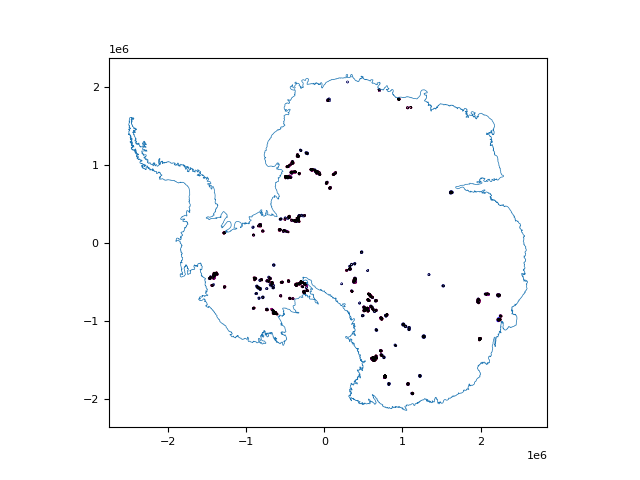

In [199]:
fig, ax = plt.subplots()
stationary_outlines_gdf.boundary.plot(ax=ax, color='blue')
evolving_outlines_union_gdf.boundary.plot(ax=ax, color='red')
evolving_stationary_outlines_union_evolving_lakes_gdf.boundary.plot(ax=ax, color='purple')
evolving_stationary_outlines_union_all_lakes_gdf.boundary.plot(ax=ax, color='k', linestyle='dashed')
Scripps_landice.boundary.plot(ax=ax, lw=0.5)
plt.show()

In [200]:
# Save GDF's to geojson
evolving_outlines_union_gdf.to_file('output/lake_outlines/evolving_outlines_union_gdf.geojson', driver='GeoJSON')
evolving_stationary_outlines_union_evolving_lakes_gdf.to_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson', driver='GeoJSON')
evolving_stationary_outlines_union_all_lakes_gdf.to_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson', driver='GeoJSON')

# Geometric calculations

In [92]:
# Load union datasets
evolving_outlines_union_gdf = gpd.read_file('output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

In [220]:
# Create output directories before processing any lakes
os.makedirs('output/geometric_calcs/compare_evolving_and_stationary_outlines', exist_ok=True)
os.makedirs('output/geometric_calcs/compare_evolving_union_and_stationary_outlines', exist_ok=True)
os.makedirs('output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_evolving_lakes', exist_ok=True)
os.makedirs('output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_all_lakes', exist_ok=True)

# Process geometric calculations on lakes
total_lakes = len(revised_stationary_outlines_gdf)
processed_lakes = 0

for i in revised_stationary_outlines_gdf.index:
    remaining_count = total_lakes - processed_lakes
    print(f"{remaining_count} lakes remain.")
    
    try:
        # Isolate lake from revised_stationary_outlines_gdf as geodataframe
        stationary_outline_gdf = revised_stationary_outlines_gdf.loc[[i]]
        
        if stationary_outline_gdf.empty:
            print("Skipping empty lake entry")
            continue

        # Print lake name 
        print(f"Processing lake: {stationary_outline_gdf['name'].iloc[0]}")
        
        # Prepare data sets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(stationary_outline_gdf, 30)
    
        # Check if lake has evolving outlines
        has_evolving_outlines = os.path.exists(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines', f"{stationary_outline_gdf['name'].iloc[0]}.geojson"))
        
        if has_evolving_outlines:
            # Calculate wetted area, dh, and dV for lakes with evolving outlines
            compare_evolving_and_stationary_outlines(stationary_outline_gdf=stationary_outline_gdf,
                dataset1=dataset1_masked, dataset2=dataset2_masked)
                
            # And for evolving outlines union vs. stationary outline
            compare_union_and_stationary_outlines(stationary_outline_gdf=stationary_outline_gdf,
               evolving_union_gdf=evolving_outlines_union_gdf, 
               dataset1=dataset1_masked, dataset2=dataset2_masked)
            
            # And for evolving+stationary outlines union (evolving lakes only)
            compare_union_and_stationary_outlines(stationary_outline_gdf=stationary_outline_gdf,
                evolving_union_gdf=evolving_stationary_outlines_union_evolving_lakes_gdf,
                dataset1=dataset1_masked, dataset2=dataset2_masked)
        
        # And for evolving+stationary outlines union (all lakes)
        compare_union_and_stationary_outlines(stationary_outline_gdf=stationary_outline_gdf,
            evolving_union_gdf=evolving_stationary_outlines_union_all_lakes_gdf,
            dataset1=dataset1_masked, dataset2=dataset2_masked)

        # Increment processing counter
        processed_lakes += 1

        # Clear output of each index
        clear_output(wait=True)
        
    except Exception as e:
        print(f"Error processing lake at index {i}: {str(e)}")
        continue
        
print("Processing complete.")

Processing complete.


In [245]:
# Get list of remaining lakes left to process based on

# 1) lakes that have evolving outlines
folder_path = 'output/lake_outlines/evolving_outlines'
remaining_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, 
    folder_path, file_extension='txt')

# 2) lakes that have already be processed
folder_path = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison'
os.makedirs(folder_path, exist_ok=True)
remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path)


if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        print(len(remaining_lakes), 'lake(s) remain.')
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[0:1]
        plot_evolving_and_stationary_comparison(lake_gdf)

        # Recheck which lakes still need processing
        remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path)

        # Clear output of each index
        clear_output(wait=True)

        if remaining_lakes.empty:
            print("All lakes processed.")
            break

All lakes processed.


# Final check that all lakes have been processed

In [248]:
# Ensure all lakes were reanalyzed
print('Analysis done on all previously identified lakes')
print(len(stationary_outlines_gdf), 'lakes reanalyzed')
print(len(revised_stationary_outlines_gdf), 
    'lakes analyzed in revised inventory due to Site_B and Site_C being combined into Site_BC')
dir = OUTPUT_DIR + '/levels'
print(len([f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]), 
      'lakes analyzed using find_and_save_optimal_paraters func')
dir = 'output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_all_lakes'

# Breakdown of lakes where evolving outlines were found vs. not
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.geojson')]),
      'lakes found to have evolving outlines')
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.txt')]),
      'lakes found to have no evolving outlines')
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.geojson')]) +
      len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.txt')]), 
      'sum of lakes found with and without evolving outlines')
print(len([f for f in os.listdir(dir) if f.endswith('.csv')]),
      'lakes analyzed using compare_union_and_stationary_outlines func for geometric calculations of all lakes')

# Analysis done on evolving lakes
print('\nAnalysis done only on previously identified lakes found to have evolving outlines')

# These directories will have four more csv files because of continental sums files for four sets of lakes
# so if this code is rerun after the 'Continental summations' section, the counts will be higher than expected
dir = 'output/geometric_calcs/compare_evolving_and_stationary_outlines'
print(len([f for f in os.listdir(dir) if f.endswith('.csv')]),
    'lakes analyzed using compare_evolving_and_stationary_outlines')
dir = 'output/geometric_calcs/compare_evolving_union_and_stationary_outlines'
print(len([f for f in os.listdir(dir) if f.endswith('.csv')]),
      'lakes analyzed using compare_union_and_stationary_outlines')
dir = 'output/geometric_calcs/compare_evolving_union_and_stationary_outlines'
print(len([f for f in os.listdir(dir) if f.endswith('.csv')]),
      'lakes analyzed using compare_evolving_stationary_union_and_stationary_outlines')

dir = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison'
print(len([f for f in os.listdir(dir) if f.endswith('.png')]),
      'lakes analyzed using plot_evolving_and_stationary_comparison')

Analysis done on all previously identified lakes
157 lakes reanalyzed
156 lakes analyzed in revised inventory due to Site_B and Site_C being combined into Site_BC
156 lakes analyzed using find_and_save_optimal_paraters func
96 lakes found to have evolving outlines
60 lakes found to have no evolving outlines
156 sum of lakes found with and without evolving outlines
156 lakes analyzed using compare_union_and_stationary_outlines func for geometric calculations of all lakes

Analysis done only on previously identified lakes found to have evolving outlines
96 lakes analyzed using compare_evolving_and_stationary_outlines
96 lakes analyzed using compare_union_and_stationary_outlines
96 lakes analyzed using compare_evolving_stationary_union_and_stationary_outlines
96 lakes analyzed using plot_evolving_and_stationary_comparison


# Continental summations

In [263]:
# List of comparison types
comparison_types = [
    'compare_evolving_and_stationary_outlines',
    'compare_evolving_union_and_stationary_outlines',
    'compare_evolving_stationary_union_and_stationary_outlines_evolving_lakes',
    'compare_evolving_stationary_union_and_stationary_outlines_all_lakes'
]

# Process each comparison type
for comparison_type in comparison_types:
    process_continental_sums(comparison_type)

# Fig. S1 (old)

In [53]:
# remaking fig
# -trellis plot (3x2)
# data_count panel (use example of lake at boundary of CS2 SARIn coverage)
# panel of pos and neg dh with contours created (and level listed) 
# -annotation or title that says repeated for all avail time steps
# -annotated with all 10 area multiple within boundary evaluation lines
# time series plot of evolving outlines

# Add something along the lines of code below to illustrate lake area/outline for evolving outline union boundary/area:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Lake area')
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Lake outline')

# wetted area, dh, dv with time step illustrated above denoted with vertical shaded region to indicate quarterly cycle (shaded color of time step

# Indicate satelite eras
# for idx in [1,2,3]:
    # # Plot vertical lines to indicate CS2 SARIn mode mask moving inland and ICESat-2 era start
    # ax[idx][0].axvline(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
    #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
    # ax[idx][0].axvline(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
    #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
    # Add a triangle to indicate an event on the x-axis
    # event_x = cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates']
    # ax[0][0].annotate('SARIn mode expands', xy=(event_x, -1), xytext=(event_x, -0.1),
    #         textcoords='data', arrowprops=dict(arrowstyle='<|-|>', color='red', mutation_scale=15))

# # Add text label near the vertical line
# ax[1][0].text(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
#         -15, 
#         'SARIn mode expands',
#         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)
# ax[1][0].text(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
#         -15, 
#         'ICESat-2 era begins',
#         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)

# Add off-lake, lake (no corr.) to dh plot to illustrate correction

In [55]:
# Load union datasets
evolving_outlines_union_gdf = gpd.read_file('output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

In [92]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})

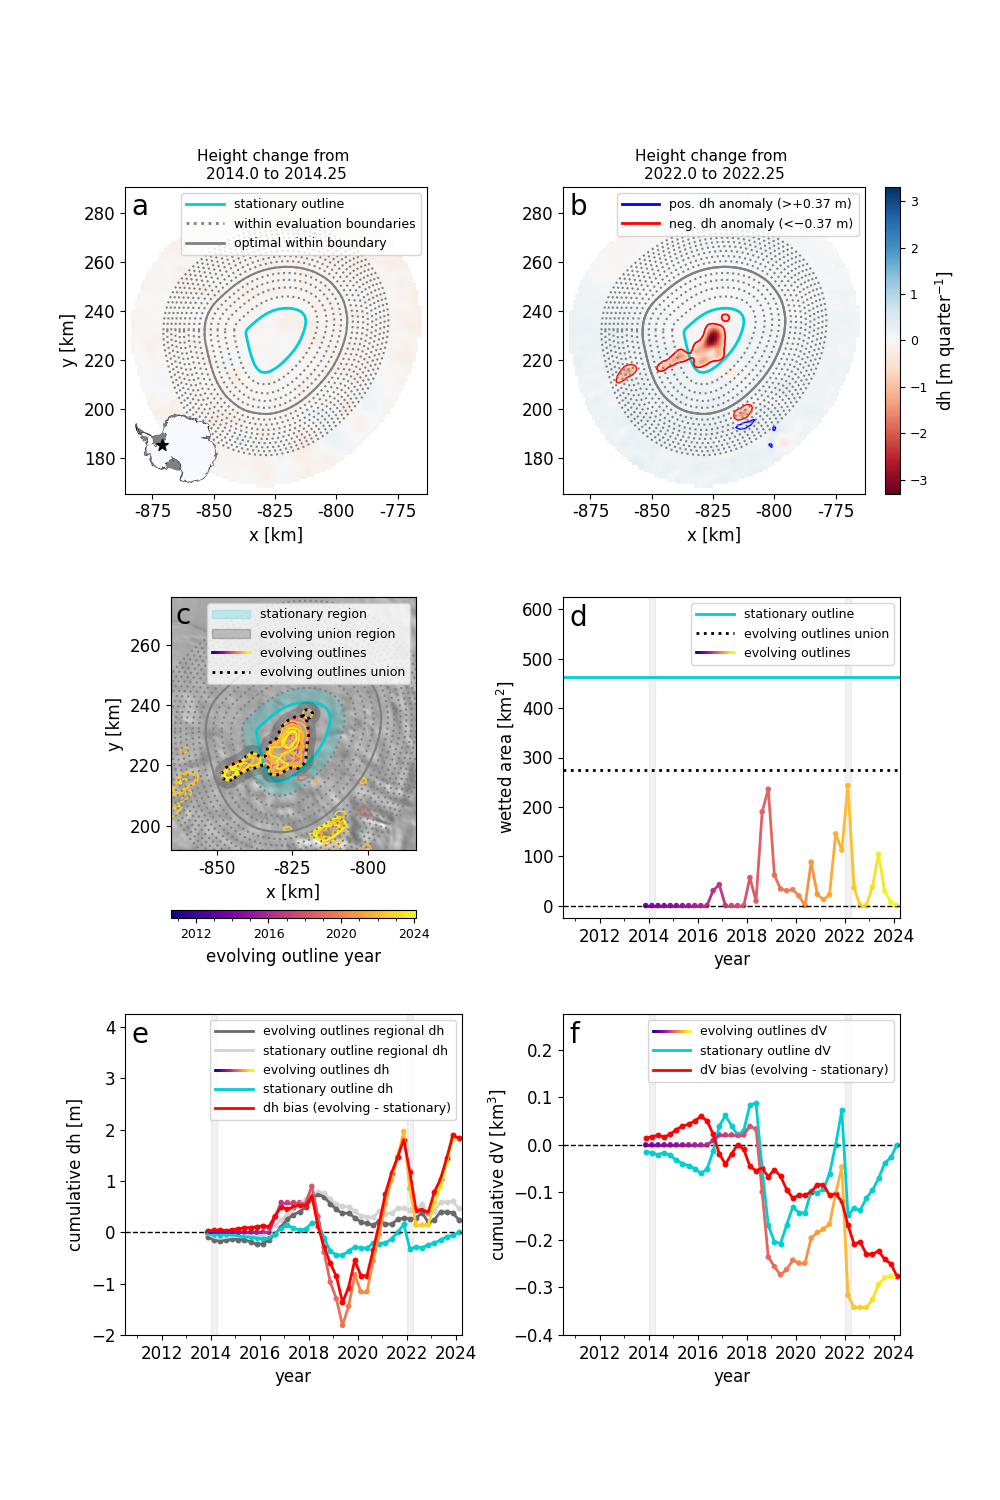

In [74]:
# Make output directory for figures
os.makedirs(OUTPUT_DIR + '/figures', exist_ok=True)

# Select lake
lake_gdf = revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Institute_E1']

# Define lake name and polygon
lake_name = lake_gdf['name'].iloc[0]
lake_poly = lake_gdf['geometry'].iloc[0]

# Load evolving outlines as geodataframe
try:
    onlake_outlines_gdf = gpd.read_file(os.path.join(
        os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
except fiona.errors.DriverError:
    print(f"File for {lake_name} not found.")

# Load off-lake evolving outlines as geodataframe
try:
    offlake_outlines_gdf = gpd.read_file(OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name))
except fiona.errors.DriverError:
    print(f"File for {lake_name} not found.")

# Ensure the result is a GeoDataFrame with proper geometry
evolving_outlines_gdf = gpd.GeoDataFrame(
    pd.concat([onlake_outlines_gdf, offlake_outlines_gdf], ignore_index=True),
    geometry='geometry', crs=onlake_outlines_gdf.crs)

# Load evolving outlines union
evolving_stationary_union_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]
evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]

# Load evolving outlines search parameters
row_index=evolving_outlines_gdf['row_index'][0]
within_area_multiple=evolving_outlines_gdf['within_area_multiple'][0]
level=evolving_outlines_gdf['level'][0]

# Attempt to open the geometric calculations CSV file
try:
    geom_calcs_df = pd.read_csv(os.path.join(
        os.getcwd(), 'output/geometric_calcs/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
except FileNotFoundError:
    print(f"CSV file for {lake_name} not found.")

# Convert of strings to datetime
geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

# Prepare datasets - using larger buffer for initial masking
dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

dataset1_dh = dataset1_masked['delta_h'].diff('time')
dataset2_dh = dataset2_masked['delta_h'].diff('time')

# Select time step to show for CryoSat-2 (CS2) and ICESat-2 (IS2) eras
CS2_i = 1  
IS2_i = 12

# Initialize empty lists for height anomalies
height_anom_pos = []
height_anom_neg = []

# Get height anomalies for CryoSat-2 timestep (i = 20)
if dataset1_masked is not None:
    if np.any(~np.isnan(dataset1_dh[CS2_i])):
        height_anom_pos.append(np.nanmax(dataset1_dh[CS2_i]))
        height_anom_neg.append(np.nanmin(dataset1_dh[CS2_i]))

# Get height anomalies for ICESat-2 timestep (i = 12)
if np.any(~np.isnan(dataset2_dh[IS2_i])):
    height_anom_pos.append(np.nanmax(dataset2_dh[IS2_i]))
    height_anom_neg.append(np.nanmin(dataset2_dh[IS2_i]))

# Find max height anomalies across both time slices
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
max_anom = max([max_height_anom_pos, abs(max_height_anom_neg)])
del height_anom_pos, height_anom_neg

# Create the diverging normalization for the colormap
divnorm = colors.TwoSlopeNorm(vmin=-max_anom, vcenter=0., vmax=max_anom)
del max_height_anom_pos, max_height_anom_neg

# Establish x_min, x_max, y_min, y_max
ROI_poly = area_multiple_buffer(lake_poly, 25)
x_min, y_min, x_max, y_max = ROI_poly.bounds
x_buffer, y_buffer = abs(x_max-x_min)*0.02, abs(y_max-y_min)*0.02

# Subsetting dataset
dataset1 = CS2_Smith2017
dataset2 = ATL15_dh

# Prepare datasets
dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

# Create figure with GridSpec
fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
axs = np.array([[fig.add_subplot(gs[i,j]) for j in range(2)] for i in range(3)])

# Set up colormap; Norm to time variable
cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))


# Panel - CryoSat-2 dh time step with evolving outlines and area multiple within evaluation lines  ---------------------------------------------

# Plot dh time step
CS2_timestep = dataset1_masked['time'][CS2_i].values

# Convert date_list to numpy array
cyc_start_dates_npa = np.array(cyc_start_dates, dtype='datetime64')

# Find matching cyc_dates index
CS2_cyc_dates_idx = np.where(cyc_start_dates_npa == CS2_timestep)[0][0]

img = axs[0,0].imshow(dataset1_dh[CS2_i], cmap='RdBu', norm=divnorm, 
                      origin='lower', extent=[x_min, x_max, y_min, y_max])

dt = mid_cyc_dates[CS2_cyc_dates_idx]
evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

if not evolving_outlines_gdf.empty:
    # Split into positive and negative dh values
    positive_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] > 0]
    negative_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] < 0]
    
    # Plot positive dh in blue
    if not positive_outlines.empty:
        positive_outlines.boundary.plot(ax=axs[0,0], color='blue', linewidth=1)
    
    # Plot negative dh in red
    if not negative_outlines.empty:
        negative_outlines.boundary.plot(ax=axs[0,0], color='red', linewidth=1)

# Plot inset map
axIns = axs[0,0].inset_axes([0.02, 0, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1)
axIns.axis('off')
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, color='k', s=75)

# Set a title for the axes
title_text = f'Height change from \n{date_to_quarter_year(mid_cyc_dates[CS2_cyc_dates_idx])} to {date_to_quarter_year(mid_cyc_dates[CS2_cyc_dates_idx+1])}'
axs[0,0].set_title(title_text, y=1)

# Create lines for legend
stationary_color = 'darkturquoise'
stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=2)
within_eval_lines = plt.Line2D([], [], color='gray', linestyle='dotted', linewidth=2)
optimal_within_eval_line = plt.Line2D([], [], color='gray', linestyle='solid', linewidth=2)

# Plot legend
legend = axs[0,0].legend([stationary_line, 
                          within_eval_lines,
                          optimal_within_eval_line], 
    ['stationary outline', 
     'within evaluation boundaries',
     'optimal within boundary'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - ICESat-2 dh time step with evolving outlines and area multiple within evaluation lines  ---------------------------------------------

# Plot dh time step
IS2_timestep = dataset2_masked['time'][IS2_i].values

# Convert date_list to numpy array
cyc_start_dates_npa = np.array(cyc_start_dates, dtype='datetime64')

# Find matching cyc_dates index
IS2_cyc_dates_idx = np.where(cyc_start_dates_npa == IS2_timestep)[0][0]

img = axs[0,1].imshow(dataset2_dh[IS2_i], cmap='RdBu', norm=divnorm, 
                      origin='lower', extent=[x_min, x_max, y_min, y_max])

dt = mid_cyc_dates[IS2_cyc_dates_idx]
evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

if not evolving_outlines_gdf.empty:
    # Split into positive and negative dh values
    positive_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] > 0]
    negative_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] < 0]
    
    # Plot positive dh in blue
    if not positive_outlines.empty:
        positive_outlines.boundary.plot(ax=axs[0,1], color='blue', linewidth=1)
    
    # Plot negative dh in red
    if not negative_outlines.empty:
        negative_outlines.boundary.plot(ax=axs[0,1], color='red', linewidth=1)

# Add colorbar space to both axes for consistent sizing
for ax in [axs[0,0], axs[0,1]]:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    if ax == axs[0,1]:  # Only add the actual colorbar to the second plot
        cb = fig.colorbar(img, cax=cax)
        cb.set_label('dh [m quarter$^{-1}$]')
    else:
        # Hide the empty axis for the first plot
        cax.set_visible(False)

# Set a title for the axes
title_text = f'Height change from \n{date_to_quarter_year(mid_cyc_dates[IS2_cyc_dates_idx])} to {date_to_quarter_year(mid_cyc_dates[IS2_cyc_dates_idx+1])}'
axs[0,1].set_title(title_text, y=1)

for ax in [axs[0,0], axs[0,1]]:
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

axs[0,1].sharey(axs[0,0])

# Create lines for legend
pos_dh_anom = plt.Line2D([], [], color='blue', linestyle='solid', linewidth=2)
neg_dh_anom = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

# Plot legend
legend = axs[0,1].legend([pos_dh_anom, 
                          neg_dh_anom], 
    [f'pos. dh anomaly (>+{level} m)', 
     f'neg. dh anomaly (<−{level} m)'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - Evolving outlines time series plot ---------------------------------------------

# Zoom in slightly to bounds of optimal within evaluation boundary
# Establish x_min, x_max, y_min, y_max
optimal_within_eval_poly = area_multiple_buffer(lake_poly, within_area_multiple)
x_min, y_min, x_max, y_max = optimal_within_eval_poly.bounds
x_buffer, y_buffer = abs(x_max-x_min)*0.2, abs(y_max-y_min)*0.1

# Plot MOA surface imagery
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
axs[1,0].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], 
          extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+(3*y_buffer)])

# # Set up colormap; Norm to time variable
# cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
# norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
#                      mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

# Plot evolving outlines
onlake_lines, offlake_lines = [], []
for i, dt in enumerate(mid_cyc_dates):
    x, y = 1, 1
    onlake_line, = axs[1,0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), linewidth=2)
    onlake_lines.append(onlake_line)
    offlake_line, = axs[1,0].plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[i]))), linewidth=2, alpha=0.2)
    offlake_lines.append(offlake_line)
    
    evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
    
    if not evolving_outlines_dt.empty:
        evolving_outlines_dt.boundary.plot(ax=axs[1,0], 
            color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), 
            linewidth=1)
    if not offlake_outlines_dt.empty:
        offlake_outlines_dt.boundary.plot(ax=axs[1,0], 
            color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), 
            linewidth=1, alpha=0.01)

# Plot evolving outlines unary union
evolving_union_gdf.boundary.plot(ax=axs[1,0], color='k', linestyle='dotted', linewidth=2)

# Create stationary region and evolving outlines region and plot
stationary_region = area_multiple_buffer(lake_poly, 2)
stationary_region = stationary_region.difference(lake_poly)
evolving_union_region = area_multiple_buffer(evolving_union_gdf['geometry'], 2)
evolving_union_region = evolving_union_region.difference(evolving_union_gdf['geometry'].iloc[0])
gpd.GeoDataFrame(geometry=[stationary_region], crs='3031').plot(ax=axs[1,0], color=stationary_color, linewidth=2, alpha=0.2)
gpd.GeoDataFrame(geometry=[evolving_union_region], crs='3031').plot(ax=axs[1,0], color='k', linewidth=2, alpha=0.2)

# Create colorbar
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='3%', pad=0.6)

# Define major and minor years
# major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
major_years = [2012, 2016, 2020, 2024]
minor_years = list(range(2011, 2025))
major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(major_dates)
cbar.set_ticklabels(major_years)
cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
cbar.set_label('evolving outline year', labelpad=5)

axs[1,0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+(3*y_buffer)))
    
# Emphasize zeroth row_index within evaluation line selected for particular lake
gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(ax=ax, linestyle='solid', color='gray')

# Plot legend
evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=2)
stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)

legend = axs[1,0].legend([stationary_region_patch,
                       evolving_union_region_patch,
                       tuple(onlake_lines),
                       # tuple(offlake_lines),
                       evolving_union_line], 
    ['stationary region',
     'evolving union region',
     'evolving outlines',
     # f'evolving outlines ({evolving_outlines_gdf.level[0]} m)',
     # 'off-lake evolving outlines', 
     'evolving outlines union'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')

# Panel - Wetted area ---------------------------------------------
    
# Plot horizontal zero line for reference
axs[1,1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outline and evolving outlines unary union areas
axs[1,1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
                 color=stationary_color, linestyle='solid', linewidth=2)
axs[1,1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
                 color='k', linestyle='dotted', linewidth=2)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
y = np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
lc.set_linewidth(2)
line = axs[1,1].add_collection(lc)
scatter = axs[1,1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Add legend
legend = axs[1,1].legend([stationary_line, 
                          evolving_union_line, 
                          tuple(onlake_lines)], 
    ['stationary outline',
     'evolving outlines union',
     'evolving outlines',],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
     loc='upper right')


# Panel - dh/dt -------------------------------------------------------

# Plot horizontal zero line for reference
axs[2,0].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outlines off-lake region dh
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']),
    color='lightgray', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']),
    color='lightgray', linestyle='solid', linewidth=2, s=5)

# Plot evolving outlines off-lake region dh
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), 
    color='dimgray', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']),
    color='dimgray', linestyle='solid', linewidth=2, s=5)

# Plot stationary outline time series
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), 
    color=stationary_color, linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']),
    color=stationary_color, linestyle='solid', linewidth=2, s=5)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
y = np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = axs[2,0].add_collection(lc)
scatter = axs[2,0].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot bias
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), 
    color='red', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), 
    color='red', linestyle='solid', linewidth=2, s=5)

# Add legend
evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
stationary_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
legend = axs[2,0].legend(
    [evolving_region,
     stationary_region,
     tuple(onlake_lines),
     stationary_line,  
     bias],
    ['evolving outlines regional dh',
     'stationary outline regional dh',
     'evolving outlines dh',
     'stationary outline dh', 
     'dh bias (evolving - stationary)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
     loc='upper right')


# Panel - dV/dt --------------------------------------------------

# Plot horizontal line at zero for reference
axs[2,1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outline time series
axs[2,1].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.divide(np.cumsum(geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
    color=stationary_color, linestyle='solid', linewidth=2)
axs[2,1].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.divide(np.cumsum(geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
    color=stationary_color, linestyle='solid', linewidth=2, s=5)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
y = np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = axs[2,1].add_collection(lc)
scatter = axs[2,1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot bias
axs[2,1].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)), 
    color='red', linestyle='solid', linewidth=2)
axs[2,1].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)), 
    color='red', linestyle='solid', linewidth=2, s=5)

# Add legend
legend = axs[2,1].legend([tuple(onlake_lines), stationary_line, bias],
    ['evolving outlines dV', 
     'stationary outline dV',
     'dV bias (evolving - stationary)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')

# Adjust y-axis limits to avoid legend/data overlap
axs[1,1].set_ylim(-25, 625)
axs[2,0].set_ylim(-2, 4.25)
axs[2,1].set_ylim(-0.4, 0.275)

# Get the dates for our timesteps shown in top panels
# For CryoSat-2
cs2_start_date = cyc_start_dates[CS2_cyc_dates_idx]
cs2_end_date = cyc_end_dates[CS2_cyc_dates_idx]

# For ICESat-2
is2_start_date = cyc_start_dates[IS2_cyc_dates_idx]
is2_end_date = cyc_end_dates[IS2_cyc_dates_idx]

# Add vertical spans to time series plots
for ax in [axs[1,1], axs[2,0], axs[2,1]]:
    # Add vertical spans for both timesteps
    ax.axvspan(mdates.date2num(cs2_start_date), 
                         mdates.date2num(cs2_end_date),
                         color='gray', alpha=0.1)
    
    ax.axvspan(mdates.date2num(is2_start_date),
                         mdates.date2num(is2_end_date),
                         color='gray', alpha=0.1)

# Plot elements common to more than one ax object
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        # Set common tick size for all axes
        axs[i,j].tick_params(axis='both', labelsize=12)
        
        # Add subplot labels (a, b, c, etc.)
        axs[i,j].text(0.02, 0.98, chr(97 + i*2 + j), transform=axs[i,j].transAxes, 
                     fontsize=20, va='top', ha='left')

        # Special formatting for map plots (top row and [1,0])
        if (i == 0) or (i == 1 and j == 0):
            # Set x and y labels for map plots
            axs[i,j].set_xlabel('x [km]')
            if j == 0:  # Only for first column
                axs[i,j].set_ylabel('y [km]')

            # Add map-specific elements
            revised_stationary_outlines_gdf.boundary.plot(ax=axs[i,j], 
                edgecolor=stationary_color, linestyle='solid', linewidth=2, zorder=0)
            
            # Convert meters to kilometers
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            axs[i,j].xaxis.set_major_formatter(ticks_x)
            axs[i,j].yaxis.set_major_formatter(ticks_y)

            # Add evaluation lines
            for within_area_multiple_i in range(2,16):
                gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple_i)).boundary.plot(
                    ax=axs[i,j], linestyle='dotted', color='gray')
            
            # Add emphasized evaluation line
            gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(
                ax=axs[i,j], linestyle='solid', color='gray')

        # Format time series plots
        else:
            axs[i,j].set_xlabel('year')
            
            # Set y labels for time series plots
            if j == 0:  # First column
                if i == 2:
                    axs[i,j].set_ylabel('cumulative dh [m]')
            elif j == 1:  # Second column
                if i == 1:
                    axs[i,j].set_ylabel('wetted area [km$^2$]')
                elif i == 2:
                    axs[i,j].set_ylabel('cumulative dV [km$^3$]')
            
            # Add date formatting for specific time series plots
            if (i == 1 and j == 1) or (i == 2):  # axs[1,1], axs[2,0], and axs[2,1]
                axs[i,j].xaxis.set_minor_locator(mdates.YearLocator(base=1))
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].set_xlim(cyc_start_dates[0], cyc_end_dates[-1])

# Save and close plot
# plt.savefig(OUTPUT_DIR + '/figures/Figure_S1.png',
#     dpi=300, bbox_inches='tight')
# plt.close()
plt.show()

# Fig. S1

In [93]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})

In [99]:
# Load stationary outlines gdf
revised_stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')

# Load union datasets
evolving_outlines_union_gdf = gpd.read_file('output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

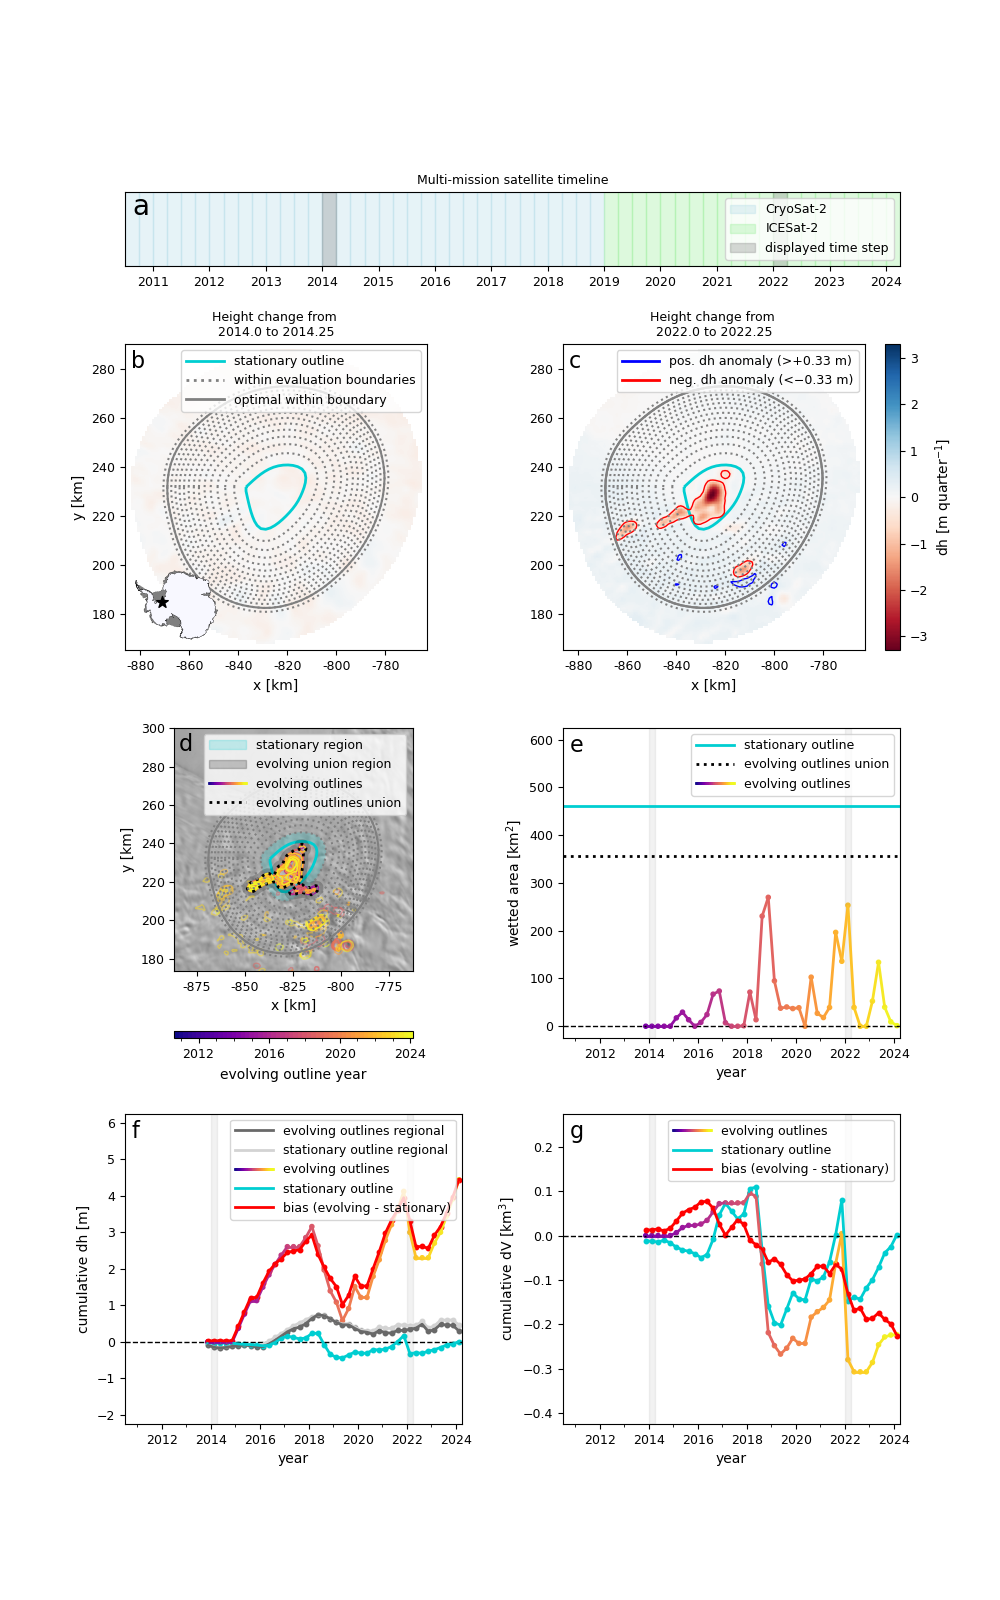

In [111]:
# Make output directory for figures
os.makedirs(OUTPUT_DIR + '/figures', exist_ok=True)

# Select lake
lake_gdf = revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Institute_E1']

# Define lake name and polygon
lake_name = lake_gdf['name'].iloc[0]
lake_poly = lake_gdf['geometry'].iloc[0]

# Load evolving outlines as geodataframe
try:
    onlake_outlines_gdf = gpd.read_file(os.path.join(
        os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
except fiona.errors.DriverError:
    print(f"File for {lake_name} not found.")

# Load off-lake evolving outlines as geodataframe
try:
    offlake_outlines_gdf = gpd.read_file(OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name))
except fiona.errors.DriverError:
    print(f"File for {lake_name} not found.")

# Ensure the result is a GeoDataFrame with proper geometry
evolving_outlines_gdf = gpd.GeoDataFrame(
    pd.concat([onlake_outlines_gdf, offlake_outlines_gdf], ignore_index=True),
    geometry='geometry', crs=onlake_outlines_gdf.crs)

# Load evolving outlines union
evolving_stationary_union_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]
evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]

# Load evolving outlines search parameters
row_index=evolving_outlines_gdf['row_index'][0]
within_area_multiple=evolving_outlines_gdf['within_area_multiple'][0]
level=evolving_outlines_gdf['level'][0]

# Attempt to open the geometric calculations CSV file
try:
    geom_calcs_df = pd.read_csv(os.path.join(
        os.getcwd(), 'output/geometric_calcs/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
except FileNotFoundError:
    print(f"CSV file for {lake_name} not found.")

# Convert of strings to datetime
geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

# Prepare datasets - using larger buffer for initial masking
dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

dataset1_dh = dataset1_masked['delta_h'].diff('time')
dataset2_dh = dataset2_masked['delta_h'].diff('time')

# Select time step to show for CryoSat-2 (CS2) and ICESat-2 (IS2) eras
CS2_i = 1  
IS2_i = 12

# Isolate dh time steps
CS2_timestep = dataset1_masked['time'][CS2_i].values
IS2_timestep = dataset2_masked['time'][IS2_i].values

# Convert date_list to numpy array
CS2_cyc_start_dates_npa = np.array(cyc_start_dates, dtype='datetime64')
IS2_cyc_start_dates_npa = np.array(cyc_start_dates, dtype='datetime64')

# Find matching cyc_dates index
CS2_cyc_dates_idx = np.where(CS2_cyc_start_dates_npa == CS2_timestep)[0][0]
IS2_cyc_dates_idx = np.where(IS2_cyc_start_dates_npa == IS2_timestep)[0][0]

# Initialize empty lists for height anomalies
height_anom_pos = []
height_anom_neg = []

# Get height anomalies for CryoSat-2 timestep (i = 20)
if dataset1_masked is not None:
    if np.any(~np.isnan(dataset1_dh[CS2_i])):
        height_anom_pos.append(np.nanmax(dataset1_dh[CS2_i]))
        height_anom_neg.append(np.nanmin(dataset1_dh[CS2_i]))

# Get height anomalies for ICESat-2 timestep (i = 12)
if np.any(~np.isnan(dataset2_dh[IS2_i])):
    height_anom_pos.append(np.nanmax(dataset2_dh[IS2_i]))
    height_anom_neg.append(np.nanmin(dataset2_dh[IS2_i]))

# Find max height anomalies across both time slices
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
max_anom = max([max_height_anom_pos, abs(max_height_anom_neg)])
del height_anom_pos, height_anom_neg

# Create the diverging normalization for the colormap
divnorm = colors.TwoSlopeNorm(vmin=-max_anom, vcenter=0., vmax=max_anom)
del max_height_anom_pos, max_height_anom_neg

# Establish x_min, x_max, y_min, y_max
ROI_poly = area_multiple_buffer(lake_poly, 25)
x_min, y_min, x_max, y_max = ROI_poly.bounds
x_buffer, y_buffer = abs(x_max-x_min)*0.02, abs(y_max-y_min)*0.02

# Subsetting dataset
dataset1 = CS2_Smith2017
dataset2 = ATL15_dh

# Prepare datasets
dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

# Create figure with GridSpec - modified to include timeline panel
fig = plt.figure(figsize=(10,16))  # Increased height to accommodate new panel
gs = fig.add_gridspec(4, 2, height_ratios=[0.24, 1, 1, 1], hspace=0.3, wspace=0.3)

# Create remaining axes array excluding timeline row
axs = np.array([[fig.add_subplot(gs[i,j]) for j in range(2)] for i in range(1,4)])


# Panel - Satellite era timeline

# Add timeline panel spanning both columns
timeline_ax = fig.add_subplot(gs[0, :])

# Create timeline visualization
timeline_ax.set_xlim(cyc_start_dates[0], cyc_end_dates[-1])
timeline_ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
timeline_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot colored bars for different satellite eras
for i, date in enumerate(cyc_dates['mid_cyc_dates']):
    dataset = cyc_dates['dataset'][i]
    color = 'lightblue' if dataset == 'CS2_Smith2017' else 'lightgreen'
    label = 'CryoSat-2' if dataset == 'CS2_Smith2017' else 'ICESat-2'
    
    if i == 0:  # Only add label for first occurrence of each dataset
        timeline_ax.axvspan(cyc_dates['cyc_start_dates'][i], cyc_dates['cyc_end_dates'][i], 
                          color=color, alpha=0.3, label=label)
    else:
        # Check if dataset changed from previous
        if cyc_dates['dataset'][i] != cyc_dates['dataset'][i-1]:
            timeline_ax.axvspan(cyc_dates['cyc_start_dates'][i], cyc_dates['cyc_end_dates'][i], 
                              color=color, alpha=0.3, label=label)
        else:
            timeline_ax.axvspan(cyc_dates['cyc_start_dates'][i], cyc_dates['cyc_end_dates'][i], 
                              color=color, alpha=0.3)

# Get the dates for our timesteps shown in top panels
# For CryoSat-2
cs2_start_date = cyc_start_dates[CS2_cyc_dates_idx]
cs2_end_date = cyc_end_dates[CS2_cyc_dates_idx]

# For ICESat-2
is2_start_date = cyc_start_dates[IS2_cyc_dates_idx]
is2_end_date = cyc_end_dates[IS2_cyc_dates_idx]

# Add vertical spans for the timesteps shown in top panels
# For CryoSat-2
timeline_ax.axvspan(mdates.date2num(cs2_start_date), 
                              mdates.date2num(cs2_end_date),
                              color='gray', alpha=0.3)

# For ICESat-2
timeline_ax.axvspan(mdates.date2num(is2_start_date),
                              mdates.date2num(is2_end_date),
                              color='gray', alpha=0.3)
# Create patches for legend
cs2_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='CryoSat-2')
is2_patch = mpatches.Patch(color='lightgreen', alpha=0.3, label='ICESat-2')
timestep_patch = mpatches.Patch(color='gray', alpha=0.3, label='displayed time step')

# Add legend with all patches
timeline_ax.legend(handles=[cs2_patch, is2_patch, timestep_patch], 
                  loc='upper right')

# Customize timeline appearance
# timeline_ax.legend(loc='upper right')
timeline_ax.set_title('Multi-mission satellite timeline')

# Remove y-axis ticks and labels
timeline_ax.set_yticks([])


# Panel - CryoSat-2 dh time step with evolving outlines and area multiple within evaluation lines

# Plot dh time step
img = axs[0,0].imshow(dataset1_dh[CS2_i], cmap='RdBu', norm=divnorm, 
                      origin='lower', extent=[x_min, x_max, y_min, y_max])

dt = mid_cyc_dates[CS2_cyc_dates_idx]
evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

if not evolving_outlines_gdf.empty:
    # Split into positive and negative dh values
    positive_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] > 0]
    negative_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] < 0]
    
    # Plot positive dh in blue
    if not positive_outlines.empty:
        positive_outlines.boundary.plot(ax=axs[0,0], color='blue', linewidth=1)
    
    # Plot negative dh in red
    if not negative_outlines.empty:
        negative_outlines.boundary.plot(ax=axs[0,0], color='red', linewidth=1)

# Plot inset map
axIns = axs[0,0].inset_axes([0.02, 0, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1)
axIns.axis('off')
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, color='k', s=75)

# Set a title for the axes
title_text = f'Height change from \n{date_to_quarter_year(mid_cyc_dates[CS2_cyc_dates_idx])} to {date_to_quarter_year(mid_cyc_dates[CS2_cyc_dates_idx+1])}'
axs[0,0].set_title(title_text, y=1)

# Create lines for legend
stationary_color = 'darkturquoise'
stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=2)
within_eval_lines = plt.Line2D([], [], color='gray', linestyle='dotted', linewidth=2)
optimal_within_eval_line = plt.Line2D([], [], color='gray', linestyle='solid', linewidth=2)

# Plot legend
legend = axs[0,0].legend([stationary_line, 
                          within_eval_lines,
                          optimal_within_eval_line], 
    ['stationary outline', 
     'within evaluation boundaries',
     'optimal within boundary'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - ICESat-2 dh time step with evolving outlines and area multiple within evaluation lines  

# Plot dh time step
img = axs[0,1].imshow(dataset2_dh[IS2_i], cmap='RdBu', norm=divnorm, 
                      origin='lower', extent=[x_min, x_max, y_min, y_max])

dt = mid_cyc_dates[IS2_cyc_dates_idx]
evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

if not evolving_outlines_gdf.empty:
    # Split into positive and negative dh values
    positive_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] > 0]
    negative_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] < 0]
    
    # Plot positive dh in blue
    if not positive_outlines.empty:
        positive_outlines.boundary.plot(ax=axs[0,1], color='blue', linewidth=1)
    
    # Plot negative dh in red
    if not negative_outlines.empty:
        negative_outlines.boundary.plot(ax=axs[0,1], color='red', linewidth=1)

# Add colorbar space to both axes for consistent sizing
for ax in [axs[0,0], axs[0,1]]:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    if ax == axs[0,1]:  # Only add the actual colorbar to the second plot
        cb = fig.colorbar(img, cax=cax)
        cb.set_label('dh [m quarter$^{-1}$]')
    else:
        # Hide the empty axis for the first plot
        cax.set_visible(False)

# Set a title for the axes
title_text = f'Height change from \n{date_to_quarter_year(mid_cyc_dates[IS2_cyc_dates_idx])} to {date_to_quarter_year(mid_cyc_dates[IS2_cyc_dates_idx+1])}'
axs[0,1].set_title(title_text, y=1)

for ax in [axs[0,0], axs[0,1]]:
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

axs[0,1].sharey(axs[0,0])

# Create lines for legend
pos_dh_anom = plt.Line2D([], [], color='blue', linestyle='solid', linewidth=2)
neg_dh_anom = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

# Plot legend
legend = axs[0,1].legend([pos_dh_anom, 
                          neg_dh_anom], 
    [f'pos. dh anomaly (>+{level} m)', 
     f'neg. dh anomaly (<−{level} m)'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - Evolving outlines time series plot ---------------------------------------------

# Set up colormap
cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

# Zoom in slightly to bounds of optimal within evaluation boundary
# Establish x_min, x_max, y_min, y_max
optimal_within_eval_poly = area_multiple_buffer(lake_poly, within_area_multiple)
x_min, y_min, x_max, y_max = optimal_within_eval_poly.bounds
x_buffer, y_buffer = abs(x_max-x_min)*0.2, abs(y_max-y_min)*0.1

# Plot MOA surface imagery
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
axs[1,0].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], 
          extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+(3*y_buffer)])

# Plot evolving outlines
onlake_lines, offlake_lines = [], []
for i, dt in enumerate(mid_cyc_dates):
    x, y = 1, 1
    onlake_line, = axs[1,0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), linewidth=2)
    onlake_lines.append(onlake_line)
    offlake_line, = axs[1,0].plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[i]))), linewidth=2, alpha=0.2)
    offlake_lines.append(offlake_line)
    
    onlake_outlines_dt = onlake_outlines_gdf[onlake_outlines_gdf['midcyc_datetime'] == dt]
    offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
    
    if not onlake_outlines_dt.empty:
        onlake_outlines_dt.boundary.plot(ax=axs[1,0], 
            color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), 
            linewidth=1)
    if not offlake_outlines_dt.empty:
        offlake_outlines_dt.boundary.plot(ax=axs[1,0], 
            color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), 
            linewidth=1, alpha=0.5)

# Plot evolving outlines unary union
evolving_union_gdf.boundary.plot(ax=axs[1,0], color='k', linestyle='dotted', linewidth=2)

# Create stationary region and evolving outlines region and plot
stationary_region = area_multiple_buffer(lake_poly, 2)
stationary_region = stationary_region.difference(lake_poly)
evolving_union_region = area_multiple_buffer(evolving_union_gdf['geometry'], 2)
evolving_union_region = evolving_union_region.difference(evolving_union_gdf['geometry'].iloc[0])
gpd.GeoDataFrame(geometry=[stationary_region], crs='3031').plot(ax=axs[1,0], color=stationary_color, linewidth=2, alpha=0.2)
gpd.GeoDataFrame(geometry=[evolving_union_region], crs='3031').plot(ax=axs[1,0], color='k', linewidth=2, alpha=0.2)

# Create colorbar
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='3%', pad=0.6)

# Define major and minor years
# major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
major_years = [2012, 2016, 2020, 2024]
minor_years = list(range(2011, 2025))
major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(major_dates)
cbar.set_ticklabels(major_years)
cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
cbar.set_label('evolving outline year', labelpad=5)

axs[1,0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+(3*y_buffer)))
    
# Emphasize zeroth row_index within evaluation line selected for particular lake
gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(ax=ax, linestyle='solid', color='gray')

# Plot legend
evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=2)
stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)

legend = axs[1,0].legend([stationary_region_patch,
                       evolving_union_region_patch,
                       tuple(onlake_lines),
                       # tuple(offlake_lines),
                       evolving_union_line], 
    ['stationary region',
     'evolving union region',
     'evolving outlines',
     # f'evolving outlines ({evolving_outlines_gdf.level[0]} m)',
     # 'off-lake evolving outlines', 
     'evolving outlines union'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - Wetted area ---------------------------------------------
    
# Plot horizontal zero line for reference
axs[1,1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outline and evolving outlines unary union areas
axs[1,1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
                 color=stationary_color, linestyle='solid', linewidth=2)
axs[1,1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
                 color='k', linestyle='dotted', linewidth=2)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
y = np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
lc.set_linewidth(2)
line = axs[1,1].add_collection(lc)
scatter = axs[1,1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Add legend
legend = axs[1,1].legend([stationary_line, 
                          evolving_union_line, 
                          tuple(onlake_lines)], 
    ['stationary outline',
     'evolving outlines union',
     'evolving outlines',],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
     loc='upper right')


# Panel - dh/dt -------------------------------------------------------

# Plot horizontal zero line for reference
axs[2,0].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outlines off-lake region dh
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']),
    color='lightgray', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']),
    color='lightgray', linestyle='solid', linewidth=2, s=5)

# Plot evolving outlines off-lake region dh
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), 
    color='dimgray', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']),
    color='dimgray', linestyle='solid', linewidth=2, s=5)

# Plot stationary outline time series
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), 
    color=stationary_color, linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']),
    color=stationary_color, linestyle='solid', linewidth=2, s=5)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
y = np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = axs[2,0].add_collection(lc)
scatter = axs[2,0].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot bias
axs[2,0].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), 
    color='red', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), 
    color='red', linestyle='solid', linewidth=2, s=5)

# Add legend
evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
stationary_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
legend = axs[2,0].legend(
    [evolving_region,
     stationary_region,
     tuple(onlake_lines),
     stationary_line,  
     bias],
    ['evolving outlines regional',
     'stationary outline regional',
     'evolving outlines',
     'stationary outline', 
     'bias (evolving - stationary)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
     loc='upper right')


# Panel - dV/dt --------------------------------------------------

# Plot horizontal line at zero for reference
axs[2,1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outline time series
axs[2,1].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.divide(np.cumsum(geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
    color=stationary_color, linestyle='solid', linewidth=2)
axs[2,1].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
    np.divide(np.cumsum(geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
    color=stationary_color, linestyle='solid', linewidth=2, s=5)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(geom_calcs_df['midcyc_datetime'])
y = np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))

# Create LineCollection from points/segments to plot multi-colored line for evolving outlines time series
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = axs[2,1].add_collection(lc)
scatter = axs[2,1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot bias
axs[2,1].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)), 
    color='red', linestyle='solid', linewidth=2)
axs[2,1].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']),
    np.cumsum(np.divide(geom_calcs_df['bias_dV_corr (m^3)'], 1e9)), 
    color='red', linestyle='solid', linewidth=2, s=5)

# Add legend
legend = axs[2,1].legend([tuple(onlake_lines), stationary_line, bias],
    ['evolving outlines', 
     'stationary outline',
     'bias (evolving - stationary)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')

# Adjust y-axis limits to avoid legend/data overlap
axs[1,1].set_ylim(-25, 625)
axs[2,0].set_ylim(-2.25, 6.25)
axs[2,1].set_ylim(-0.425, 0.275)

# Get the dates for our timesteps shown in top panels
# For CryoSat-2
cs2_start_date = cyc_start_dates[CS2_cyc_dates_idx]
cs2_end_date = cyc_end_dates[CS2_cyc_dates_idx]

# For ICESat-2
is2_start_date = cyc_start_dates[IS2_cyc_dates_idx]
is2_end_date = cyc_end_dates[IS2_cyc_dates_idx]

# Add vertical spans to time series plots
for ax in [axs[1,1], axs[2,0], axs[2,1]]:
    # Add vertical spans for both timesteps
    ax.axvspan(mdates.date2num(cs2_start_date), 
                         mdates.date2num(cs2_end_date),
                         color='gray', alpha=0.1)
    
    ax.axvspan(mdates.date2num(is2_start_date),
                         mdates.date2num(is2_end_date),
                         color='gray', alpha=0.1)

# Label the timeline panel
timeline_ax.text(0.01, 0.98, 'a', transform=timeline_ax.transAxes, 
                fontsize=20, va='top', ha='left')

# Plot elements common to more than one ax object
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        # Set common tick size for all axes
        axs[i,j].tick_params(axis='both')
        
        # Add subplot labels (a, b, c, etc.)
        axs[i,j].text(0.02, 0.98, chr(97 + i*2 + j + 1), transform=axs[i,j].transAxes, 
                     fontsize=16, va='top', ha='left')

        # Special formatting for map plots (top row and [1,0])
        if (i == 0) or (i == 1 and j == 0):
            # Set x and y labels for map plots
            axs[i,j].set_xlabel('x [km]')
            if j == 0:  # Only for first column
                axs[i,j].set_ylabel('y [km]')

            # Add map-specific elements
            revised_stationary_outlines_gdf.boundary.plot(ax=axs[i,j], 
                edgecolor=stationary_color, linestyle='solid', linewidth=2, zorder=0)
            
            # Convert meters to kilometers
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            axs[i,j].xaxis.set_major_formatter(ticks_x)
            axs[i,j].yaxis.set_major_formatter(ticks_y)

            # Add evaluation lines
            for within_area_multiple_i in range(2,16):
                gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple_i)).boundary.plot(
                    ax=axs[i,j], linestyle='dotted', color='gray')
            
            # Add emphasized evaluation line
            gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(
                ax=axs[i,j], linestyle='solid', color='gray')

        # Format time series plots
        else:
            axs[i,j].set_xlabel('year')
            
            # Set y labels for time series plots
            if j == 0:  # First column
                if i == 2:
                    axs[i,j].set_ylabel('cumulative dh [m]')
            elif j == 1:  # Second column
                if i == 1:
                    axs[i,j].set_ylabel('wetted area [km$^2$]')
                elif i == 2:
                    axs[i,j].set_ylabel('cumulative dV [km$^3$]')
            
            # Add date formatting for specific time series plots
            if (i == 1 and j == 1) or (i == 2):  # axs[1,1], axs[2,0], and axs[2,1]
                axs[i,j].xaxis.set_minor_locator(mdates.YearLocator(base=1))
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].set_xlim(cyc_start_dates[0], cyc_end_dates[-1])

# # Save and close plot
# plt.savefig(OUTPUT_DIR + '/figures/Figure_S1.png',
#     dpi=300, bbox_inches='tight')
# plt.close()
plt.show()

In [105]:
plt.close('all')

# within_area_multiple investigation

In [255]:
import pandas as pd
import os

def combine_first_rows(folder_path):
    """
    Reads all CSV files in the specified folder and combines their first rows into a single DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing CSV files
    
    Returns:
    pandas.DataFrame: DataFrame containing the first row from each CSV file
    """
    # List to store first rows
    first_rows = []
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            try:
                # Read the CSV file
                df = pd.read_csv(file_path)
                
                # Get the first row and add filename as a column
                if not df.empty:
                    first_row = df.iloc[0:1].copy()
                    first_row['source_file'] = filename
                    first_rows.append(first_row)
                
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    # Combine all first rows into a single DataFrame
    if first_rows:
        result = pd.concat(first_rows, ignore_index=True)
        return result
    else:
        return pd.DataFrame()

# Example usage:
# folder_path = "/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels_90within"
folder_path = "/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels"
result_df = combine_first_rows(folder_path)

In [256]:
result_df

,within_area_multiple,level,within_percent,dataset_dois,source_file
0,3,0.15,95.0,doi:10.5067/ATLAS/ATL15.004,Foundation_8.csv
1,13,0.25,95.0,doi:10.5067/ATLAS/ATL15.004,Bindschadler_1.csv
2,2,0.19,100.0,doi:10.5067/ATLAS/ATL15.004,Foundation_9.csv
3,3,0.32,100.0,doi:10.5067/ATLAS/ATL15.004,Bindschadler_2.csv
4,15,0.30,96.0,doi:10.5067/ATLAS/ATL15.004,Foundation_N1.csv
...,...,...,...,...,...
141,16,0.18,96.0,doi:10.5067/ATLAS/ATL15.004,Foundation_7.csv
142,11,0.41,100.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Institute_W1.csv
143,15,0.18,100.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",LennoxKing_1.csv
144,15,0.30,95.0,doi:10.5067/ATLAS/ATL15.004,Mac5.csv


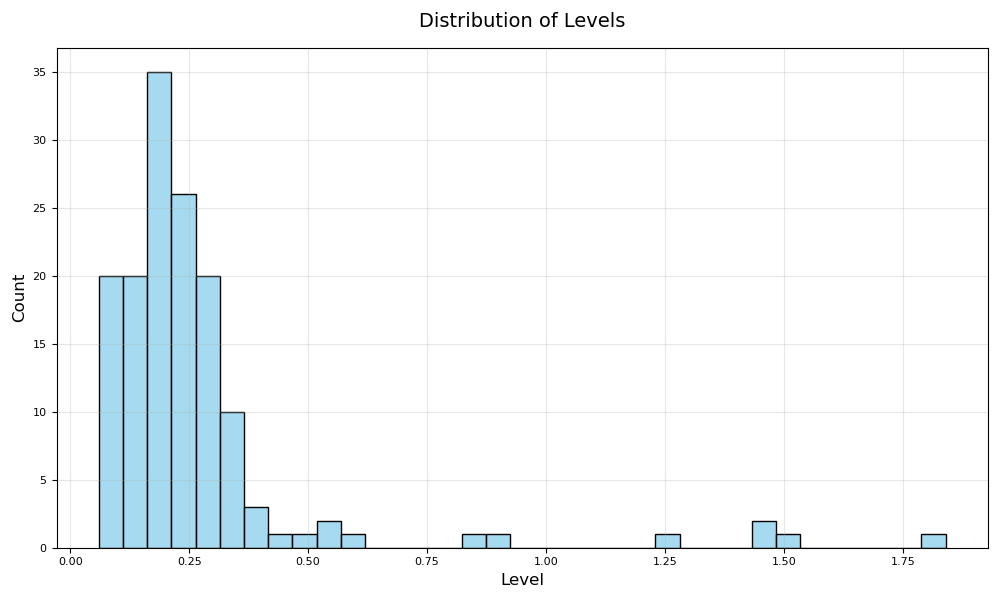

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_level_histogram(df, bins=10):
    """
    Creates a histogram of the level column with enhanced styling
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the level column
    bins (int): Number of bins for the histogram
    """
    # Set the style
    # plt.style.use('seaborn')
    
    # Create figure and axis objects with larger size
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    sns.histplot(data=df, x='level', bins=bins, color='skyblue', edgecolor='black')
    # sns.histplot(data=df, x='within_area_multiple', bins=bins, color='skyblue', edgecolor='black')
    
    # Customize the plot
    plt.title('Distribution of Levels', pad=15, fontsize=14)
    # plt.title('Distribution of within_area_multiples', pad=15, fontsize=14)
    plt.xlabel('Level', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Example usage:
plot_level_histogram(result_df, bins=35)